Import nltk and download required packages

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malakashour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malakashour/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malakashour/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/malakashour/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
#Install TensorFlow
#%pip install --user tensorflow

import tensorflow as tf
from tensorflow import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)


TensorFlow Version: 2.19.0
Keras Version: 3.9.2


Necessary Imports

In [5]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, ISRIStemmer
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from itertools import combinations
import numpy as np
from scipy.stats import spearmanr
from wordcloud import WordCloud

In [6]:
plt.rcParams['font.family'] = 'Arial'

In [7]:
arabic_stopwords = set(stopwords.words('arabic'))
arabic_stopwords
stemmer = ISRIStemmer()

Read the csv file

In [8]:
from nltk.corpus import stopwords

# Load the base list from NLTK
nltk_arabic_stopwords = set(stopwords.words('arabic'))

# Define your own extended list (add more based on your domain/context)
custom_stopwords = {
    'هذا', 'هذه', 'ذلك', 'تلك', 'الذي', 'التي',
    'ما', 'ماذا', 'لماذا', 'من', 'في', 'على',
    'الى', 'أو', 'و', 'ثم', 'قد', 'بل', 'إن',
    'هل', 'كان', 'كانت', 'يكون', 'يمكن', 'كل',
    'أي', 'أين', 'كيف', 'هكذا', 'عندما', 'إذ',
    'أنا', 'هو', 'هي', 'هم', 'نحن', 'انت', 'أنت'
    # Add more based on your text content
}

# Combine both sets
arabic_stopwords = nltk_arabic_stopwords.union(custom_stopwords)

In [9]:
df = pd.read_csv('/Users/malakashour/Downloads/elissa_lyrics.csv', encoding='utf-8-sig')
print("Original Lyrics Sample:")
print(df['Lyrics'].head())


Original Lyrics Sample:
0    متخفش مني\nمتخفش مني\nمتخفش مني\nمتخفش مني\nأن...
1    أجمل إحساس\nأجمل إحساس\nأجمل إحساس\nأجمل إحساس...
2    أسعد واحدة\nأسعد واحدة\nأسعد واحدة\nالفرحة الل...
3    أغلى الحبايب\nأغلى الحبايب\nأغلى الحبايب\nأغلى...
4    أنا بستغرب عليه\nأنا بستغرب عليه\nأنا بستغرب ع...
Name: Lyrics, dtype: object


Functions used for preprocessing

In [10]:
def remove_diacritics(text):
    diacritics = r'[\u0617-\u061A\u064B-\u065F]'
    text = re.sub(diacritics, '', text)
    return text

In [11]:
def remove_hamzas(text):
    text = re.sub(r'[أإآٱ]', 'ا', text)  # أ, إ, آ, ٱ → ا
    return text

In [12]:
def replaced_words(text):
    text= re.sub(r'ة', 'ه', text) #ة → ه
    text = re.sub(r'ي\b', 'ى', text) #ي → ى
    return text   

In [13]:
#remove repeated letters
def deduplicate_letters(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [14]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [15]:
# Apply same cleaning to the stopword list
def normalize_word(word):
    word = remove_diacritics(word)
    word = remove_hamzas(word)
    word = replaced_words(word)
    word = deduplicate_letters(word)  # Optional: if you apply this to text
    word = remove_punctuation(word)
    return word

arabic_stopwords = set(normalize_word(word) for word in arabic_stopwords)


In [16]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(filtered_words)


In [17]:
def tokenize_text(text):
    return [word for word in text.split() if word.strip()]

In [18]:
arabic_stopwords_normalized = {normalize_word(word) for word in arabic_stopwords}

In [19]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Remove diacritics
    text = remove_diacritics(text)
    
    # Normalize Arabic letters
    text = remove_hamzas(text)
    text = replaced_words(text)
    
    # Remove repeated letters
    text = deduplicate_letters(text)
    
    # Remove punctuation
    text = remove_punctuation(text)
    
    # Tokenize ensuring strict separation of words
    tokens = re.findall(r'\b\w+\b', text)  # Extract words strictly
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in arabic_stopwords]
    
    # Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    return '\n'.join(tokens)  # Ensure each word appears on a new line

# Apply preprocessing
df['Processed_Lyrics'] = df['Lyrics'].apply(preprocess_text)

In [20]:
#print number of rows in the dataset
print(df.shape[0])

105


In [21]:
Lyricist = ['نادر عبدالله', 'محمد رفاعى', 'سلامة على', 'احمد الجندى', 'محمد الرفاعى', 'امير طعيمة', 'ايمن قميحة', 'احمد ماضى', 'امير طعيمة', 'كميل خورى', 'اسماعيل الحبروك', 'نادر عبدالله', 'شادى نور', 'عمر سارى', 'عمر سارى', 'هانى عبد الكريم', 'سهام الشعشاع', 'محمد جمعه', 'سلامه على', 'ايمن بهجت قمر', 'سلامه على', 'مروان خورى', 'الياس ناصر', 'نادر عبدالله', 'فيصل همامى', 'احمد مرزوق', 'روميو لحود', 'احمد الجندى', 'سلامه على', 'نادر عبدالله', 'احمد الجندى', 'امير طعيمه', 'نادر عبدالله', 'عادل رفول', 'مروان سعادة', 'نادر عبدالله', 'سامح العجمى', 'الياس ناصر', 'محمد رحيم', 'كمال القبيسى', 'الياس ناصر', 'مروان خورى', 'ملاك عادل', 'محمد رفاعى', 'الياس ناصر', 'نبيل ابو عبدو', 'نبيل ابو عبدو', 'اسامه مصطفى', 'احمد مرزوق', 'فارس اسكندر', 'سليم عساف', 'محمد رفاعى', 'تامر حسين', 'نادر عبدالله', 'امير طعيمه', 'رامى جمال', 'مروان خورى', 'سهام الشعشاع', 'امير طعيمه', 'احمد الجندى', 'نادر عبدالله', 'احمد مرزوق', 'يوسف سليمان', 'مروان خورى', 'نادر عبدالله', 'محمد رحيم', 'نادر عبدالله', 'محمد رفاعى', 'اسامه مصطفى', 'عادل رفول', 'مروان خورى', 'على المولى', 'نزار فرنسىس', 'اكرام العاصى', 'طونى ابى كرم', 'نادر عبدالله', 'مروان خورى', 'بهاء الدىن محمد', 'هانى عبد الكرىم', 'منىر بو عساف', 'منير جورج عساف', 'اسامة مصطفى', 'نادر عبدالله', 'على المولى', 'نادر عبدالله', 'اسامة مصطفى', 'احمد الجندى', 'على المولى', 'بهاء الدىن محمد', 'نادر عبدالله', 'خالد امين', 'امير طعيمة', 'نادر عبدالله', 'اسامه مصطفى', 'امير طعيمة', 'نادر عبدالله', 'الياس ناصر', 'نادر عبدالله', 'نادر عبدالله', 'شادى نور', 'سعىد مرسى', 'الياس ناصر', 'نادر عبدالله', 'صلاح الكردي', 'أحمد ماضي']

Composer = ['ياسر نور', 'محمد رحيم و محمد رفاعى', 'محمد يحيى', 'مدين', 'ايمن محسب', 'وليد سعد', 'اوسين', 'زياد برجى', 'وليد سعد', 'كميل خورى', 'منير مراد', 'تامر على', 'محمد يحيى', 'محمد بشار', 'محمد بشار', 'وليد سعد', 'محمد رحيم', 'محمد رحيم', 'شريف بدر', 'محمد يحيى', 'محمد يحيى', 'مروان شهود', 'غوليس', 'محمد يحيى', 'تامر على', 'محمد يحيى', 'روميو لحود', 'مدين', 'محمد يحيى', 'سونر جيركيكير', 'مدين', 'زياد برجى', 'تامر عاشور', 'ناصر الاسعد', 'برنار لياميس و جيف بارنيل', 'وليد سعد', 'شريف تاج', 'جورج كرم', 'محمد رحيم', 'اسامه الرحبانى', 'سردار اورتاج', 'مروان خورى', 'محمد يحيى', 'محمد رفاعى', 'الكس فوكس', 'جيرار فيرير', 'تركان', 'سامر ابو طالب', 'محمد رحيم', 'سليم سلامه', 'سليم عساف', 'حسام حبيب و جان مارى رياشى', 'عمرو مصطفى', 'محمد رحيم', 'وليد سعد', 'رامى جمال', 'مروان خورى', 'محمد رحيم', 'محمد يحيى', 'مدين', 'وليد سعد', 'محمد رحيم', 'صلاح الكردى', 'مروان خورى', 'تامر عاشور', 'محمد رحيم', 'محمد يحيى', 'حسام حبيب', 'سامر ابو طالب', 'جان صليبا', 'مروان خورى', 'فضل سليمان', 'ناصر الاسعد', 'محمد رحيم','ناصر الاسعد', 'رامى جمال', 'مروان خورى', 'مدين', 'مدين', 'نهاد نجار', 'نهاد نجار', 'محمد يحيى', 'تامر على', 'صلاح الكردى', 'تامر عاشور', 'سامر ابو طالب', 'مدين', 'رامى الشافعى', 'مدين', 'وليد سعد', 'محمد رحيم', 'رامى جمال', 'محمد يحيى', 'سامر ابو طالب', 'رامى جمال', 'جان صليبا', 'فياز كوروز', 'ابراهيم تاتليسس', 'محمد يحيى', 'محمد يحيى', 'بليغ حمدى', 'فياز كوروز', 'نزيه اسلر', 'صلاح الكردي ','زياد برجي']

Year = ['2006', '2002', '2012', '2016', '2008', '2020', '2014', '2022', '2018', '2017', '2014', '2007', '2018', '2020', '2018', '2018', '2012', '2010', '2016', '2023', '2014', '2008', '1999', '2014', '2006', '2014', '2018', '2018', '2012', '2014', '2014', '2020', '2006', '1999', '2015', '2007', '2004', '2000', '2017', '2022', '2000', '2010', '2016', '2005', '2000', '2005', '2002', '2020', '2022', '2009', '2018', '2002', '2018', '2020', '2016', '2020', '2023', '2019', '2014', '2016', '2010', '2012', '2016', '2009', '2006', '2012', '2014', '2004', '2016', '2012', '2006', '2018', '2002', '2007', '2002', '2018', '2014', '2014', '2012', '2006', '2004', '2020', '2009', '2023', '2012', '2016', '2016', '2018', '2016', '2009', '2012', '2018', '2016', '2016', '2022', '2018', '2000', '2018', '2016', '2020', '2018', '2000', '2016', '2016', '2014']

print(f"Length of Lyricist: {len(Lyricist)}")
print(f"Length of Composer: {len(Composer)}")
print(f"Length of Year: {len(Year)}")

df['Lyricist'] = Lyricist
df['composer'] = Composer
df['year']= Year


Length of Lyricist: 105
Length of Composer: 105
Length of Year: 105


In [22]:
# Load model and tokenizer
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


In [23]:
# Sentiment labels mapping (based on CAMeL BERT sentiment analysis)
id2label = {0: "negative", 1: "neutral", 2: "positive"}

In [24]:
def bert_sentiment_analysis(lyrics):
    if not isinstance(lyrics, str) or lyrics.strip() == '':
        return 'neutral'
    
    # Truncate to 512 tokens (BERT's max length)
    lyrics = ' '.join(lyrics.split()[:512])

    # Tokenize the input text
    inputs = tokenizer(lyrics, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted sentiment
    predicted_class = torch.argmax(outputs.logits).item()
    return id2label[predicted_class]

In [25]:
# Apply to DataFrame
df['Sentiment_BERT'] = df['Lyrics'].apply(bert_sentiment_analysis)

In [26]:
print("BERT-Based Sentiment Analysis Results:")
print(df[['Song Title', 'Sentiment_BERT']].head())

BERT-Based Sentiment Analysis Results:
         Song Title Sentiment_BERT
0         متخفش مني       positive
1        أجمل إحساس       negative
2        أسعد واحدة       negative
3     أغلى الحبايب        negative
4  أنا بستغرب عليه         neutral


In [27]:
output_file = '/Users/malakashour/Downloads/elissa_lyrics_preprocessed.csv'

Save the preprocessed lyrics to another csv file

In [28]:
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Preprocessed lyrics saved to {output_file}")
print(df.head())

Preprocessed lyrics saved to /Users/malakashour/Downloads/elissa_lyrics_preprocessed.csv
         Song Title                                             Lyrics  \
0         متخفش مني  متخفش مني\nمتخفش مني\nمتخفش مني\nمتخفش مني\nأن...   
1        أجمل إحساس  أجمل إحساس\nأجمل إحساس\nأجمل إحساس\nأجمل إحساس...   
2        أسعد واحدة  أسعد واحدة\nأسعد واحدة\nأسعد واحدة\nالفرحة الل...   
3     أغلى الحبايب   أغلى الحبايب\nأغلى الحبايب\nأغلى الحبايب\nأغلى...   
4  أنا بستغرب عليه   أنا بستغرب عليه\nأنا بستغرب عليه\nأنا بستغرب ع...   

                                                 URL  \
0  https://lyricstranslate.com/en/elissa-metkahaf...   
1  https://lyricstranslate.com/en/elissa-agmal-eh...   
2  https://lyricstranslate.com/en/elissa-assad-wa...   
3  https://lyricstranslate.com/en/elissa-aghla-el...   
4  https://lyricstranslate.com/en/elissa-ana-bast...   

                                    Processed_Lyrics      Lyricist  \
0  تخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nزي...  نادر 

In [29]:
df['Processed_Lyrics'] = df['Processed_Lyrics'].astype(str)

In [30]:
# Install deep_translator if not already installed
%pip install deep-translator

from transformers import pipeline
from deep_translator import GoogleTranslator

# Load emotion analysis pipeline (English)
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

# Initialize translator
translator = GoogleTranslator(source='ar', target='en')

def analyze_emotions_translated(lyrics):
    if not isinstance(lyrics, str) or lyrics.strip() == '':
        return 'neutral'
    # Translate Arabic to English
    try:
        translated_lyrics = translator.translate(lyrics)
        # Truncate to 512 tokens
        translated_lyrics = ' '.join(translated_lyrics.split()[:512])
        # Get emotion scores
        emotions = emotion_classifier(translated_lyrics)[0]
        dominant_emotion = max(emotions, key=lambda x: x['score'])['label']
        return dominant_emotion
    except Exception as e:
        print(f"Translation error: {e}")
        return 'neutral'

# Apply emotion analysis to translated lyrics
df['Emotion'] = df['Lyrics'].apply(analyze_emotions_translated)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Device set to use mps:0


In [31]:
print("Emotion Analysis Results:")
print(df[['Song Title', 'Emotion']].head())

Emotion Analysis Results:
         Song Title   Emotion
0         متخفش مني      fear
1        أجمل إحساس     anger
2        أسعد واحدة   sadness
3     أغلى الحبايب    sadness
4  أنا بستغرب عليه   surprise


/var/folders/ln/886ccf112yvckr1xgsr6znnm0000gn/T/ipykernel_9242/568316803.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Emotion', palette='muted')


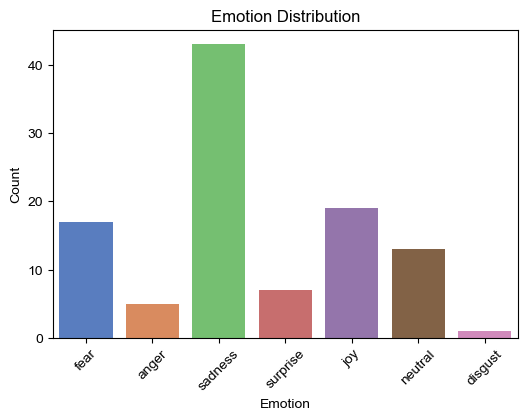

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Emotion', palette='muted')
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20)  # Limit to top 20 features for simplicity

# Compute TF-IDF on processed lyrics
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Lyrics'])

# Get feature names (words)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)

# Add TF-IDF results to the main DataFrame (e.g., top word per song)
df['Top_TFIDF_Word'] = tfidf_df.idxmax(axis=1)

In [34]:
print("Top TF-IDF Words per Song (Sample):")
print(df[['Song Title', 'Top_TFIDF_Word']].head())

Top TF-IDF Words per Song (Sample):
         Song Title Top_TFIDF_Word
0         متخفش مني          حبيبى
1        أجمل إحساس          حبيبى
2        أسعد واحدة            دنا
3     أغلى الحبايب            عمرى
4  أنا بستغرب عليه             بقى


/var/folders/ln/886ccf112yvckr1xgsr6znnm0000gn/T/ipykernel_9242/2443868278.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_sums.values, y=tfidf_sums.index, palette='coolwarm')


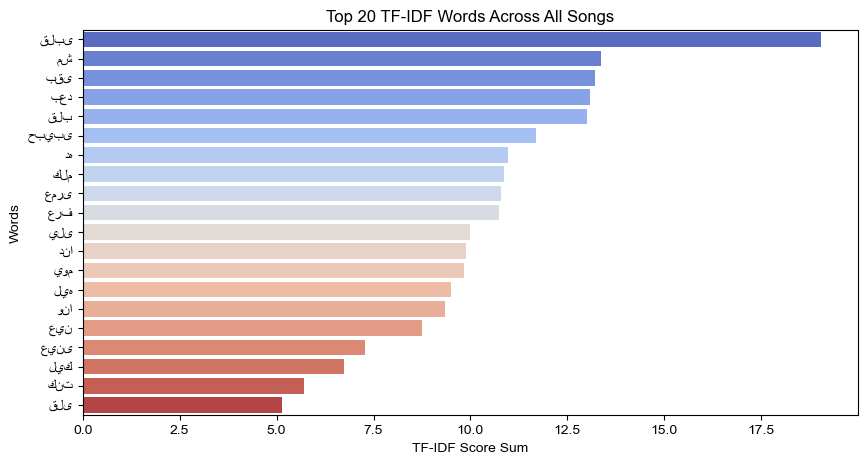

In [35]:
tfidf_sums = tfidf_df.sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=tfidf_sums.values, y=tfidf_sums.index, palette='coolwarm')
plt.title("Top 20 TF-IDF Words Across All Songs")
plt.xlabel("TF-IDF Score Sum")
plt.ylabel("Words")
plt.show()

In [36]:
# Save updated DataFrame with emotion and TF-IDF results
output_file_updated = 'C:\\Users\\Kimo Store\\Downloads\\deep\\output\\elissa_lyrics_preprocessed_with_emotion_tfidf.csv'
df.to_csv(output_file_updated, index=False, encoding='utf-8-sig')
print(f"Updated DataFrame with emotion and TF-IDF saved to {output_file_updated}")

Updated DataFrame with emotion and TF-IDF saved to C:\Users\Kimo Store\Downloads\deep\output\elissa_lyrics_preprocessed_with_emotion_tfidf.csv


In [37]:
# Group by Lyricist and compute sentiment distribution
lyricist_sentiment = df.groupby('Lyricist')['Sentiment_BERT'].value_counts(normalize=True).unstack().fillna(0)
lyricist_sentiment = lyricist_sentiment[['positive', 'neutral', 'negative']]  # Ensure consistent order

# Group by Lyricist and compute emotion distribution
lyricist_emotion = df.groupby('Lyricist')['Emotion'].value_counts(normalize=True).unstack().fillna(0)

# Filter lyricists with at least 3 songs to ensure meaningful statistics
min_songs = 3
lyricist_counts = df['Lyricist'].value_counts()
valid_lyricists = lyricist_counts[lyricist_counts >= min_songs].index
lyricist_sentiment = lyricist_sentiment.loc[lyricist_sentiment.index.isin(valid_lyricists)]
lyricist_emotion = lyricist_emotion.loc[lyricist_emotion.index.isin(valid_lyricists)]

# Display results
print("Sentiment Distribution by Lyricist:")
print(lyricist_sentiment)
print("\nEmotion Distribution by Lyricist:")
print(lyricist_emotion)

Sentiment Distribution by Lyricist:
Sentiment_BERT  positive   neutral  negative
Lyricist                                    
احمد الجندى     0.000000  0.200000  0.800000
احمد مرزوق      0.333333  0.666667  0.000000
اسامه مصطفى     0.333333  0.000000  0.666667
الياس ناصر      0.833333  0.166667  0.000000
امير طعيمة      0.000000  0.750000  0.250000
امير طعيمه      0.000000  0.666667  0.333333
سلامه على       0.333333  0.333333  0.333333
على المولى      0.000000  1.000000  0.000000
محمد رفاعى      0.250000  0.000000  0.750000
مروان خورى      0.333333  0.333333  0.333333
نادر عبدالله    0.421053  0.263158  0.315789

Emotion Distribution by Lyricist:
Emotion          anger   disgust      fear       joy   neutral   sadness  \
Lyricist                                                                   
احمد الجندى   0.000000  0.000000  0.000000  0.200000  0.000000  0.800000   
احمد مرزوق    0.000000  0.000000  0.000000  0.333333  0.333333  0.333333   
اسامه مصطفى   0.000000  0.000000  0.3333

In [38]:
# Group by Composer and compute sentiment distribution
composer_sentiment = df.groupby('composer')['Sentiment_BERT'].value_counts(normalize=True).unstack().fillna(0)
composer_sentiment = composer_sentiment[['positive', 'neutral', 'negative']]

# Group by Composer and compute emotion distribution
composer_emotion = df.groupby('composer')['Emotion'].value_counts(normalize=True).unstack().fillna(0)

# Filter composers with at least 3 songs
composer_counts = df['composer'].value_counts()
valid_composers = composer_counts[composer_counts >= min_songs].index
composer_sentiment = composer_sentiment.loc[composer_sentiment.index.isin(valid_composers)]
composer_emotion = composer_emotion.loc[composer_emotion.index.isin(valid_composers)]

# Display results
print("Sentiment Distribution by Composer:")
print(composer_sentiment)
print("\nEmotion Distribution by Composer:")
print(composer_emotion)

Sentiment Distribution by Composer:
Sentiment_BERT  positive   neutral  negative
composer                                    
تامر عاشور      0.666667  0.000000  0.333333
تامر على        0.333333  0.333333  0.333333
رامى جمال       0.000000  0.500000  0.500000
سامر ابو طالب   0.250000  0.000000  0.750000
محمد رحيم       0.300000  0.300000  0.400000
محمد يحيى       0.285714  0.428571  0.285714
مدين            0.375000  0.125000  0.500000
مروان خورى      0.400000  0.400000  0.200000
ناصر الاسعد     0.000000  0.333333  0.666667
وليد سعد        0.142857  0.714286  0.142857

Emotion Distribution by Composer:
Emotion           anger  disgust      fear       joy   neutral   sadness  \
composer                                                                   
تامر عاشور     0.000000      0.0  0.000000  0.000000  0.333333  0.333333   
تامر على       0.000000      0.0  0.000000  0.333333  0.333333  0.333333   
رامى جمال      0.000000      0.0  0.000000  0.250000  0.500000  0.250000   
سامر ابو 

In [39]:
# Convert Sentiment_BERT to numerical scores
sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['Sentiment_Score'] = df['Sentiment_BERT'].map(sentiment_map)

# Kruskal-Wallis test for Lyricists
lyricist_groups = [df[df['Lyricist'] == lyricist]['Sentiment_Score'].values for lyricist in valid_lyricists]
if len(lyricist_groups) > 1:
    stat_lyricist, p_lyricist = kruskal(*lyricist_groups)
    print(f"Kruskal-Wallis Test for Lyricists: Statistic={stat_lyricist:.2f}, p-value={p_lyricist:.4f}")
    if p_lyricist < 0.05:
        print("Significant difference in sentiment across lyricists (p < 0.05)")
    else:
        print("No significant difference in sentiment across lyricists (p >= 0.05)")
else:
    print("Not enough lyricist groups for Kruskal-Wallis test.")

# Kruskal-Wallis test for Composers
composer_groups = [df[df['composer'] == composer]['Sentiment_Score'].values for composer in valid_composers]
if len(composer_groups) > 1:
    stat_composer, p_composer = kruskal(*composer_groups)
    print(f"Kruskal-Wallis Test for Composers: Statistic={stat_composer:.2f}, p-value={p_composer:.4f}")
    if p_composer < 0.05:
        print("Significant difference in sentiment across composers (p < 0.05)")
    else:
        print("No significant difference in sentiment across composers (p >= 0.05)")
else:
    print("Not enough composer groups for Kruskal-Wallis test.")

Kruskal-Wallis Test for Lyricists: Statistic=14.60, p-value=0.1474
No significant difference in sentiment across lyricists (p >= 0.05)
Kruskal-Wallis Test for Composers: Statistic=5.38, p-value=0.7998
No significant difference in sentiment across composers (p >= 0.05)


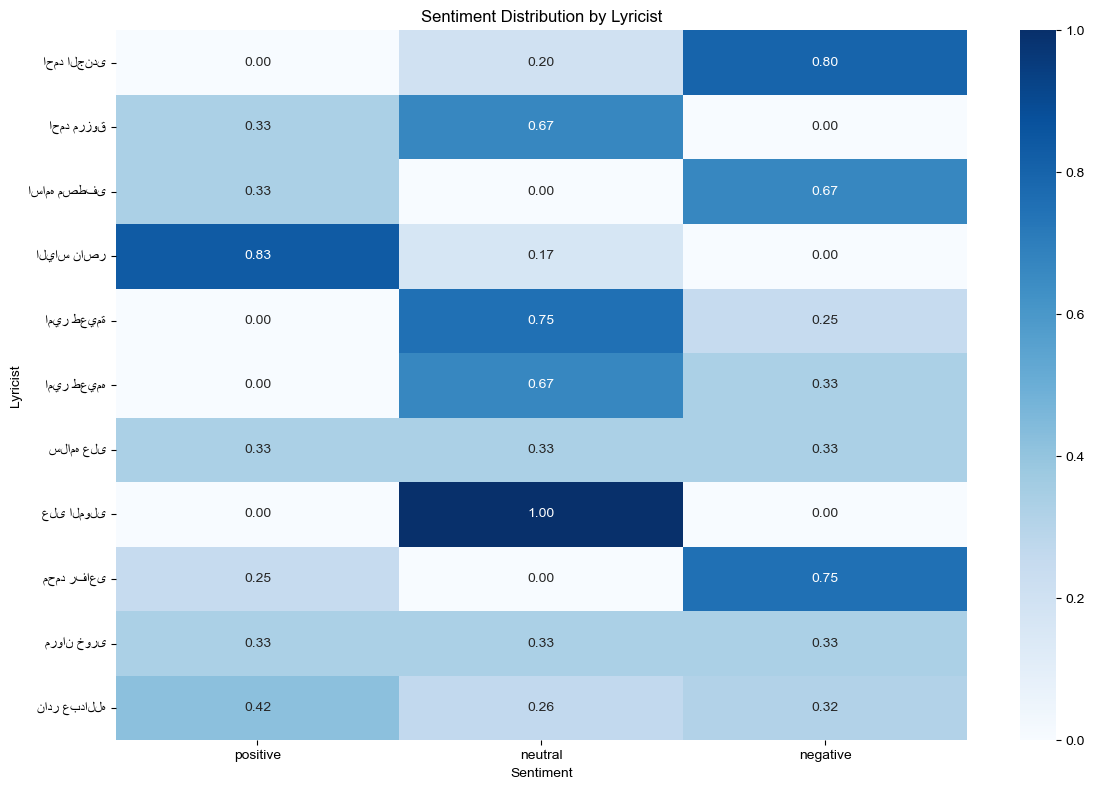

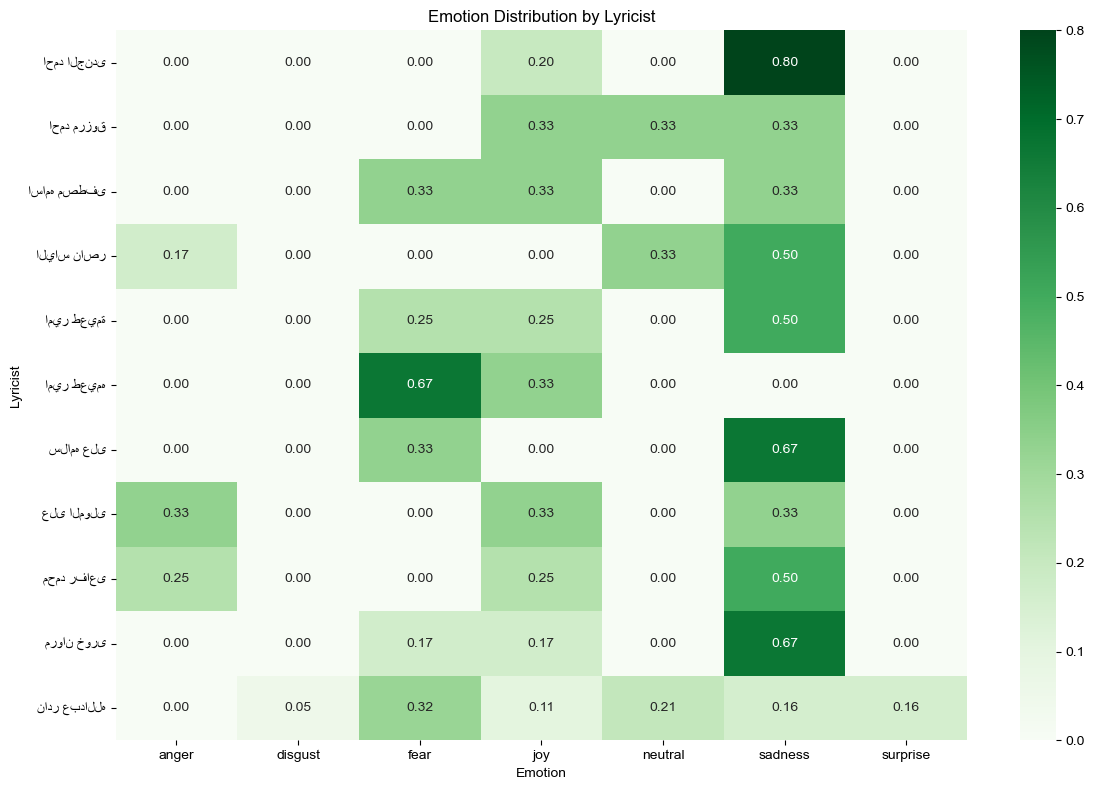

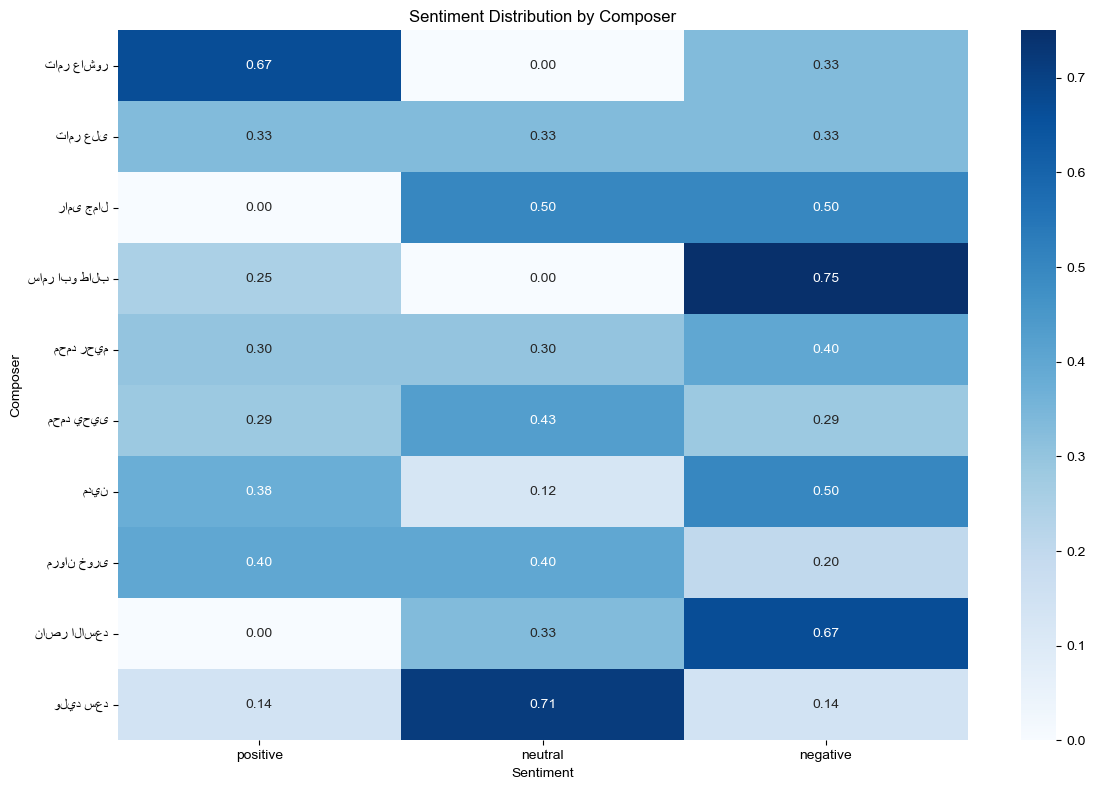

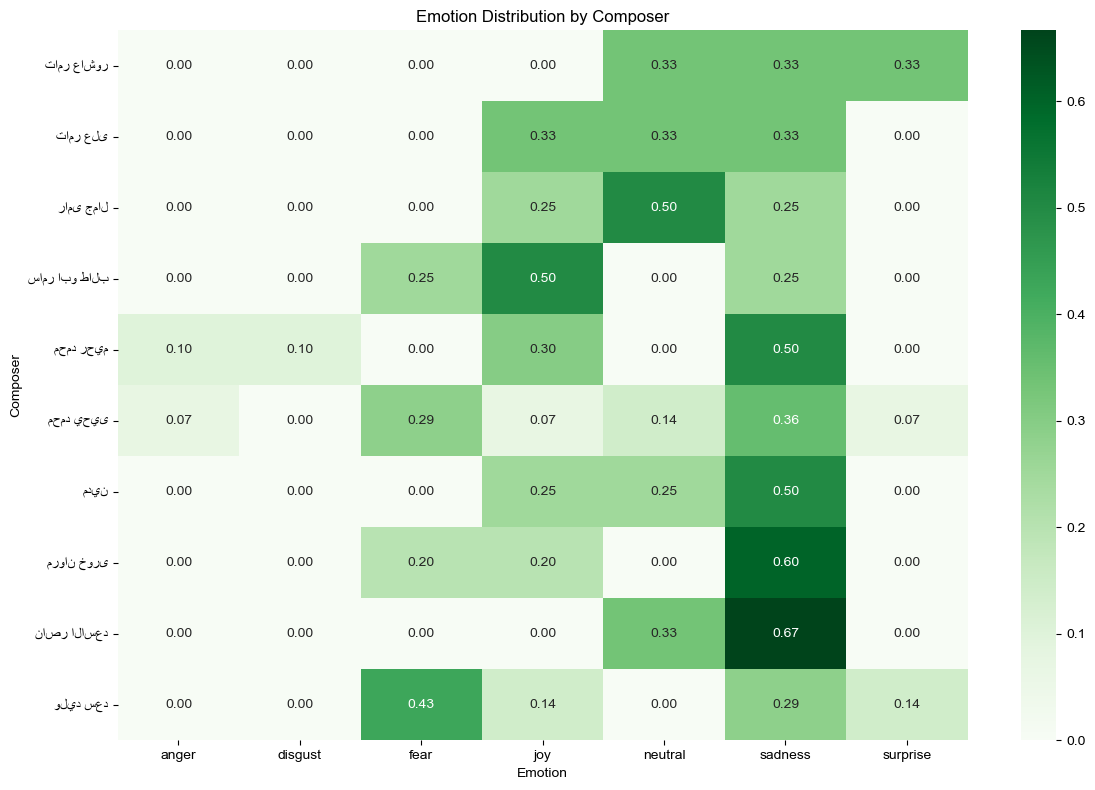

In [40]:
# Sentiment Heatmap for Lyricists
plt.figure(figsize=(12, 8))
sns.heatmap(lyricist_sentiment, annot=True, cmap='Blues', fmt='.2f')
plt.title('Sentiment Distribution by Lyricist')
plt.xlabel('Sentiment')
plt.ylabel('Lyricist')
plt.tight_layout()
plt.show()

# Emotion Heatmap for Lyricists
plt.figure(figsize=(12, 8))
sns.heatmap(lyricist_emotion, annot=True, cmap='Greens', fmt='.2f')
plt.title('Emotion Distribution by Lyricist')
plt.xlabel('Emotion')
plt.ylabel('Lyricist')
plt.tight_layout()
plt.show()

# Sentiment Heatmap for Composers
plt.figure(figsize=(12, 8))
sns.heatmap(composer_sentiment, annot=True, cmap='Blues', fmt='.2f')
plt.title('Sentiment Distribution by Composer')
plt.xlabel('Sentiment')
plt.ylabel('Composer')
plt.tight_layout()
plt.show()

# Emotion Heatmap for Composers
plt.figure(figsize=(12, 8))
sns.heatmap(composer_emotion, annot=True, cmap='Greens', fmt='.2f')
plt.title('Emotion Distribution by Composer')
plt.xlabel('Emotion')
plt.ylabel('Composer')
plt.tight_layout()
plt.show()

In [41]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year']).copy()
df['year'] = df['year'].astype(int)

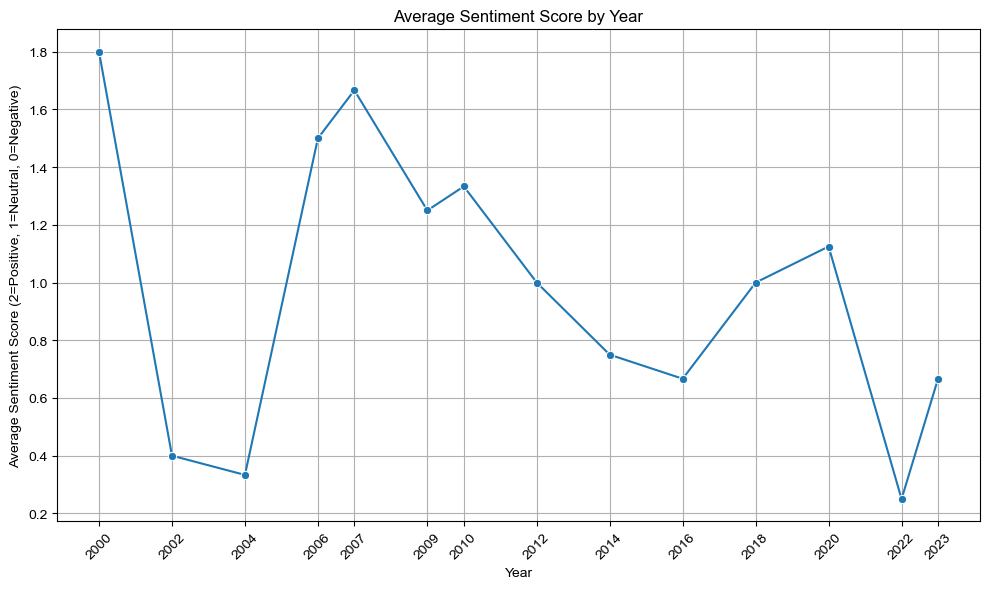

Spearman Correlation for Sentiment Score vs. Year: Correlation=-0.38, p-value=0.1816
No significant trend in sentiment over time (p >= 0.05)


In [42]:
# Group by year and compute average Sentiment_Score
sentiment_by_year = df.groupby('year')['Sentiment_Score'].mean().reset_index()

# Filter years with at least 3 songs for reliable statistics
year_counts = df['year'].value_counts()
valid_years = year_counts[year_counts >= 3].index
sentiment_by_year = sentiment_by_year[sentiment_by_year['year'].isin(valid_years)]

# Plot sentiment trend
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='Sentiment_Score', data=sentiment_by_year, marker='o')
plt.title('Average Sentiment Score by Year')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score (2=Positive, 1=Neutral, 0=Negative)')
plt.grid(True)
plt.xticks(sentiment_by_year['year'].astype(int), rotation=45)
plt.tight_layout()
plt.show()

# Spearman correlation test for sentiment trend
corr, p_value = spearmanr(sentiment_by_year['year'], sentiment_by_year['Sentiment_Score'])
print(f"Spearman Correlation for Sentiment Score vs. Year: Correlation={corr:.2f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Significant trend in sentiment over time (p < 0.05)")
else:
    print("No significant trend in sentiment over time (p >= 0.05)")

<Figure size 1200x800 with 0 Axes>

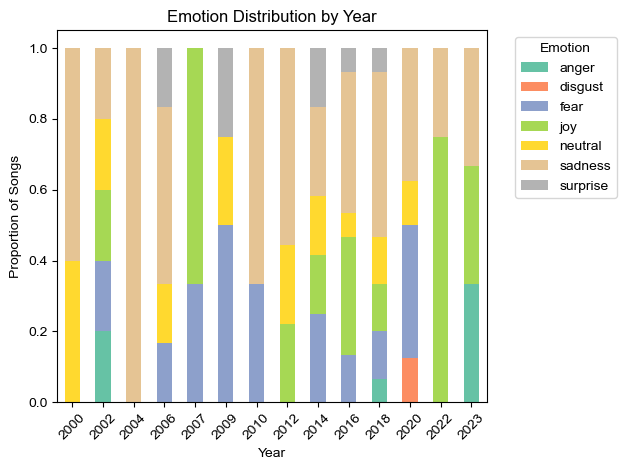

Emotion Distribution by Year:
Emotion     anger  disgust      fear       joy   neutral   sadness  surprise
year                                                                        
2000     0.000000    0.000  0.000000  0.000000  0.400000  0.600000  0.000000
2002     0.200000    0.000  0.200000  0.200000  0.200000  0.200000  0.000000
2004     0.000000    0.000  0.000000  0.000000  0.000000  1.000000  0.000000
2006     0.000000    0.000  0.166667  0.000000  0.166667  0.500000  0.166667
2007     0.000000    0.000  0.333333  0.666667  0.000000  0.000000  0.000000
2009     0.000000    0.000  0.500000  0.000000  0.250000  0.000000  0.250000
2010     0.000000    0.000  0.333333  0.000000  0.000000  0.666667  0.000000
2012     0.000000    0.000  0.000000  0.222222  0.222222  0.555556  0.000000
2014     0.000000    0.000  0.250000  0.166667  0.166667  0.250000  0.166667
2016     0.000000    0.000  0.133333  0.333333  0.066667  0.400000  0.066667
2018     0.066667    0.000  0.133333  0.133333

In [43]:
# Group by year and compute emotion distribution
emotion_by_year = df.groupby('year')['Emotion'].value_counts(normalize=True).unstack().fillna(0)
emotion_by_year = emotion_by_year.loc[emotion_by_year.index.isin(valid_years)]

# Plot stacked bar chart
plt.figure(figsize=(12, 8))
emotion_by_year.plot(kind='bar', stacked=True, cmap='Set2')
plt.title('Emotion Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Songs')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display emotion distribution
print("Emotion Distribution by Year:")
print(emotion_by_year)

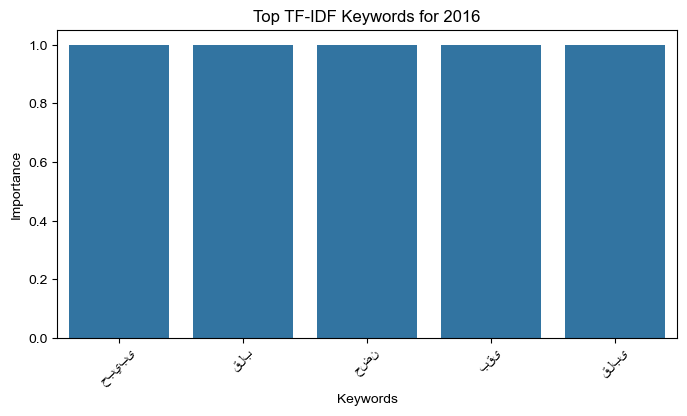

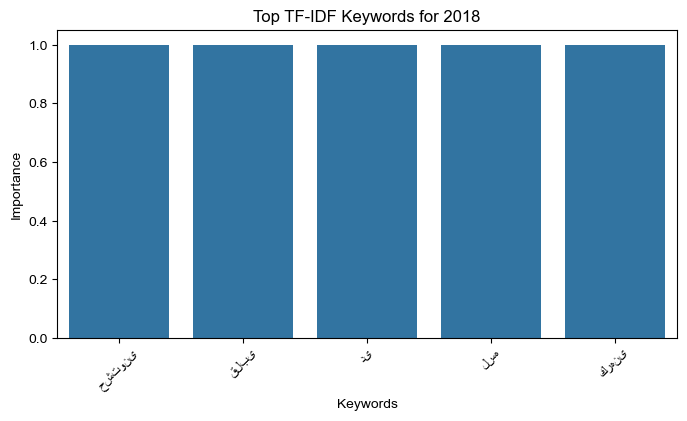

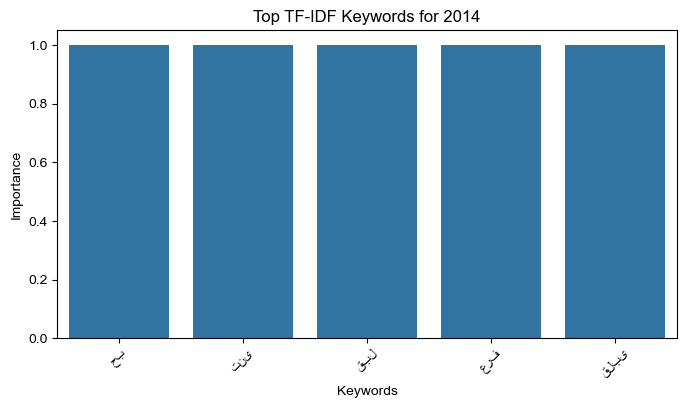

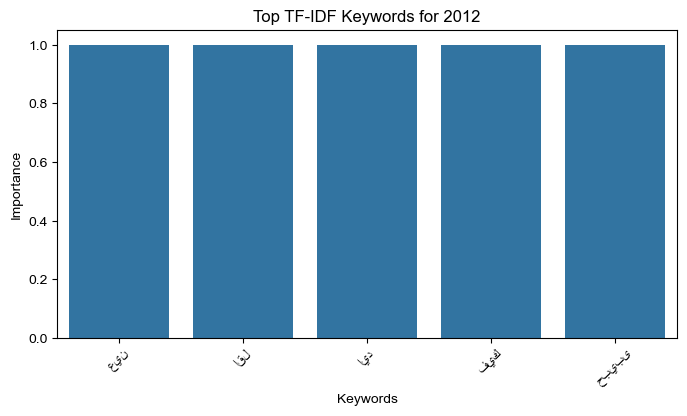

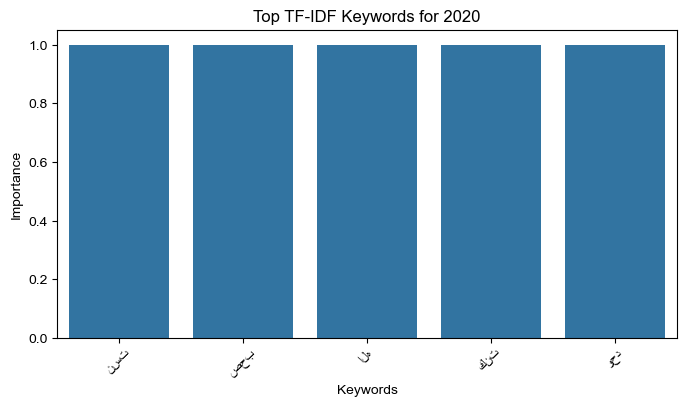

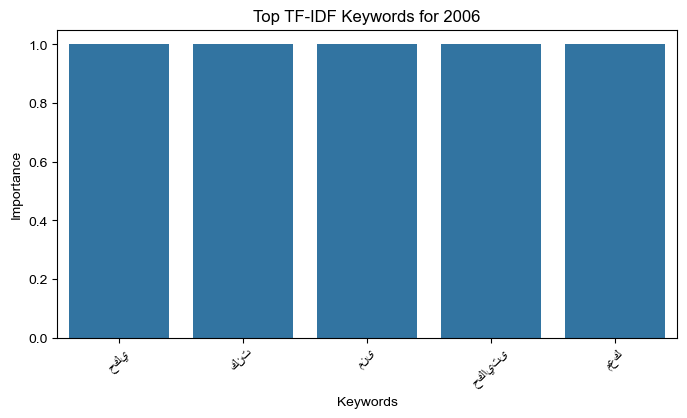

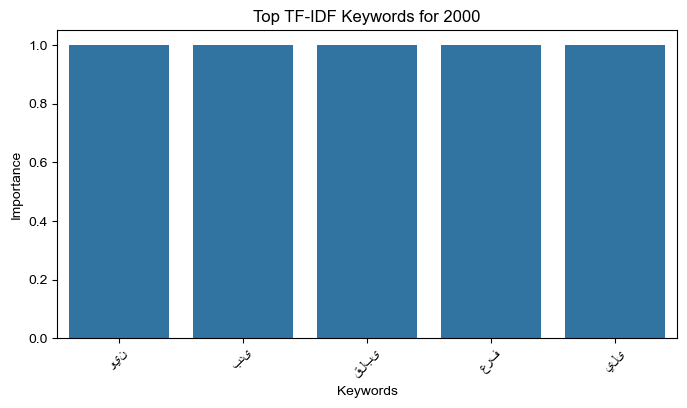

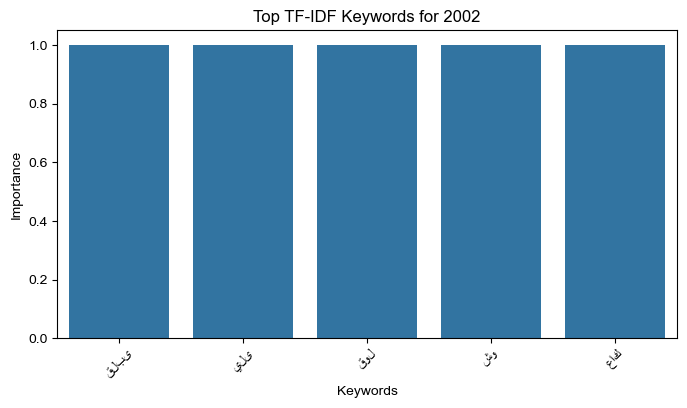

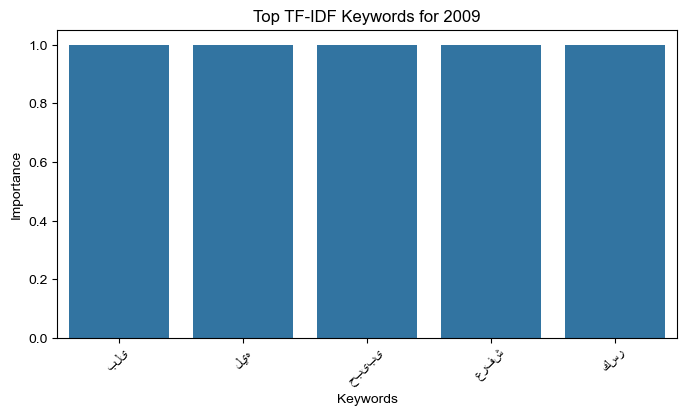

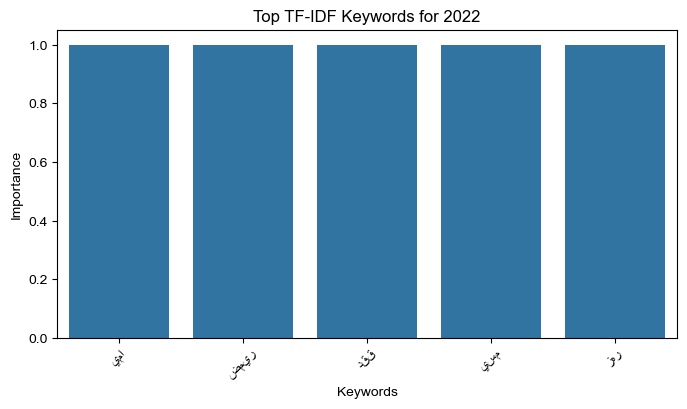

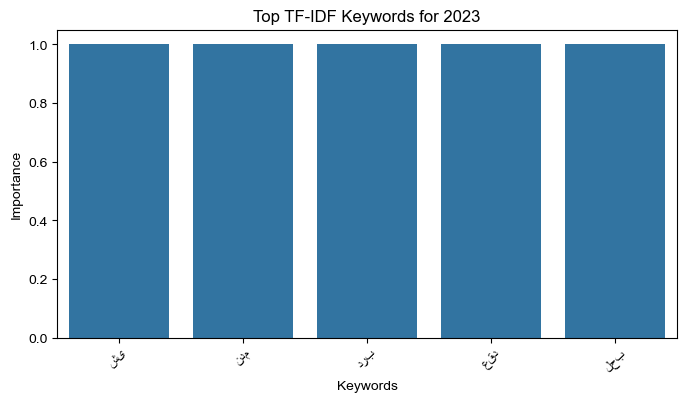

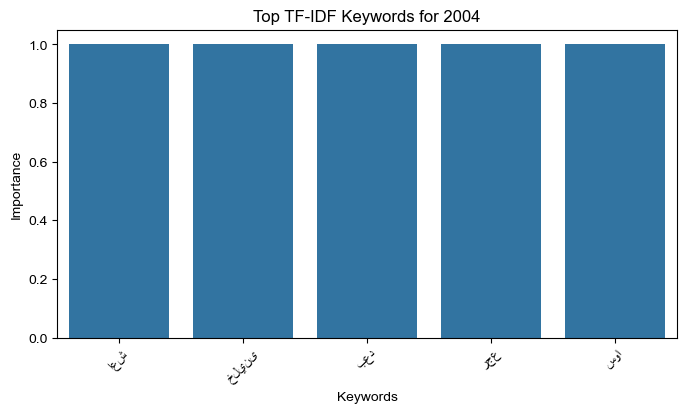

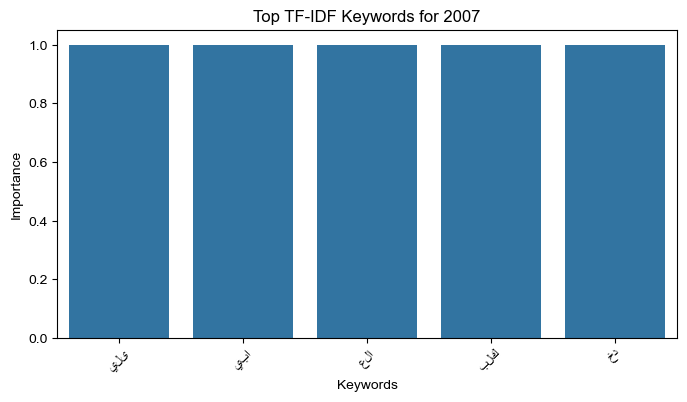

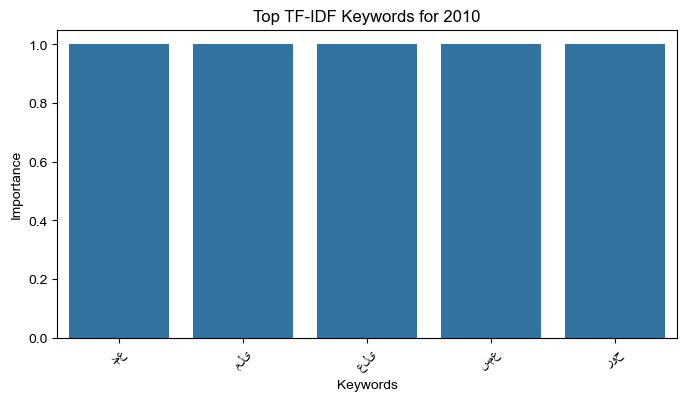

Top TF-IDF Keywords by Year:
2016: حبيبى, قلب, حضن, بقى, قلبى
2018: حشتونى, قلبى, دى, لسه, كرهنى
2014: حب, تنى, قبل, عرف, قلبى
2012: عين, اقل, ايد, فيك, حبيبى
2020: نست, صحب, اله, كنت, وحد
2006: حكي, كنت, منى, حكايتى, معك
2000: وين, بدى, قلبى, عرف, يلى
2002: قلبى, يلى, قول, شو, عاك
2009: بلی, ليه, حبیبی, عرفش, كسر
2022: يما, ضمير, دقق, يسم, زهر
2023: شى, ندم, درب, عقد, لحب
2004: اعش, خلينى, بعد, رجع, سوا
2007: يلى, يبا, علا, بلك, خد
2010: دمع, ملی, علی, سمع, روح


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to extract top TF-IDF words
def get_top_tfidf_words(texts, n=5):
    # Check if texts is empty or all elements are NaN
    if texts.empty or texts.isna().all():
        return []
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf.fit_transform(texts)
    feature_names = tfidf.get_feature_names_out()
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[-n:][::-1]
    return [feature_names[i] for i in top_indices]

# Group lyrics by year and extract top TF-IDF words
themes_by_year = {}
for year in valid_years:
    year_lyrics = df[df['year'] == year]['Processed_Lyrics'].dropna()
    if len(year_lyrics) >= 3:
        top_words = get_top_tfidf_words(year_lyrics, n=5)
        themes_by_year[year] = top_words

# Generate word clouds for each year
for year, words in themes_by_year.items():
    if words:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=words, y=[1]*len(words))
        plt.title(f'Top TF-IDF Keywords for {year}')
        plt.xlabel('Keywords')
        plt.ylabel('Importance')
        plt.xticks(rotation=45)
        plt.show()

# Display themes
print("Top TF-IDF Keywords by Year:")
for year, words in themes_by_year.items():
    print(f"{year}: {', '.join(words)}")

In [45]:
pip install transformers torch datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [46]:
from collections import Counter

# Extract the first word of each song's Processed_Lyrics
first_words = [text.split('\n')[0] for text in df['Processed_Lyrics'] if text]
word_counts = Counter(first_words)
print("Most common starting words:", word_counts.most_common(5))

# Choose a seed phrase (e.g., a common word like "قلبي")
seed = "قلبي"  # Adjust based on output or preference
print("Selected seed phrase:", seed)

Most common starting words: [('قلبى', 3), ('فكر', 2), ('حله', 2), ('عين', 2), ('تخفش', 1)]
Selected seed phrase: قلبي


In [48]:
from collections import Counter

# Check if df is defined
try:
    df
except NameError:
    raise NameError("DataFrame 'df' is not defined. Please run all cells up to Cell 22 in the notebook to load and preprocess the dataset.")

# Extract the first word of each song's Processed_Lyrics
first_words = [text.split('\n')[0] for text in df['Processed_Lyrics'] if text]
word_counts = Counter(first_words)
print("Most common starting words:", word_counts.most_common(5))

# Choose a seed phrase (e.g., a common word like "قلبي")
seed = "قلبي"  # Adjust based on output or preference
print("Selected seed phrase:", seed)

Most common starting words: [('قلبى', 3), ('فكر', 2), ('حله', 2), ('عين', 2), ('تخفش', 1)]
Selected seed phrase: قلبي


In [51]:
# Install transformers if not already installed
%pip install transformers

# Set environment variable to suppress tokenizers parallelism warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

# Load AraGPT2 model and tokenizer
model_name = "aubmindlab/aragpt2-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="./model_cache")
model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir="./model_cache")

# Move model to GPU if available
device = 0 if torch.cuda.is_available() else -1
if device == 0:
    model = model.to('cuda')

# Set up text generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)

Note: you may need to restart the kernel to use updated packages.


model.safetensors:  66%|######6   | 367M/553M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.hf.co/aubmindlab/aragpt2-base/6b4b440a9eabb37f4be98063101bb45946dfc163497333859f8cf833d7cef0a9?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1746115635&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjExNTYzNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9hdWJtaW5kbGFiL2FyYWdwdDItYmFzZS82YjRiNDQwYTllYWJiMzdmNGJlOTgwNjMxMDFiYjQ1OTQ2ZGZjMTYzNDk3MzMzODU5ZjhjZjgzM2Q3Y2VmMGE5P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=LWsJNWJBtrhdcGAAZHwM9RGBNZ8AWtJPkyxmi54SR1HZU6K8t3jnUxkQUrnywlcLcy0RQYLIanHhbBS%7EbkF1nIN4yWgAo7PuAvy92FGdRZouixVm5%7EsTRzaqi5LlRGlLdnzNYqm-VJjjymbDCSWlhYycCE09lNK1kT96F6SklfLg8gqDLRpgT9BJQBp-Z-Z2hePasmy%7EGm9tE5p%7EvoFwiZk1t43rGcIfbkgbixszcPYONqVEIaL2Cqu3Ls6XV%7ELGKUr5RYHkcR0S7Tp7-Vyi34noI4i6btUF7nBSU0hnyXSRLBpKRx1SbthTZ3xuEdTLSfwgBIHvvrZAGSFQuXChJA__&Key-Pair-Id=K3RPWS32NSSJCE: HTTPSConnec

model.safetensors:  99%|#########8| 545M/553M [00:00<?, ?B/s]

Device set to use cpu


In [52]:
import random

# Simple Arabic synonym dictionary (expand with a thesaurus)
synonym_dict = {
    'قلب': ['فؤاد', 'صدر'],
    'حب': ['عشق', 'غرام'],
    'يوم': ['نهار', 'وقت'],
}

def arabic_synonym_augmentation(text, n=2):
    words = text.replace('\n', ' ').split()
    if len(words) < n:
        return text
    indices = random.sample(range(len(words)), n)
    for i in indices:
        word = words[i]
        if word in synonym_dict:
            words[i] = random.choice(synonym_dict[word])
    return '\n'.join(words)

# Apply to a sample lyric
sample_lyric = df['Processed_Lyrics'][0]
augmented_lyric = arabic_synonym_augmentation(sample_lyric, n=2)
print("Original Lyric Sample:", sample_lyric[:100], "...")
print("Augmented Lyric Sample:", augmented_lyric[:100], "...")

Original Lyric Sample: تخفش
منى
تخفش
منى
تخفش
منى
تخفش
منى
زيى
تخف
ده
زيى
عمر
لقه
على
حبيبى
مش
هنسى
حبك
حبيبى
حضن
الش
كان
ح ...
Augmented Lyric Sample: تخفش
منى
تخفش
منى
تخفش
منى
تخفش
منى
زيى
تخف
ده
زيى
عمر
لقه
على
حبيبى
مش
هنسى
حبك
حبيبى
حضن
الش
كان
ح ...


In [2]:
import transformers

In [3]:
# Install required libraries (run this if not already installed)
# %pip install transformers torch

# Suppress tokenizers parallelism warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Import required libraries
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

# Load AraGPT2 model and tokenizer
model_name = "aubmindlab/aragpt2-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="./model_cache")
model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir="./model_cache")

# Move model to GPU if available
device = 0 if torch.cuda.is_available() else -1
if device == 0:
    model = model.to('cuda')
print(f"Device set to use: {'cuda' if device == 0 else 'cpu'}")

# Set up text generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)

# Define the seed phrase
seed = "قلبي"  # From Cell 48 of the notebook

# Generate text using the pipeline
generated_text = generator(
    seed,
    max_length=100,  # Adjust based on desired song length
    num_return_sequences=1,
    temperature=0.7,  # Controls randomness
    top_k=50,         # Limits sampling to top-k tokens
    top_p=0.9,        # Nucleus sampling
    do_sample=True    # Enable sampling for varied outputs
)[0]['generated_text']

print("Generated Song Lyrics:")
print(generated_text)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Device set to use: cpu
Generated Song Lyrics:
قلبي.. لا أدري ما الذي أفعله الآن ؟ هل سأرحل عن هذه الدنيا أم سأتنازل عن كل شيء في حياتي حتى لو كان هذا الشيء الوحيد الذي أستطيع أن أتخلى عنه ؟أنت تعرفين أنني لن أعود إلى الحياة مرة أخرى ، وأنني لم أعد قادرة على فعل أي شيء من أجلك أو من أجل شخص آخر غيرك.إذا كنت تعانين من عدم القدرة على العمل بشكل صحيح ، فأنت تحتاجين إلى بعض الوقت قبل أن تتعرفي على مشاكلك


In [10]:
pip install 'accelerate>=0.26.0'

Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install 'accelerate>=0.26.0'

Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install --upgrade accelerate
%pip install 'accelerate>=0.26.0'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [47]:
# Suppress tokenizers parallelism warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Import required libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, pipeline
from transformers.generation import LogitsProcessorList, MinLengthLogitsProcessor, NoBadWordsLogitsProcessor
from datasets import Dataset
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

# Paths
input_csv = '/Users/malakashour/Downloads/elissa_lyrics_preprocessed.csv'
output_model_dir = './aragpt2_elissa_finetuned'

# Load and inspect data
try:
    df
except NameError:
    df = pd.read_csv(input_csv, encoding='utf-8-sig')

# Debug: Inspect dataset
print("Dataset columns:", df.columns.tolist())
print("Sample Processed_Lyrics:", df['Processed_Lyrics'].head().tolist())
if 'Lyrics' in df.columns:
    print("Sample raw Lyrics:", df['Lyrics'].head().tolist())

# Filter and clean lyrics
def is_valid_lyric(lyric):
    if not isinstance(lyric, str):
        return False
    words = lyric.replace('\n', ' ').split()
    unique_words = set(words)
    # Check for forum-like or metadata content
    forbidden_phrases = ['منتديات', 'الصفحة', 'الكاتب', 'forums', 'http', 'انتخابات', 'وظائف']
    has_forbidden = any(phrase in lyric.lower() for phrase in forbidden_phrases)
    return (
        len(words) > 30 and  # Longer lyrics
        len(unique_words) > 15 and  # More diversity
        lyric.strip() and
        sum(words.count(w) for w in unique_words) / len(words) < 1.5 and  # Less repetition
        not has_forbidden  # No forum/metadata
    )

# Try Processed_Lyrics
lyrics = [lyric for lyric in df['Processed_Lyrics'].dropna().tolist() if is_valid_lyric(lyric)]
print(f"Original dataset size (Processed_Lyrics): {len(lyrics)} songs")
print("Sample lyrics:", [lyric[:100] for lyric in lyrics[:3]])

# Fallback to raw Lyrics if too small
if len(lyrics) < 50 and 'Lyrics' in df.columns:
    print("Warning: Processed_Lyrics too small or noisy. Using raw Lyrics...")
    lyrics = [lyric for lyric in df['Lyrics'].dropna().tolist() if is_valid_lyric(lyric)]
    print(f"Original dataset size (raw Lyrics): {len(lyrics)} songs")
    print("Sample raw lyrics:", [lyric[:100] for lyric in lyrics[:3]])

if len(lyrics) < 30:
    raise ValueError("Dataset too small after filtering. Please verify preprocessing in Cells 1–24 or provide a cleaner dataset.")

# Data augmentation
synonym_dict = {
    'قلب': ['فؤاد', 'صدر'],
    'حب': ['عشق', 'غرام'],
    'يوم': ['نهار', 'وقت'],
    'حبيب': ['عزيز', 'غالي'],
    'عين': ['نظرت', 'بصر'],
    'روح': ['نفس', 'قلب'],
    'فرح': ['سعادة', 'بهجة'],
    'دمع': ['بكاء', 'عبرة'],
    'حبيبى': ['عزيزى', 'غاليى'],
    'قلبى': ['فؤادى', 'صدرى'],
    'حضن': ['عناق', 'ضم'],
    'بقى': ['ظل', 'استمر'],
}

def arabic_synonym_augmentation(text, n=3):
    words = text.replace('\n', ' ').split()
    if len(words) < n:
        return text
    indices = random.sample(range(len(words)), min(n, len(words)))
    for i in indices:
        word = words[i]
        if word in synonym_dict:
            words[i] = random.choice(synonym_dict[word])
    return ' '.join(words)

# Augment dataset
augmented_lyrics = [arabic_synonym_augmentation(lyric, n=3) for lyric in lyrics]
all_lyrics = lyrics + augmented_lyrics
print(f"Total dataset size after augmentation: {len(all_lyrics)} songs")

# Create Dataset object
dataset = Dataset.from_dict({'text': all_lyrics})

# Load AraGPT2 model and tokenizer
model_name = "aubmindlab/aragpt2-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="./model_cache")
model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir="./model_cache")

# Add padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

# Move model to CPU
device = torch.device("cpu")
model.to(device)
print(f"Using device: {device}")

# Custom Dataset class
class LyricsDataset(TorchDataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

# Prepare datasets
torch_dataset = LyricsDataset(all_lyrics, tokenizer, max_length=64)
train_size = int(0.8 * len(torch_dataset))
val_size = len(torch_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(torch_dataset, [train_size, val_size])
print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

# Training parameters
num_epochs = 5 # Increased slightly
learning_rate = 2e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Custom training loop
print("Starting fine-tuning...")
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    valid_batches = 0
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Warning: NaN/Inf loss in batch {batch_idx+1}")
            batch_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            print(f"Problematic batch texts: {batch_texts}")
            continue

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        train_loss += loss.item()
        valid_batches += 1

    scheduler.step()
    avg_train_loss = train_loss / valid_batches if valid_batches > 0 else float('nan')
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    valid_val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

            if torch.isnan(loss) or torch.isinf(loss):
                continue

            val_loss += loss.item()
            valid_val_batches += 1

    avg_val_loss = val_loss / valid_val_batches if valid_val_batches > 0 else float('nan')
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {avg_val_loss:.4f}")
    model.train()

print("Fine-tuning completed.")

# Save the fine-tuned model
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Fine-tuned model saved to {output_model_dir}")

# Set up text generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=-1)

# Generate song lyrics
seed = "قلبي عايش في حبك"
try:
    generated_text = generator(
        seed,
        max_length=200,
        num_return_sequences=1,
        do_sample=True,
        truncation=True,
        pad_token_id=tokenizer.pad_token_id,
        min_new_tokens=30,
        temperature=0.7,
        top_k=40
    )[0]['generated_text']
except Exception as e:
    print(f"Generation failed: {e}")
    print("Trying pre-trained model...")
    model = AutoModelForCausalLM.from_pretrained("aubmindlab/aragpt2-base", cache_dir="./model_cache").to(device)
    generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=-1)
    generated_text = generator(
        seed,
        max_length=200,
        num_return_sequences=1,
        do_sample=True,
        truncation=True,
        pad_token_id=tokenizer.pad_token_id,
        min_new_tokens=30,
        temperature=0.7,
        top_k=40
    )[0]['generated_text']

# Format output as verses
def format_as_song(text, words_per_line=4):
    words = text.split()
    lines = [' '.join(words[i:i+words_per_line]) for i in range(0, len(words), words_per_line)]
    return '\n'.join(lines)

print("\nGenerated Song Lyrics:")
print(format_as_song(generated_text))

# Evaluate sentiment
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name)
id2label = {0: "negative", 1: "neutral", 2: "positive"}

def bert_sentiment_analysis(text):
    inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    return id2label[predicted_class]

print("\nSentiment of Generated Lyrics:", bert_sentiment_analysis(generated_text))

# Verify TF-IDF alignment
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10)
tfidf_matrix = tfidf.fit_transform([generated_text])
feature_names = tfidf.get_feature_names_out()
mean_tfidf = tfidf_matrix.mean(axis=0).A1
top_indices = mean_tfidf.argsort()[-5:][::-1]
print("\nTop TF-IDF Keywords in Generated Lyrics:", [feature_names[i] for i in top_indices])

Dataset columns: ['Song Title', 'Lyrics', 'URL', 'Processed_Lyrics', 'Lyricist', 'composer', 'year', 'Sentiment_BERT']
Sample Processed_Lyrics: ['تخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nزيى\nتخف\nده\nزيى\nعمر\nلقه\nعلى\nحبيبى\nمش\nهنسى\nحبك\nحبيبى\nحضن\nالش\nكان\nحبيبى\nهمنى\nخيف\nمنى\nليه\nمش\nحاكمل\nيوم\nعمرى\nبيك\nوعش\nاعش\nلزم\nامت\nطول\nعمرى\nفيك\nتخفش\nمنى', 'جمل\nحسس\nجمل\nحسس\nجمل\nحسس\nجمل\nحسس\nكون\nانك\nعشق\nبجن\nده\nحلى\nعاك\nخلتنى\nاعش\nايم\nلين\nبشق\nغرم\nدوبنى\nهوك\nجمل\nحسس\nكون\nانك\nعشق\nبجن\nده\nحلى\nعاك\nخلتنى\nاعش\nايم\nلين\nبشق\nغرم\nدوبنى\nهوك\nعشق\nبجن\nروحى\nقلبى\nمفت\nكله\nمنى\nويك\nيعش\nحلى\nحبيبى\nروحى\nعشق\nبجن\nروحى\nقلبى\nمفت\nكله\nمنى\nويك\nيعش\nحلى\nحبيبى\nروحى\nيلى\nنرى\nقولى\nازى\nدرى\nشوقى\nلهف\nقلبى\nقرب\nاحن\nسوا\nتنر\nينى\nكبر\nحنينى\nقرب\nمنى\nعلى\nحضنى\nملى\nحيتى\nهوى\nيلى\nنرى\nقولى\nازى\nدرى\nشوقى\nلهف\nقلبى\nقرب\nاحن\nسوا\nتنر\nينى\nكبر\nحنينى\nقرب\nمنى\nعلى\nحضنى\nملى\nحيتى\nهوى\nعشق\nبجن\nروحى\nقلبى\nمفت\nكله\nمنى\nويك\nيعش\nحلى\nحبيبى\

Epoch 1/5:   2%|▏         | 4/168 [00:01<00:44,  3.71it/s]

Problematic batch texts: ['درب\nدرب\nدرب\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nسمع']
Problematic batch texts: ['غرب غرب غرب غرب علی ثنی شافنى عنی تنی خطفنى حب یصادفنى عرفش حصل ایه غرب علی لیک حد قله شوقى یکن وصل تنى عمر کله ']
Problematic batch texts: ['سنن\nسنن\nسنن\nسنن\nيجى\nيوم\nحبى\nليه\nخلص\nنقص\nحبت\nمكن\nكمن\nحبى\nليه\nيلق\nزيد\nمرت\nيوم\nنسب\nليا\nزمن\nوكم\nبعد\nمين\nحبيبى\n']


Epoch 1/5:   4%|▎         | 6/168 [00:01<00:29,  5.56it/s]

Problematic batch texts: ['شاغلنى شاغلنى شاغلنى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى']
Problematic batch texts: ['يمى بيك يمى بيك يمى بيك ونا قدر احب تنى دا وقت تنى ندی نسى قلبى فکر دا اول وفى اخر لیك ونا قدر احب تنى دا وقت تنى ندی ونت مش سمع وکل دنی عنى انس قلبى ف']
Problematic batch texts: ['عشت وشف عشت وشف عشت وشف هدلى بال ازى ازى انم راح بقتش طمن مخو باق ساب مشى جيبو حيه تضم وسط ناس خين عشت وشف جبرو رحم اهل اله ناس هون موت ويا صبر دنا عيش ديب عجبى فكر تسب ستر شر وغل بنى ادم علم نتو']


Epoch 1/5:   6%|▌         | 10/168 [00:01<00:16,  9.49it/s]

Problematic batch texts: ['شتقل\nشتقل\nشتقل\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nشتقل\n']
Problematic batch texts: ['شفو\nاتن\nشفو\nاتن\nشفو\nاتن\nشفو\nاتن\nقال\nوين\nبنك\nعم\nبنك\nبعي\nوين\nخبرنى\nوين\nلقى\nوين\nقلبى\nحمل\nحبك\nوين\nوين\nعم']
Problematic batch texts: ['خلينى\nاعش\nخلينى\nاعش\nخلينى\nاعش\nعقل\nجنب\nعيش\nبشق\nمابينتهيش\nحظه\nدى\nعمرى\nحلم\nده\nماتصحنيش\nخلينى\nاعش\nونا\nايد\nماتغبش\nيوم\nبعد\nالش']
Problematic batch texts: ['بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی غمر ترک سرق رجع حبس طلع قلبی یوم خطفل نظر ضح']


Epoch 1/5:   8%|▊         | 14/168 [00:02<00:12, 12.03it/s]

Problematic batch texts: ['فسى اقل فسى اقل فسى اقل سـى قولـ كـن قبلـ واستـنـيته لـه كنت صور حله نقص حجه كـمـل بعـيـنيه كنت عيش عمرى خوف تـح رحم ظـروف كنت قصـ']
Problematic batch texts: ['بتم بتم بتم بتم ضحکى بتم بتم عالدمع ولك بتم بتم یا قلبى عین قلبى ماک یمک بتک عذر جن قلب عذر بعی عم غزل حلا عذر مین یحب ی']
Problematic batch texts: ['بدى\nدوب\nبدى\nدوب\nبدى\nدوب\nعينى\nعينى\nرموشى\nحلي\nقينى\nحبك\nصرخ\nيلى\nطال\nزلغط\nوال\nبدى\nحسس\nحملنى\nليك\nبدى\nدوب']


Epoch 1/5:  10%|▉         | 16/168 [00:02<00:12, 12.10it/s]

Problematic batch texts: ['تحب قلبى وول نهار هنى يما نار لحب قالولى ولق جنه تحب قلبى وول يوم هنى يما نار لحب قالولى ولق جنه ليه قولو لحب اسه ليه قولو شجن دمع حب يمر علا قدلى دنا فرح شمع فرح ملى دنا �']
Problematic batch texts: ['حله لدى حله لدى حله لدى كلم حله كلم حله لدى غنه حله غنو حله لدى ملى داي لدى رجعل لدى فضل جنب طول ذكر فات فكر لدى قلبى ملي بحك فكر لدى حب لدى مش مكن هنس لدى فين ايم زمن ودع كنا نقل فرق ده حيل وكل دمع خدن تسل لين']


Epoch 1/5:  11%|█         | 18/168 [00:02<00:13, 11.10it/s]

Problematic batch texts: ['شاغلنى\nشاغلنى\nشاغلنى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل\nحبك\nحلى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل']
Problematic batch texts: ['كتب\nليك\nكتب\nليك\nكتب\nليك\nكتب\nليك\nعيشل\nكتب\nاسم\nحيتى\nكله\nقلت\nبحب\nليا\nمين\nتهل\nغيرى\nتقل\nكتب\nليك\nاهى\nحجه\nوقت\nكمل\nحيت\nبيا\n']
Problematic batch texts: ['ريت ريت ريت ريت قدر حكى حلى ونس ندم ريت رجع دموعى تا ضمه ونس الم ريت وفا معك وفى طلع منك زمن حذرنى قلى بعد عنك زمنى شو عمل بلى جتى قاتلنى حبس فسى شو صعب نسى حبيبى صعب كمل حيتى ريت متل هالايام قلب كسر قلبى متل هالا']


Epoch 1/5:  13%|█▎        | 22/168 [00:02<00:10, 13.33it/s]

Problematic batch texts: ['حس حكي حس حكي حس حكي ذكر عيش معا لحد نهي تعب اعش بعد حس حكي يرض تغب اغب بقى نهي دنت قولى عمل وده رضى مين غرم صبح خلص اضى كذب قال فرق هنسى هعش عدى حبيبى رجع عشن عيز قصدى ليه بنى ليه للا ازى ين']
Problematic batch texts: ['ايم ايم ايم ايم نعش وقد انس وحش ونس ناس بعد حيش يما خفتعل حنن سنن عدو حلمو عدو ده بعض يجى امل ناس بكر وقد خوف حيه ولى وخد ذكرى لحد نفس يعش عاه حسس قسو فجئ دئو طعم حنن ولى رجع لنس غيب زمن شهد ب']
Problematic batch texts: ['غمرنى\nغمرنى\nغمرنى\nقبل\nخلص\nمضى\nمتل\nحلم\nفقت\nفجه\nقضى\nابدى\nغير\nدنى\nبقى\nمعه\nدعى\nربى\nغاب\nلحظ\nغاب\nلحظ\nغاب\nلحظ']
Problematic batch texts: ['قلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nعنى\nهوى\nدئلى\nردت\nخلك\nترح\nغمرنى\nحنت\nونس\nزمن\nئلتلو\nيري\nبقى\nترح\nب']


Epoch 1/5:  15%|█▌        | 26/168 [00:03<00:09, 14.97it/s]

Problematic batch texts: ['طلى\nحبه\nطلى\nحبه\nطلى\nحبه\nسيه\nمتفكريش\nتنى\nشغلى\nنفس\nعنه\nباى\nحجه\nطلى\nحبه\nوسب\nماترجعيش\nتنى\nليه\nحول\nهوا\nنتى']
Problematic batch texts: ['بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بشر نهر جدد عيش اليوم حب اليوم اليوم بيد بكر بعد كنا دنا جرح دمع تفد خلى وال جرح غنى بلل عيد خلى ايم ترح ترح تفل ايد عيش اليوم وحب اليوم اليوم بيد بكر بعد عتب بست شو']
Problematic batch texts: ['ضمير ضمير ضمير ضمير ضمير جرى دير تحق كسب تسب خسير ضمير تشف بصر صير تزد طمع تحد صار يما يما يما يما يما يما يما جوا ضمير ناس ضمر دبح لحب صغير ونس ضمر عدى سمح كبر كبير ونس بين وبين ضمر نزل تير ونس ض']
Problematic batch texts: ['شفو اتن شفو اتن شفو اتن شفو اتن قال وين بنك عم بنك بعي وين خبرنى وين لقى وين قلبى حمل حبك وين وين عمرى اوع فلى وين ترح حلى خلى حلك خلى حدى ترح قينى بقى احب ورد شور غنى عنى وعن ليل نهر']


Epoch 1/5:  18%|█▊        | 30/168 [00:03<00:08, 16.22it/s]

Problematic batch texts: ['شلت\nقلبى\nشلت\nقلبى\nشلت\nقلبى\nليل\nهالعمر\nعم\nسرق\nبخف\nنره\nحرق\nفرق\nعقل\nسنى\nمره\nطول\nبلى\nحلى\nئلنى\nبحب\nن']
Problematic batch texts: ['عين\nدى\nعين\nدى\nعين\nدى\nشوقى\nحـبى\nلـه\nهـد\nعين\nبـنظـرتـ\nنـد\nـضحكتـ\nصـل\nفـه\nـعنى\nالش\n']
Problematic batch texts: ['كنت\nسير\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nشاب\nامى\nكنت\nبسر\nبرح\n']
Problematic batch texts: ['فكر سمع اسم دمع فكر سمع اسم دمع فكر سمع اسم دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع نزل اوى جرـ اوى حشتنى يمك اوى قلى فيش طرق ساك اوى اقلش اقلش اقلش حبيبى قول كدا']


Epoch 1/5:  20%|██        | 34/168 [00:03<00:07, 17.47it/s]

Problematic batch texts: ['فكر فكر فكر فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا حضن تطم عينى كده دفينى قاك كينى فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا']
Problematic batch texts: ['عند\nقلب\nشاق\nركنى\nقلبى\nينس\nشو\nكنت\nرتح\nكنت\nنست\nسهر\nيلى\nكنت\nبقت\nحدى\nبلك\nكنت\nحيت\nاسم\nغلى\nعزب\nهوك\nكنت\nبشف\nبعد\nحي']
Problematic batch texts: ['خد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nدى\nمش\nعمل\nعاملنى\nبيه\nبقى\nفكر\nليا\nايم\nتعب\nعشن\nيري\nهمنى\n']
Problematic batch texts: ['وحا لحب وحا لحب وحا لحب وحا لحب احب حدا غيرى عينى بغر سرر كوينى ابدى ورد لحب لحد غيرى قينى نهر نهر ينى مين قال مين مين مين وحا قال حلو حلو غير الل ياع بيا قلبى حلا قلب نار شتق حينى الل ياع يب']


Epoch 1/5:  23%|██▎       | 38/168 [00:03<00:07, 17.82it/s]

Problematic batch texts: ['معى\nمعى\nمعى\nمين\nقال\nانو\nبكى\nوجع\nبيك\nومن\nقال\nانو\nدمع\nبرض\nحزن\nمدف\nـقل\nاجرب\nبكى\nفرح\nعين\nـقل\nاجرب\nحدك']
Problematic batch texts: ['كنت سير يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا شاب امى كنت بسر برح قلبى حنينى ليك شافونى ناس سرح درى جوا دهل يجى سمع حضنى بد']
Problematic batch texts: ['رجع سوا رجع سوا رجع سوا قلبى ويل بعد غلى يام بلل هرل يلى نظر عين مرت بلى ندى وقل ندى وقل وقل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجعلى تخد']
Problematic batch texts: ['فيش سبب فيش سبب فيش سبب فيش سبب بعد عمرى عمل بعد حسب سبت عشن قبلش تسب شيت قولى خلص ليت جرح جرح جرح فسى بيد عشن راح بسب شيء حلو بين اهو نهي اكد حبيبى عكس اتم اوق تمو حاج علش عرف نعش وها كمل ليه حيه قلب حبنيش']


Epoch 1/5:  25%|██▌       | 42/168 [00:03<00:08, 15.71it/s]

Problematic batch texts: ['عين\nعين\nعين\nعين\nلغز\nسرر\nعين\nرحل\nشور\nقلبى\nده\nشعر\nكلم\nعند\nشعر\nهمس\nشعرى\nقصيد\nابي\nجوا\nعين\nمكن\nاضع\nعمرى\nاضع\nروحى\nاضع\n']
Problematic batch texts: ['فسى\nاقل\nفسى\nاقل\nفسى\nاقل\nسـى\nقولـ\nكـن\nقبلـ\nواستـنـيته\nلـه\nكنت\nصور\nحله\nنقص\nحجه\nكـمـل\nبع�']
Problematic batch texts: ['ريض همم ريض همم ريض همم نوع هملنى لزم حسك عطل عم حبنى مابيرضينى لحب عدى عطل بدى حس زيدى وقد اخد بدى كتر معى رح تعب ريض همم ابدى شفى يلى حسس نقط ضعف خلص كلم ريض همم ناس ملو صدق']


Epoch 1/5:  27%|██▋       | 46/168 [00:04<00:07, 17.11it/s]

Problematic batch texts: ['كتب ليك كتب ليك كتب ليك كتب ليك عيشل كتب اسم حيتى كله قلت بحب ليا مين تهل غيرى تقل كتب ليك اهى حجه وقت كمل حيت بيا دخل وقت شفك قلبى شفت عينى فيك صور حبيبى خيلى رسم قول بقى حبيبى حبيبى لمن مش ليك قول ظل حبيبى حبي']
Problematic batch texts: ['فائل\nفائل\nفائل\nصرح\nعند\nنيه\nيجى\nليا\nعرف\nبيا\nوحد\nعدي\nريح\nدنا\nجيه\nبنى\nادم\nليا\nعلا\nمش\nثلي\nصرح\nحسه\nعاك\nشيف\nفيك\nحجه']
Problematic batch texts: ['ليك وحد ليك وحد ليك وحد كلى ليك وحد ودى مش حتج شرح دا يدب حضن خفت جرح حبك بقى وتى مين قلك عيز اعش وتى حقيقى يوم حضنتنيش متى حبا كان حبيبى عقل خيلتش كان غير دخل سيب يقل يقل شيل عنا دول مين داق لحب']
Problematic batch texts: ['عايشال حلى سنن عمر ضى عين فؤادى غلى حنن غرم يوم هوك حلمى اكن ويك يوم عمرى عاك كتر بتم قلب بست قربنى حبيبى كمن شوقى وله للى دنا حنن ينى عاك احز عشق اقل روحى عاك طول دنى قلبى كتر شغل عمر قلى زمن عايش']


Epoch 1/5:  30%|██▉       | 50/168 [00:04<00:06, 17.68it/s]

Problematic batch texts: ['طلى حبه طلى حبه طلى حبه سيه متفكريش تنى شغلى نفس عنه باى حجه طلى حبه وسب ماترجعيش تنى ليه حول هوا نتى وعى سلى كلم سهل بسط مين عمل بيه ايه ده كلم بسط مين عمل بيه قلبى عدش هدى بحا رضى حب عدى قدر']
Problematic batch texts: ['عشت\nوشف\nعشت\nوشف\nعشت\nوشف\nهدلى\nبال\nازى\nازى\nانم\nراح\nبقتش\nطمن\nمخو\nباق\nساب\nمشى\nجيبو\nحيه\nتضم\nوسط\nناس\nخين\nعشت']
Problematic batch texts: ['معى معى معى مين قال انو بكى وجع بيك ومن قال انو دمع برض حزن مدف ـقل اجرب بكى فرح عين ـقل اجرب حدك بيم معى عم خلط شعر سوا بضح بكى ختنق كتر هوا معى كشف عم عترف عم كتشف حلى معى مين قال انو وفا ماب وصف ورق']
Problematic batch texts: ['كلم\nحب\nلمس\nايد\nبقه\nندى\nصرت\nقلبى\nوحد\nغير\nحدا\nعمرى\nقبل\nاكد\nكلو\nوهم\nصدى\nكتب\nعمر\nجدد\nحبك\nبدى\nقول\nوعى\nقلبى\nهمس\nقول\nقول']


Epoch 1/5:  32%|███▏      | 54/168 [00:04<00:06, 18.18it/s]

Problematic batch texts: ['هخف هخف هخف هخف هقل جوا هخف كره وجد ويا تعب كتر بكف هتعب ليه يما عدى وقت علا دموعى غرق عينى يما قرب ناس ليا ذينى حول هينسانى قلبى بقى ينى جوا مش فضل كان جرح حرم كمن دى حكي خلص زمن تفد بيه بعد ملي']
Problematic batch texts: ['سبق\nصرر\nسبق\nصرر\nسبق\nصرر\nجرب\nقرب\nانس\nجرح\nضيع\nهزم\nمحـروم\nطعم\nفرح\nسعـ\nتلم\nاتـكـلـم\nبـحـلاوه\nروح']
Problematic batch texts: ['سان\nبرئ\nسان\nبرئ\nسان\nبرئ\nحتج\nحد\nيخف\nعلا\nمش\nبقى\nخيف\nعاه\nقول\nاقه\nحضنى\nبجد\nجوه\nهقل\nونا\nده\nحبيبى\nمش\nلقي\nح']
Problematic batch texts: ['ندم شى ندم شى ندم شى ندم شى شى بهالحياه جرب عتبرو صغر شى اله ضعف خلقو حطل سرو خطا برئ حسبو شرع لحب غفرو قلبى حنى عمل شى شبهنى قلبى حنى لهى غصب عنى لحب هوى انك ضحى جرح']


Epoch 1/5:  33%|███▎      | 56/168 [00:04<00:06, 17.77it/s]

Problematic batch texts: ['عم ثور عم ثور عم ثور عم ثور تا قلك هلط امك اخت رفق قلبى عم ضمك ولى بسح غضب زلو بدن بيد سحو عنك وجع همك نثر نقل خلص جد كفى جين حسب ظلم قلب صفى بدن وطن قيس ناس ولد قلب وطن شور كفى نحن ثور غضب ثور شعب جبر ثور بوج']
Problematic batch texts: ['قلبى قلب قلبى قلب قلبى قلب قلبى قلب حسس مابيتقالش كلم روحى ورح حب يرح الم ونت عشن بقى بعض سني كتر هايفضل حبك حيتى جوا كبر لحب عاش وقل ناس كتر نهم عمرى عاك عشت بكل روحى ويك نهر ولل دنت لحب تعش دنا']
Problematic batch texts: ['حله حب حله حب حله حب عيش حله حب عاك خدنى صعب انه تكر تنى بعش بعد قدمى اخر ايم رضو علا اخر جيه حبيبى اليوم ليا راح قسه يمى بنى سرح فيك شوه نسى ايم ضعو منى فسى عمرى عدى بيا ونت بعن دول حضنى ونا جنب شيف']


Epoch 1/5:  36%|███▌      | 60/168 [00:05<00:06, 15.88it/s]

Problematic batch texts: ['زكر\nزكر\nزكر\nزكر\nهدى\nلعو\nرحنى\nدمعاتى\nعنا\nزكر\nغنى\nليك\nميكفينيش\nاغن\nزكر\nوله\nحشنى\nبدب\nعشق\nفيك\nغيه\nزكر\nعلطول']
Problematic batch texts: ['مش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nعمل\nليه\nجمد\nقوى\nوقي\nبشف\nبقى\nفسى\nاضم\nابس\nايد\nبقى\nقلبى\nشوق\nدنا\nوجى\nقصد']
Problematic batch texts: ['سال سال سال سال اقدر جوب خجل منع جوب امل فهم يسل سال اقدر جوب خجل منع جوب امل فهم يسل عدو عذب قربو تعب ديتو قلبى قيتو سهر عينى غفى عينى شو حبيتو يلى يلى ويل حلى قلبى منى غنى يلى يلى ويل حلى حنن هنى غنى حبي']
Problematic batch texts: ['عمر\nجدد\nعمر\nجدد\nعمر\nجدد\nحاج\nدى\nجدد\nعلا\nولى\nعيش\nحب\nعمر\nعدى\nعلا\nوكن\nمش\nعرف\nدى\nكلم\nحب\nيقل\nعندى\nعمر\nجدد\nخدنى\nدنا\nدى']


Epoch 1/5:  38%|███▊      | 64/168 [00:05<00:06, 16.61it/s]

Problematic batch texts: ['ريض\nهمم\nريض\nهمم\nريض\nهمم\nنوع\nهملنى\nلزم\nحسك\nعطل\nعم\nحبنى\nمابيرضينى\nلحب\nعدى\nعطل\nبدى\nحس\nزيدى\nوقد\nاخد\nب']
Problematic batch texts: ['راح وعش راح وعش راح وعش هاتمشى هخل ده اشى تنى اليوم ده ده شيل يما منك قلبى اله يجز ادت عمرى روحى طمرش فيك فرق يوم عاك عزه فرح قلبى بيك جنت راح وعش حبنيش على اله يوم رجع انش ولى بلك لحب ده ينس روح خلص مستنين']
Problematic batch texts: ['عمرى عمرى عمرى عمرى قلبى لقك منى كمل حيتى عاك هتك حبيبى هتفضل نظرت تشف لاك احن لدى هنسى فات اضى كله هنعتبر مات ده لحب بين تقل حكي عمل حسس بيه عجز فين هلقى تنى شعر مطمنانى حبيبى ده دنا جيت']
Problematic batch texts: ['بتم\nبتم\nبتم\nبتم\nضحکى\nبتم\nبتم\nعالدمع\nولك\nبتم\nبتم\nیا\nقلبى\nعین\nقلبى\nماک\nیمک\nبتک']


Epoch 1/5:  39%|███▉      | 66/168 [00:05<00:06, 16.13it/s]

Problematic batch texts: ['قلب قلب قلب روح قلب روح برد حضنى دفا بيك عيونى بحب بجن شمس ضلك متل عتم عيونى لعن ضى حيتى خلق ليك حبيبى خلق قلب ورح فرق منو شى سمح متل شجر ضلا مافينى كفى عمرى بلك يري خلق جدد تا حبك جدد شو هلح اله قوم انس']
Problematic batch texts: ['عيش سلم عيش سلم عيش سلم اهى يلا عيش سلم دا كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر حب حاج حله برض اهى اعش سلم ده كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر وحب وحج حله برض']


Epoch 1/5:  42%|████▏     | 70/168 [00:05<00:06, 14.23it/s]

Problematic batch texts: ['ندم\nشى\nندم\nشى\nندم\nشى\nندم\nشى\nشى\nبهالحياه\nجرب\nعتبرو\nصغر\nشى\nاله\nضعف\nخلقو\nحطل\nسرو\nخطا\nبرئ\nحسبو\nشرع\nلح']
Problematic batch texts: ['قبل قبل قبل قبل وحد حال هنفترق حسس يقل شفن هنتفق ده احن لسه متقابلناش قبل امل بقى هيحصل قبل ده احن لسه اتقابلناش قبل امل بقى هيحصل قبل حد فين حب حجه تنى عمر حبه سال تنى تنى هنلاق يحب مش علش']
Problematic batch texts: ['عظم عظم عظم كنت داي ضغط كنت داي رحم حبى ليك كنت مش قيلى شط كنت غرق نجد بيك كنت داي حسه جنب هزم بقى ورك شوفنيش عظم كاب كتر بسب رتب فـ عيشتى جنب ركب فـ حق فسى عاك جرم كنت داي جوه وهم وكن نيه فرص عشن افق جهل منى نقص فهم']
Problematic batch texts: ['قلبى غنت قلبى غنت قلبى غنت قلبى غنت عنى هوى دئلى ردت خلك ترح غمرنى حنت ونس زمن ئلتلو يري بقى ترح بدى عرف يحب ناس بدى عرف ينم الل بدى عرف ئلى نمو الل بدى عرف ئلى بدى نام عينى ودت سرح دنى']


Epoch 1/5:  44%|████▍     | 74/168 [00:05<00:05, 15.86it/s]

Problematic batch texts: ['طهر\nريم\nطهر\nريم\nطهر\nريم\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nسلط\nسمو\nجمع\nخلق']
Problematic batch texts: ['سنن سنن سنن سنن يجى يوم حبى ليه خلص نقص حبت مكن كمن حبى ليه يلق زيد مرت يوم نسب ليا زمن وكم بعد مين حبيبى ونا عاه سنى خوف خيف مين تغر جوه نصه تنى لقه يوم هنس ازى وله ومن هينسى حضن وسا ونس حيتى']
Problematic batch texts: ['بست\nبست\nبست\nبست\nليه\nسمع\nكلم\nحلم\nعاه\nنشد\nليه\nفجه\nغرم\nطلع\nكلم\nعشمنى\nبيه\nمين\nعرف\nاكد\nقبل\nغرم\nتنى\nتنى\nهوه\n']
Problematic batch texts: ['قلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nحسس\nمابيتقالش\nكلم\nروحى\nورح\nحب\nيرح\nالم\nونت\nعشن\nبقى\nبعض\nسني\nكتر\nهايفضل\nحب']


Epoch 1/5:  46%|████▋     | 78/168 [00:06<00:05, 15.04it/s]

Problematic batch texts: ['كرمال بدك استمر حبيب بقى عينى غيب بدك بقى متل رفق كذب قلبى ديب ظالمنى عرف شقى بعد عنى قلى قمرى رضى قدرى خبرنى شو حاب كرمال صرت خبى خبى لحب سكن قلبى عمل حلى بلى همه ومش همه قدم كون رفق اسل عنك دقق طمن بلى']
Problematic batch texts: ['يمى\nبيك\nيمى\nبيك\nيمى\nبيك\nونا\nقدر\nاحب\nتنى\nدا\nوقت\nتنى\nندی\nنسى\nقلبى\nفکر\nدا\nاول\nوفى\nاخر\nلیك\nونا\nقدر\nاحب']
Problematic batch texts: ['زهر يسم زهر يسم زهر يسم اهل حبب عطر يبك طين زيت صفح بيض كتب اهل حبب عطر يبك طين زيت صفح بيض كتب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب طنى لحب عتل']


Epoch 1/5:  49%|████▉     | 82/168 [00:06<00:05, 16.24it/s]

Problematic batch texts: ['عم\nثور\nعم\nثور\nعم\nثور\nعم\nثور\nتا\nقلك\nهلط\nامك\nاخت\nرفق\nقلبى\nعم\nضمك\nولى\nبسح\nغضب\nزلو\nبدن\nبيد\nسحو\nعنك\nوجع\n']
Problematic batch texts: ['رغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nبقت\nحدى\nرغم\nبعد\nدنا\nناس\nكنو\nضدى\nوجه\nحاج\nدى\nكله\nونا\nاسك\nفسى\nر']
Problematic batch texts: ['غلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nحيتى\nغيب\nعدى\nعمرى\nكله\nمش\nهنس\nوحا\nغلو\nقلبى\nفرق\nديب\nحشنى\nدنا\nعشت\nعاه\n']
Problematic batch texts: ['عالمخفى عالمخفى عالمخفى افي هيك نضل قصت عالمخفى دخل قيلى حل مش قدر كفى بدى فل وتر فيى ضل عشق وله ضميرى مانبنى طعم خين عبنى فين خطا كوم وعم دعى عفه شرد وعم ضل قلق مش عرف حكي شو حله كتفى ندم همم لين']


Epoch 1/5:  51%|█████     | 86/168 [00:06<00:04, 16.87it/s]

Problematic batch texts: ['حبه همم حبه همم حبه همم مش عيز منك اعش دنا حلم مش عيز منك وعد طلع نهي كلم طلب احس بحب همم حلمى بسط مكن يوم خيلو عيز رمى علا حمل بقى قدر حملو شيت ويك طرق اخر كملو مين قلك عالغرام كلو جرح عذب لحد متى فكر']
Problematic batch texts: ['قبل\nقبل\nقبل\nقبل\nوحد\nحال\nهنفترق\nحسس\nيقل\nشفن\nهنتفق\nده\nاحن\nلسه\nمتقابلناش\nقبل\nامل\nبقى\nهيحصل\nقبل\nده\nاحن\nلسه\nاتقابلناش\nقبل']
Problematic batch texts: ['بست بست بست بست ليه سمع كلم حلم عاه نشد ليه فجه غرم طلع كلم عشمنى بيه مين عرف اكد قبل غرم تنى تنى هوه خبه ليه رضى عذب قلبى داب عشقى ليه ايم جمل عمر هنت حرم نسى بين سنى فكر بست منى اعش عمر كله حبي']
Problematic batch texts: ['عكس\nشيف\nعكس\nشيف\nعكس\nشيف\nقال\nسعد\nحيت\nوصل\nلكل\nحلم\nوبي\nعليها\nفرح\nضحك\nوفى\nكلم\nعيش\nكان\nجنه\nوكل\nدنا\nالك\nوقل\nعند\nوقي\nمبياثرش']


Epoch 1/5:  54%|█████▎    | 90/168 [00:06<00:04, 17.62it/s]

Problematic batch texts: ['بكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبشر\nنهر\nجدد\nعيش\nاليوم\nحب\nاليوم\nاليوم\nبيد\nب']
Problematic batch texts: ['دقق\nدقق\nدقق\nسعد\nجرد\nاغر\nعينى\nونا\nشيف\nوده\nوصل\nليه\nسمع\nسمى\nبشفايفـك\nبقل\nكره\nعمرى\nهاقدر\nصفل\nبحب\nقـد\n']
Problematic batch texts: ['فل حكى فل حكى فل حكى عم شتى ذكر ومي شتى دمع بعد افى حيه مش حلى دينى حلف يجى ربع بقى حزن بعد حبيبى مين فيى عنى عمرى صحنى شتى فيق عيونى عالبكى وعى حنينى علس جرب حكى قدر معك فل حكى قبل وقد نار عم ذكرنى شو ']
Problematic batch texts: ['لسه\nكلم\nلسه\nكلم\nلسه\nكلم\nلسه\nكلم\nعاه\nتقل\nسنن\nقدم\nهوه\nيوم\nايم\nسنن\nهينفع\nحكى\nعنه\nلسه\nمواعيد\nكمن\nهيجد\nجدد\nعشن']


Epoch 1/5:  56%|█████▌    | 94/168 [00:07<00:04, 18.10it/s]

Problematic batch texts: ['فائل فائل فائل صرح عند نيه يجى ليا عرف بيا وحد عدي ريح دنا جيه بنى ادم ليا علا مش ثلي صرح حسه عاك شيف فيك حجه منى حجه منك فيا فائل بقى حلم لقي بطب برء طبع وفي هتلاقى فيا حجه حله تحب عليها عيوبى شيف حبك ليا تحل']
Problematic batch texts: ['راح\nوعش\nراح\nوعش\nراح\nوعش\nهاتمشى\nهخل\nده\nاشى\nتنى\nاليوم\nده\nده\nشيل\nيما\nمنك\nقلبى\nاله\nيجز\nادت\nعمرى\nروحى\nطمرش\n']
Problematic batch texts: ['مرايتى مرايتى مرايتى مرايتى كام سنه ليم قدش تغر مرايتى كام سنه ليم خسر مرايتى عرفى حكايتى نتى عرفى شو شفت عرفى شو خفت بوش وقف قلتل هيدى هايتى مرايتى عرفى حكايتى زهق']
Problematic batch texts: ['عين دى عين دى عين دى شوقى حـبى لـه هـد عين بـنظـرتـ نـد ـضحكتـ صـل فـه ـعنى الش مـعـنـيـ مـن سلم بـالايـ']


Epoch 1/5:  58%|█████▊    | 98/168 [00:07<00:03, 18.23it/s]

Problematic batch texts: ['غمض عينيى ومش طلع فيى حكت يري جيت حرم عينيى غفت لعب صدف لعب ريتنى ريتنى ريتنى كنت لحظ متل كنو عين صرلى عرف عمر كنى دقت طعم عمر هبت شعر اكن عرف وصف غلت عتم خيل ضجر صعب خين كتر بعي وفا حدو شعر ذنب']
Problematic batch texts: ['تمرد\nتمرد\nتمرد\nحاج\nكنتش\nرضي\nعنه\nعمل\nعمرى\nيوم\nكنت\nبحب\nوده\nكله\nعلش\nرضى\nحد\nمحبنيش\nوما\nلقت\nفيش\nامل\nوضع\nنهى\nليه\nنزل\nكرام']
Problematic batch texts: ['سال\nسال\nسال\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nعدو\nعذب\nقربو\nتعب\nديت']
Problematic batch texts: ['مرايتى\nمرايتى\nمرايتى\nمرايتى\nكام\nسنه\nليم\nقدش\nتغر\nمرايتى\nكام\nسنه\nليم\nخسر\nمرايتى\nعرفى\nحكايتى\nنتى\nعرفى\nشو\nشفت\n']


Epoch 1/5:  61%|██████    | 102/168 [00:07<00:03, 17.92it/s]

Problematic batch texts: ['حضن حضن حضن حضن يما بدى حكي نهى حكي حضن يما حاج تقل حضن ده حسس سوى حيه وقت فرح نمل وقت تعب ولا هنهرب حضن يما اعز ناس تغب ودع حضن لحظ ايد تسب بكى عنه حضن ده مين فين يوم ينس مين سير مش وحش ومن يوم يلق جرى حضن ده']
Problematic batch texts: ['درب درب درب درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش سمع صوتى لصب طلع دعى غلى سان ربى عطى يله سمع دعواتى فرح تحض انى ندر يمك ورد يسم عرس حلمى امر هالحلو ندر يمك لحب']
Problematic batch texts: ['جمل حسس جمل حسس جمل حسس جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك عشق بجن روحى قلبى مفت كله منى ويك يع']
Problematic batch texts: ['عكس شيف عكس شيف عكس شيف قال سعد حيت وصل لكل حلم وبي عليها فرح ضحك وفى كلم عيش كان جنه وكل دنا الك وقل عند وقي مبياثرش شئ حدش حيه قدر مشى كلم عليها هتحلم ليه منى فيش حجه نقص جوا عكس شيف وع جرح ربن يعن ساع ضحك درى جرح']


Epoch 1/5:  63%|██████▎   | 106/168 [00:07<00:03, 17.26it/s]

Problematic batch texts: ['تخفش منى تخفش منى تخفش منى تخفش منى زيى تخف ده زيى عمر لقه على عزيزى مش هنسى حبك حبيبى حضن الش كان حبيبى همنى خيف منى ليه مش حاكمل يوم عمرى بيك وعش اعش لزم امت طول عمرى فيك تخفش منى']
Problematic batch texts: ['عايشال\nحلى\nسنن\nعمر\nضى\nعين\nقلبى\nغلى\nحنن\nغرم\nيوم\nهوك\nحلمى\nاكن\nويك\nيوم\nعمرى\nعاك\nكتر\nبتم\nقلب\nبست\nقربنى\n']
Problematic batch texts: ['غمض\nعينيى\nومش\nطلع\nفيى\nحكت\nيري\nجيت\nحرم\nعينيى\nغفت\nلعب\nصدف\nلعب\nريتنى\nريتنى\nريتنى\nكنت\nلحظ\nمتل\nكنو\nعين\nصرلى\nعرف\nعمر\nكن']
Problematic batch texts: ['فل\nحكى\nفل\nحكى\nفل\nحكى\nعم\nشتى\nذكر\nومي\nشتى\nدمع\nبعد\nافى\nحيه\nمش\nحلى\nدينى\nحلف\nيجى\nربع\nبقى\nحزن\nبعد\nحبيبى\nمين\nف']


Epoch 1/5:  65%|██████▌   | 110/168 [00:08<00:03, 17.99it/s]

Problematic batch texts: ['تلك\nتلك\nتلك\nتلك\nانس\nرسم\nونت\nوان\nبيت\nروح\nورد\nعطر\nعاك\nيفح\nضحك\nشفف\nنسم\nمرق\nصوب\nبغف\nكتف\nهالقد\nبغر\nبح']
Problematic batch texts: ['حلم حلم حكينى حبيبى حكينى لصت قلبى شتق نلى ينى لون لحب عطر شوق صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم حكينى حبيبى رجعنى اضى يلت رسمنى صور قلب حملنى جنح ايم صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم']
Problematic batch texts: ['ريت\nريت\nريت\nريت\nقدر\nحكى\nحلى\nونس\nندم\nريت\nرجع\nدموعى\nتا\nضمه\nونس\nالم\nريت\nوفا\nمعك\nوفى\nطلع\nمنك\nزمن\nحذرنى\nقلى\nبعد\nع']
Problematic batch texts: ['جنن\nجنن\nجنن\nعلم\nافى\nجنو\nتغر\nعلا\nعين\nعدنى\nبخن\nنظر\nعم\nفكر\nضيع\nخيلى\nمشى\nعرفنى\nحلى\nولم\nبشف\nقبلى\nسرق\nغمر\n']


Epoch 1/5:  68%|██████▊   | 114/168 [00:08<00:02, 18.21it/s]

Problematic batch texts: ['اقل\nاقل\nاقل\nاقل\nفی\nوحد\nعاك\nرهن\nشرت\nنیا\nتقل\nعلی\nالی\nبیك\nلقی\nروح\nفی\nیدی\nبقى\nحید']
Problematic batch texts: ['غلى حبيب غلى حبيب غلى حبيب غلى حبيب حيتى غيب عدى عمرى كله مش هنس وحا غلو قلبى فرق ديب حشنى دنا عشت عاه حيتى عمر فات كرل جمل ذكر جوا هتعيش سنن لسه حنن قلب ليه ده احن عشن يلى عمر يجش مرت قبل']
Problematic batch texts: ['غمرنى غمرنى غمرنى قبل خلص مضى متل حلم فقت فجه قضى ابدى غير دنى بقى معه دعى ربى غاب لحظ غاب لحظ غاب لحظ رجع حست حدك غفى عالهد فرح طيرنى عابعد مدى حست ابدى غير حدا لمس غرق غرق غرق خدى ندى غمرنى حبيبى']
Problematic batch texts: ['دقق دقق دقق سعد جرد اغر عينى ونا شيف وده وصل ليه سمع سمى بشفايفـك بقل كره عمرى هاقدر صفل بحب قـد يسا رسمنى ليل نجم ضيه لمع عين كتبنى عمر كلم حكو ناس بعد فسى اعش عمرى حبي']


Epoch 1/5:  70%|███████   | 118/168 [00:08<00:02, 18.40it/s]

Problematic batch texts: ['بدك\nعرف\nبشف\nشو\nبحس\nبحس\nدنى\nلكى\nوبس\nبشف\nقمر\nحدى\nهوا\nعا\nخدى\nويد\nخده\nوعن\nبحر\nشمس\nبطر\nبطر\nكتر\nفرح']
Problematic batch texts: ['سعد\nوحد\nسعد\nوحد\nسعد\nوحد\nفرح\nدى\nكله\nرجع\nليك\nواناجنبك\nرضي\nرتح\nلكل\nافك\nسيب\nدنا\nعشن\nهشر\nحضن\nومك\nبقل\nحبيبى\nحي']
Problematic batch texts: ['عقد\nعقد\nعقد\nعقد\nده\nعقدتنى\nلسل\nدى\nحبل\nخانقنى\nبيه\nبص\nختم\nايد\nاسم\nكتب\nده\nوحد\nذكرى\nليم\nماكانليش\nحظ\nخذ\nليك\nنفض\nوعد']
Problematic batch texts: ['شلت قلبى شلت قلبى شلت صدرى ليل هالعمر عم سرق بخف نره حرق فرق عقل سنى مره طول بلى حلى ئلنى بحب نسى يلى عند قلبى كان شلت قلبى كرى ئلنى خبرى قرب عرف امن شلت قلبى كرى ئلنى خبرى قرب عرف امن ليل هالع']


Epoch 1/5:  73%|███████▎  | 122/168 [00:08<00:02, 18.41it/s]

Problematic batch texts: ['صدم صدم صدم يقل حقى كلم كتر مش حله ليه يقل الش لزم حيتو هرد وعش اهش عرف يقل غلط يقل تعب منى عشن مشاعرى برد بقل حقى كلم كتر مش حلو ليه يقل ليش لزم حيتو هرد وعش هوش عرف يقل غلط يقل تعب منى عشن مشاعرى برد فيا عيب']
Problematic batch texts: ['عقد عقد عقد عقد ده عقدتنى لسل دى حبل خانقنى بيه بص ختم ايد اسم كتب ده وحد ذكرى ليم ماكانليش حظ خذ ليك نفض وعد يقل كلم طلع قده مش بنت جايبلى بنت ديتلى وحد اسل ده اكد رده لحب دلع ونس ونى اقك مش هدا وكف كنت بقى']
Problematic batch texts: ['بلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nغمر\nترک\nسرق']
Problematic batch texts: ['شو\nلحل\nنسى\nهوا\nترح\nقلب\nجرح\nواه\nمنك\nاخد\nروح\nقول\nعنى\nليش\nصرت\nبعد\nعنى\nبعد\nشو\nغير\nحبيبى\nبخف\nبخف\nسلك\nحبيبى']


Epoch 1/5:  75%|███████▌  | 126/168 [00:08<00:02, 16.70it/s]

Problematic batch texts: ['عين عين عين عين لغز سرر عين رحل شور قلبى ده شعر كلم عند شعر همس شعرى قصيد ابي جوا عين مكن اضع عمرى اضع روحى اضع عين عين حست بام عين قلبى غرق كيف دينى كيف دينى رمينى خلينى عين حد عايزنى حجه بجد حلفنى بعو على صلح فسى']
Problematic batch texts: ['عرفش\nليه\nعرفش\nليه\nعرفش\nليه\nعرفش\nليه\nوقت\nحتج\nحد\nجنبى\nشتكيل\nبقى\nحد\nيجى\nبلى\nاجل\nبقى\nحد\nضفض\nيوم\nليه\nعرفش\nليه\nوقت\nاشف']
Problematic batch texts: ['ليك\nوحد\nليك\nوحد\nليك\nوحد\nكلى\nليك\nوحد\nودى\nمش\nحتج\nشرح\nدا\nيدب\nحضن\nخفت\nجرح\nحبك\nبقى\nوتى\nمين\nقلك\nعيز\nاعش\nوتى\nحقيقى']
Problematic batch texts: ['شىء\nكسر\nشىء\nكسر\nشىء\nكسر\nينى\nوبن\nخلص\nشئ\nكسر\nبسل\nيـن\nهزم\nيـن\nصـر\nهمـى\nانـ\nـلل\nـنى\nالم\nدوب\n']


Epoch 1/5:  77%|███████▋  | 130/168 [00:09<00:02, 17.30it/s]

Problematic batch texts: ['حب\nحيتى\nحب\nحيتى\nحب\nحيتى\nحب\nحيتى\nلقت\nقلبى\nخلص\nخار\nاخر\nفرح\nعمرى\nبعش\nليل\nنهر\nونت\nجنبى\nلول\nبحس\nبرح\nبال\nولى\nفسى\n']
Problematic batch texts: ['وحد\nوحد\nوحد\nوحد\nده\nكتر\nجرلى\nصعب\nحلى\nحلى\nومش\nعرف\nنين\nجيه\nريح\nلفن\nضعف\nيلى\nوحد\nدى\nخيف\nحيتى\nمله\nسخف\nدير\nاشه\nقلى']
Problematic batch texts: ['كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول وعى قلبى همس قول قول بحب يجن كلم كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول بسم تغر']
Problematic batch texts: ['فكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nنزل\nاوى\n']


Epoch 1/5:  80%|███████▉  | 134/168 [00:09<00:01, 17.40it/s]

Problematic batch texts: ['ترح ترح ترح عمرى يطل ونت قرب قلبى يدب حنن روحى تقل غلى كتب زمن ترح روحى ترح يلى يلى يلى ويل يلى يلى ويل حبك سهر عيونى وجد بنر لتى غيب بسب جنونى قرب بلن حيتى حبك سهر عيونى وجد بنر لتى غيب بسب جن']
Problematic batch texts: ['ايم\nايم\nايم\nايم\nنعش\nوقد\nانس\nوحش\nونس\nناس\nبعد\nحيش\nيما\nخفتعل\nحنن\nسنن\nعدو\nحلمو\nعدو\nده\nبعض\nيجى\nامل\nناس\nبكر\nوقد\n']
Problematic batch texts: ['ملى\nملى\nملى\nملی\nعلی\nروح\nملی\nعلی\nقلو\nشتق\nلیه\nهوی\nالم\nفی\nتلو\nحدا\nحبیبی\nطول']
Problematic batch texts: ['حبونى\nحبونى\nحبونى\nحبونى\nنتو\nحشتونى\nاوى\nحشتونى\nقعد\nحله\nليل\nحله\nنتو\nناس\nحله\nده\nعز\nنتو\nفارقتونى\nقلبى\nكنك\nوله\nونى']


Epoch 1/5:  82%|████████▏ | 138/168 [00:09<00:01, 18.00it/s]

Problematic batch texts: ['عالمخفى\nعالمخفى\nعالمخفى\nافي\nهيك\nنضل\nقصت\nعالمخفى\nدخل\nقيلى\nحل\nمش\nقدر\nكفى\nبدى\nفل\nوتر\nفيى\nضل\nعشق\nوله\nضميرى\nمانبنى\nطعم\n']
Problematic batch texts: ['اله اله اله اله ولك دنى عيش فيك وله قهر عا حلى مش زعلانى سمت فرح عينى وخب عينى غدر بكت عينى وخب ظنى فيك اليوم وبالرايح بطل نحن اليوم وبالرايح خلف لمح الك دنى خرت ولى اله كبر منك كذب عا حلى حست شى هالم']
Problematic batch texts: ['بدى دوب بدى دوب بدى دوب عينى عينى رموشى حلي قينى حبك صرخ يلى طال زلغط وال بدى حسس حملنى ليك بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم يلى']
Problematic batch texts: ['ملى ملى ملى ملی علی روح ملی علی قلو شتق لیه هوی الم فی تلو حدا حبیبی طول مدى روح ملی علی ملی علی']


Epoch 1/5:  85%|████████▍ | 142/168 [00:09<00:01, 18.23it/s]

Problematic batch texts: ['فيش\nسبب\nفيش\nسبب\nفيش\nسبب\nفيش\nسبب\nبعد\nعمرى\nعمل\nبعد\nحسب\nسبت\nعشن\nقبلش\nتسب\nشيت\nقولى\nخلص\nليت\nجرح\nجرح\nجرح\nفسى\nبيد\nعشن']
Problematic batch texts: ['مش عرف ليه مش عرف ليه مش عرف ليه مش عرف ليه عمل ليه جمد قوى وقي بشف بقى فسى اضم ابس ايد استمر قلبى شوق دنا وجى قصد درى خبى ليه ازى فيش دنا احن قلبى درى ليه حنيتى قسه غلب رقتى رفضل كلم يقل']
Problematic batch texts: ['اقل اقل اقل اقل فی وحد عاك رهن شرت نیا تقل علی الی بیك لقی روح فی یدی بقى حید الی خد قلب اقل عشن حبه میهماش ناس �']
Problematic batch texts: ['سان برئ سان برئ سان برئ حتج حد يخف علا مش بقى خيف عاه قول اقه حضنى بجد جوه هقل ونا ده حبيبى مش لقي حسسى عمر يوم سلت حسه بيه موت حسسى كنت زمن بحب بيه سنى حد عاش شعر جنى قلبى وسب يرح مش لقي خلص حجه ليك']


Epoch 1/5:  87%|████████▋ | 146/168 [00:10<00:01, 18.57it/s]

Problematic batch texts: ['تمرد تمرد تمرد حاج كنتش رضي عنه عمل عمرى يوم كنت بحب وده كله علش رضى حد محبنيش وما لقت فيش امل وضع نهى ليه نزل كرامتى ستى بقى نزل عشن بقى سوا وفى نهي لقت لحب ده بلى فرق وجه قلبى جرح الش دوا هقل ده نصب عيب فيا نوي بين فرص عتب']
Problematic batch texts: ['تخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nزيى\nتخف\nده\nزيى\nعمر\nلقه\nعلى\nحبيبى\nمش\nهنسى\nحبك\nحبيبى\nحضن\nالش\nكان\n']
Problematic batch texts: ['سبق صرر سبق صرر سبق صرر جرب قرب انس جرح ضيع هزم محـروم طعم فرح سعـ تلم اتـكـلـم بـحـلاوه روح راجـع مـجـروح مـش قـدر ـهـرب مـن ']
Problematic batch texts: ['هنغنى كمن وكم هنغنى كمن وكم هنغنى كمن وكم نرح سفر حته بعد دخل قصه حب جدد جمع نسب سعد غنى نطر مالفرح علم تنى تضق دنا علي عنى فصل دنا دى ثنى غنى هنعيش لسه يما نشف هنعيش ظرف هنعيش لسه يما نشف']


Epoch 1/5:  89%|████████▉ | 150/168 [00:10<00:00, 18.37it/s]

Problematic batch texts: ['كرهنى\nكرهنى\nكرهنى\nبدى\nقرب\nليى\nسلم\nعدى\nعلى\nكنى\nحدا\nعرفتو\nخلص\nخبر\nحسلى\nشى\nكرهنى\nعصب\nحنى\nطلع\nقسو\nفيى\nسعت']
Problematic batch texts: ['كرهنى كرهنى كرهنى بدى قرب ليى سلم عدى على كنى حدا عرفتو خلص خبر حسلى شى كرهنى عصب حنى طلع قسو فيى سعت ريحنى بدى ياك بدى سنى عشتو معى نوع عيشو حدا تنى ضلك حبنى تخل حسنى قدم انو']
Problematic batch texts: ['تحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nتحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nليه\n']
Problematic batch texts: ['فكر\nفكر\nفكر\nفكر\nحبيبى\nيوم\nتنى\nمشى\nدموعى\nعينى\nيوم\nذات\nجتل\nعشن\nقوينى\nبدل\nهدى\nراح\nونا\nجوا\nحضن\nتطم\nعينى\nكده\n']


Epoch 1/5:  92%|█████████▏| 154/168 [00:10<00:00, 18.44it/s]

Problematic batch texts: ['حكي\nحكي\nحكي\nحكي\nحكايتى\nعاك\nقلى\nزمن\nخدنى\nهوك\nجوه\nقلبى\nليك\nايم\nنسش\nاخر\nحكي\nحكايتى\nعاك\nخلص\nحبت\nونا\nتحب']
Problematic batch texts: ['حشتونى\nحشتونى\nحشتونى\nحشتونى\nحشتونى\nبعز\nحبيب\nقمر\nغيب\nقمر\nوحش\nرتى\nليل\nتلم\nحبيب\nحشتونى\nحشتونى\nحشتونى\nوحش\nعيونى\n']
Problematic batch texts: ['شىء كسر شىء كسر شىء كسر ينى وبن خلص شئ كسر بسل يـن هزم يـن صـر همـى انـ ـلل ـنى الم دوب عـى نسي لحظ ندم لمن شكى هـم قلبى ظلم صعب نغم يحن غيب وتر ينى وبن خلص']
Problematic batch texts: ['تعب\nمنك\nتعب\nمنك\nتعب\nمنك\nتعب\nمنك\nعشن\nالش\nغير\nغنى\nعنك\nوعش\nبحب\nالش\nكان\nزعلى\nروحل\nحضن\nوعش\nالش\nغير\nقلت\n']


Epoch 1/5:  94%|█████████▍| 158/168 [00:10<00:00, 18.32it/s]

Problematic batch texts: ['لكه\nحسس\nلكه\nحسس\nلكه\nحسس\nونت\nمعا\nونت\nقصدى\nنسى\nناس\nكلم\nطلع\nقلبى\nمش\nكلم\nخلص\nقلبى\nفرح\nعينى\nسرح\nحسه\nبمل\nحجه\nجمل\n']
Problematic batch texts: ['كرمال\nبدك\nبقى\nحبيب\nبقى\nعينى\nغيب\nبدك\nبقى\nمتل\nرفق\nكذب\nقلبى\nديب\nظالمنى\nعرف\nشقى\nبعد\nعنى\nقلى\nقمرى\nرضى\nقدرى\nخبرنى']
Problematic batch texts: ['جنن جنن جنن علم افى جنو تغر علا عين عدنى بخن نظر عم فكر ضيع خيلى مشى عرفنى حلى ولم بشف قبلى سرق غمر جنن ثلك صرت قبل بيم عرف قول بحب قلت عاك جنن ثلك صرت قبل مابيوم عرف قول بحب قلت عاك وقت سرق قلبى']
Problematic batch texts: ['هنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nنرح\nسفر\nحته\nبعد\nدخل\nقصه\nحب\nجدد\nجمع\nنسب\nسعد\nغنى\nنطر\nمالفرح\nعلم\nتنى']


Epoch 1/5:  96%|█████████▋| 162/168 [00:10<00:00, 18.03it/s]

Problematic batch texts: ['صحب\nصحب\nصحب\nصحب\nعيش\nحيتى\nوجه\nظرى\nقولش\nكلم\nورا\nقلبى\nمش\nؤمن\nبيه\nوبو\nعلمنى\nخفش\nودي\nوجه\nقدرى\nدام\nحق\nخفش\nدا\nبدا']
Problematic batch texts: ['صدم\nصدم\nصدم\nيقل\nحقى\nكلم\nكتر\nمش\nحله\nليه\nيقل\nالش\nلزم\nحيتو\nهرد\nوعش\nاهش\nعرف\nيقل\nغلط\nيقل\nتعب\nمنى\nعشن\nمشاعرى']
Problematic batch texts: ['زكر زكر زكر زكر هدى لعو رحنى دمعاتى عنا زكر غنى ليك ميكفينيش اغن زكر وله حشنى بدب عشق فيك غيه زكر علطول سير يلى صور بين اهى علا زكر حشنى ايم بلد بيت ضحي زكر ذكرى تعش لبد']
Problematic batch texts: ['سهر ليل سهر ليل سهر ليل سهر ليل صبح ليل منه مشى قمر الل حلا الل ويا حبيبى ده حيتى عاه بقى ليه حيه هفضل طول الل حضن مش هشبع حضن حبيبى سنى شمس بقى سنى مش عيز حبيبى يرح منى تجش وحا دلوقتى اصل لسه خ']


Epoch 1/5:  99%|█████████▉| 166/168 [00:11<00:00, 18.35it/s]

Problematic batch texts: ['جمل\nحسس\nجمل\nحسس\nجمل\nحسس\nجمل\nحسس\nكون\nانك\nعشق\nبجن\nده\nحلى\nعاك\nخلتنى\nاعش\nايم\nلين\nبشق\nغرم\nدوبنى\nهوك\n']
Problematic batch texts: ['رمش عین رمش عین رمش عین قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى رمش قلى رمش حن الل وصر يطل قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى ر�']
Problematic batch texts: ['زهر\nيسم\nزهر\nيسم\nزهر\nيسم\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nزهر\nيسم\nلين\nعشق\nوح']
Problematic batch texts: ['حله\nلدى\nحله\nلدى\nحله\nلدى\nكلم\nحله\nكلم\nحله\nلدى\nغنه\nحله\nغنو\nحله\nلدى\nملى\nداي\nلدى\nرجعل\nلدى\nفضل\n']


Epoch 1/5: 100%|██████████| 168/168 [00:11<00:00, 14.98it/s]


Problematic batch texts: ['حله\nحب\nحله\nحب\nحله\nحب\nعيش\nحله\nحب\nعاك\nخدنى\nصعب\nانه\nتكر\nتنى\nبعش\nبعد\nقدمى\nاخر\nايم\nرضو\nعلا\nاخر\nجيه\nحبيبى']
Problematic batch texts: ['سهر\nليل\nسهر\nليل\nسهر\nليل\nسهر\nليل\nصبح\nليل\nمنه\nمشى\nقمر\nالل\nحلا\nالل\nويا\nحبيبى\nده\nحيتى\nعاه\nبقى\nليه\nحيه\nهفضل\nطول']
Epoch 1/5, Average Training Loss: 19.7102
Epoch 1/5, Average Validation Loss: nan


Epoch 2/5:   1%|          | 2/168 [00:00<00:09, 17.32it/s]

Problematic batch texts: ['ايم\nايم\nايم\nايم\nنعش\nوقد\nانس\nوحش\nونس\nناس\nبعد\nحيش\nيما\nخفتعل\nحنن\nسنن\nعدو\nحلمو\nعدو\nده\nبعض\nيجى\nامل\nناس\nبكر\nوقد\n']
Problematic batch texts: ['حبه همم حبه همم حبه همم مش عيز منك اعش دنا حلم مش عيز منك وعد طلع نهي كلم طلب احس بحب همم حلمى بسط مكن يوم خيلو عيز رمى علا حمل بقى قدر حملو شيت ويك طرق اخر كملو مين قلك عالغرام كلو جرح عذب لحد متى فكر']
Problematic batch texts: ['عالمخفى عالمخفى عالمخفى افي هيك نضل قصت عالمخفى دخل قيلى حل مش قدر كفى بدى فل وتر فيى ضل عشق وله ضميرى مانبنى طعم خين عبنى فين خطا كوم وعم دعى عفه شرد وعم ضل قلق مش عرف حكي شو حله كتفى ندم همم لين']


Epoch 2/5:   2%|▏         | 4/168 [00:00<00:09, 17.65it/s]

Problematic batch texts: ['كرهنى كرهنى كرهنى بدى قرب ليى سلم عدى على كنى حدا عرفتو خلص خبر حسلى شى كرهنى عصب حنى طلع قسو فيى سعت ريحنى بدى ياك بدى سنى عشتو معى نوع عيشو حدا تنى ضلك حبنى تخل حسنى قدم انو']


Epoch 2/5:   4%|▎         | 6/168 [00:00<00:09, 17.86it/s]

Problematic batch texts: ['تحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nتحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nليه\n']
Problematic batch texts: ['جمل\nحسس\nجمل\nحسس\nجمل\nحسس\nجمل\nحسس\nكون\nانك\nعشق\nبجن\nده\nحلى\nعاك\nخلتنى\nاعش\nايم\nلين\nبشق\nغرم\nدوبنى\nهوك\n']
Problematic batch texts: ['غلى حبيب غلى حبيب غلى حبيب غلى حبيب حيتى غيب عدى عمرى كله مش هنس وحا غلو قلبى فرق ديب حشنى دنا عشت عاه حيتى عمر فات كرل جمل ذكر جوا هتعيش سنن لسه حنن قلب ليه ده احن عشن يلى عمر يجش مرت قبل']


Epoch 2/5:   5%|▍         | 8/168 [00:00<00:09, 16.79it/s]

Problematic batch texts: ['اله اله اله اله ولك دنى عيش فيك وله قهر عا حلى مش زعلانى سمت فرح عينى وخب عينى غدر بكت عينى وخب ظنى فيك اليوم وبالرايح بطل نحن اليوم وبالرايح خلف لمح الك دنى خرت ولى اله كبر منك كذب عا حلى حست شى هالم']


Epoch 2/5:   6%|▌         | 10/168 [00:00<00:09, 17.13it/s]

Problematic batch texts: ['بست\nبست\nبست\nبست\nليه\nسمع\nكلم\nحلم\nعاه\nنشد\nليه\nفجه\nغرم\nطلع\nكلم\nعشمنى\nبيه\nمين\nعرف\nاكد\nقبل\nغرم\nتنى\nتنى\nهوه\n']
Problematic batch texts: ['بست بست بست بست ليه سمع كلم حلم عاه نشد ليه فجه غرم طلع كلم عشمنى بيه مين عرف اكد قبل غرم تنى تنى هوه خبه ليه رضى عذب قلبى داب عشقى ليه ايم جمل عمر هنت حرم نسى بين سنى فكر بست منى اعش عمر كله حبي']
Problematic batch texts: ['فائل فائل فائل صرح عند نيه يجى ليا عرف بيا وحد عدي ريح دنا جيه بنى ادم ليا علا مش ثلي صرح حسه عاك شيف فيك حجه منى حجه منك فيا فائل بقى حلم لقي بطب برء طبع وفي هتلاقى فيا حجه حله تحب عليها عيوبى شيف حبك ليا تحل']


Epoch 2/5:   7%|▋         | 12/168 [00:00<00:09, 16.96it/s]

Problematic batch texts: ['غرب غرب غرب غرب علی ثنی شافنى عنی تنی خطفنى حب یصادفنى عرفش حصل ایه غرب علی لیک حد قله شوقى یکن وصل تنى عمر کله ']


Epoch 2/5:   8%|▊         | 14/168 [00:00<00:09, 16.94it/s]

Problematic batch texts: ['سهر ليل سهر ليل سهر ليل سهر ليل صبح ليل منه مشى قمر الل حلا الل ويا حبيبى ده حيتى عاه بقى ليه حيه هفضل طول الل حضن مش هشبع حضن حبيبى سنى شمس بقى سنى مش عيز حبيبى يرح منى تجش وحا دلوقتى اصل لسه خ']
Problematic batch texts: ['فكر سمع اسم دمع فكر سمع اسم دمع فكر سمع اسم دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع نزل اوى جرـ اوى حشتنى يمك اوى قلى فيش طرق ساك اوى اقلش اقلش اقلش حبيبى قول كدا']
Problematic batch texts: ['كرهنى\nكرهنى\nكرهنى\nبدى\nقرب\nليى\nسلم\nعدى\nعلى\nكنى\nحدا\nعرفتو\nخلص\nخبر\nحسلى\nشى\nكرهنى\nعصب\nحنى\nطلع\nقسو\nفيى\nسعت']


Epoch 2/5:  10%|▉         | 16/168 [00:00<00:08, 17.24it/s]

Problematic batch texts: ['كرمال بدك استمر حبيب بقى عينى غيب بدك بقى متل رفق كذب قلبى ديب ظالمنى عرف شقى بعد عنى قلى قمرى رضى قدرى خبرنى شو حاب كرمال صرت خبى خبى لحب سكن قلبى عمل حلى بلى همه ومش همه قدم كون رفق اسل عنك دقق طمن بلى']


Epoch 2/5:  11%|█         | 18/168 [00:01<00:08, 17.29it/s]

Problematic batch texts: ['غمض عينيى ومش طلع فيى حكت يري جيت حرم عينيى غفت لعب صدف لعب ريتنى ريتنى ريتنى كنت لحظ متل كنو عين صرلى عرف عمر كنى دقت طعم عمر هبت شعر اكن عرف وصف غلت عتم خيل ضجر صعب خين كتر بعي وفا حدو شعر ذنب']
Problematic batch texts: ['فيش\nسبب\nفيش\nسبب\nفيش\nسبب\nفيش\nسبب\nبعد\nعمرى\nعمل\nبعد\nحسب\nسبت\nعشن\nقبلش\nتسب\nشيت\nقولى\nخلص\nليت\nجرح\nجرح\nجرح\nفسى\nبيد\nعشن']
Problematic batch texts: ['عمر\nجدد\nعمر\nجدد\nعمر\nجدد\nحاج\nدى\nجدد\nعلا\nولى\nعيش\nحب\nعمر\nعدى\nعلا\nوكن\nمش\nعرف\nدى\nكلم\nحب\nيقل\nعندى\nعمر\nجدد\nخدنى\nدنا\nدى']


Epoch 2/5:  12%|█▏        | 20/168 [00:01<00:08, 17.62it/s]

Problematic batch texts: ['حله\nحب\nحله\nحب\nحله\nحب\nعيش\nحله\nحب\nعاك\nخدنى\nصعب\nانه\nتكر\nتنى\nبعش\nبعد\nقدمى\nاخر\nايم\nرضو\nعلا\nاخر\nجيه\nحبيبى']


Epoch 2/5:  13%|█▎        | 22/168 [00:01<00:08, 17.83it/s]

Problematic batch texts: ['غمرنى غمرنى غمرنى قبل خلص مضى متل حلم فقت فجه قضى ابدى غير دنى بقى معه دعى ربى غاب لحظ غاب لحظ غاب لحظ رجع حست حدك غفى عالهد فرح طيرنى عابعد مدى حست ابدى غير حدا لمس غرق غرق غرق خدى ندى غمرنى حبيبى']
Problematic batch texts: ['ندم\nشى\nندم\nشى\nندم\nشى\nندم\nشى\nشى\nبهالحياه\nجرب\nعتبرو\nصغر\nشى\nاله\nضعف\nخلقو\nحطل\nسرو\nخطا\nبرئ\nحسبو\nشرع\nلح']
Problematic batch texts: ['لكه\nحسس\nلكه\nحسس\nلكه\nحسس\nونت\nمعا\nونت\nقصدى\nنسى\nناس\nكلم\nطلع\nقلبى\nمش\nكلم\nخلص\nقلبى\nفرح\nعينى\nسرح\nحسه\nبمل\nحجه\nجمل\n']


Epoch 2/5:  14%|█▍        | 24/168 [00:01<00:07, 18.08it/s]

Problematic batch texts: ['كنت سير يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا شاب امى كنت بسر برح قلبى حنينى ليك شافونى ناس سرح درى جوا دهل يجى سمع حضنى بد']


Epoch 2/5:  15%|█▌        | 26/168 [00:01<00:07, 18.08it/s]

Problematic batch texts: ['ملى ملى ملى ملی علی روح ملی علی قلو شتق لیه هوی الم فی تلو حدا حبیبی طول مدى روح ملی علی ملی علی']
Problematic batch texts: ['فل حكى فل حكى فل حكى عم شتى ذكر ومي شتى دمع بعد افى حيه مش حلى دينى حلف يجى ربع بقى حزن بعد حبيبى مين فيى عنى عمرى صحنى شتى فيق عيونى عالبكى وعى حنينى علس جرب حكى قدر معك فل حكى قبل وقد نار عم ذكرنى شو ']
Problematic batch texts: ['وحد\nوحد\nوحد\nوحد\nده\nكتر\nجرلى\nصعب\nحلى\nحلى\nومش\nعرف\nنين\nجيه\nريح\nلفن\nضعف\nيلى\nوحد\nدى\nخيف\nحيتى\nمله\nسخف\nدير\nاشه\nقلى']


Epoch 2/5:  18%|█▊        | 30/168 [00:01<00:08, 16.76it/s]

Problematic batch texts: ['طلى حبه طلى حبه طلى حبه سيه متفكريش تنى شغلى نفس عنه باى حجه طلى حبه وسب ماترجعيش تنى ليه حول هوا نتى وعى سلى كلم سهل بسط مين عمل بيه ايه ده كلم بسط مين عمل بيه قلبى عدش هدى بحا رضى حب عدى قدر']
Problematic batch texts: ['سان برئ سان برئ سان برئ حتج حد يخف علا مش بقى خيف عاه قول اقه حضنى بجد جوه هقل ونا ده حبيبى مش لقي حسسى عمر يوم سلت حسه بيه موت حسسى كنت زمن بحب بيه سنى حد عاش شعر جنى قلبى وسب يرح مش لقي خلص حجه ليك']
Problematic batch texts: ['مرايتى مرايتى مرايتى مرايتى كام سنه ليم قدش تغر مرايتى كام سنه ليم خسر مرايتى عرفى حكايتى نتى عرفى شو شفت عرفى شو خفت بوش وقف قلتل هيدى هايتى مرايتى عرفى حكايتى زهق']
Problematic batch texts: ['سال\nسال\nسال\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nعدو\nعذب\nقربو\nتعب\nديت']


Epoch 2/5:  20%|██        | 34/168 [00:01<00:07, 17.73it/s]

Problematic batch texts: ['شىء كسر شىء كسر شىء كسر ينى وبن خلص شئ كسر بسل يـن هزم يـن صـر همـى انـ ـلل ـنى الم دوب عـى نسي لحظ ندم لمن شكى هـم قلبى ظلم صعب نغم يحن غيب وتر ينى وبن خلص']
Problematic batch texts: ['سنن سنن سنن سنن يجى يوم حبى ليه خلص نقص حبت مكن كمن حبى ليه يلق زيد مرت يوم نسب ليا زمن وكم بعد مين حبيبى ونا عاه سنى خوف خيف مين تغر جوه نصه تنى لقه يوم هنس ازى وله ومن هينسى حضن وسا ونس حيتى']
Problematic batch texts: ['عكس\nشيف\nعكس\nشيف\nعكس\nشيف\nقال\nسعد\nحيت\nوصل\nلكل\nحلم\nوبي\nعليها\nفرح\nضحك\nوفى\nكلم\nعيش\nكان\nجنه\nوكل\nدنا\nالك\nوقل\nعند\nوقي\nمبياثرش']
Problematic batch texts: ['شاغلنى\nشاغلنى\nشاغلنى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل\nحبك\nحلى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل']


Epoch 2/5:  23%|██▎       | 38/168 [00:02<00:07, 18.15it/s]

Problematic batch texts: ['فكر فكر فكر فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا حضن تطم عينى كده دفينى قاك كينى فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا']
Problematic batch texts: ['جنن\nجنن\nجنن\nعلم\nافى\nجنو\nتغر\nعلا\nعين\nعدنى\nبخن\nنظر\nعم\nفكر\nضيع\nخيلى\nمشى\nعرفنى\nحلى\nولم\nبشف\nقبلى\nسرق\nغمر\n']
Problematic batch texts: ['تخفش منى تخفش منى تخفش منى تخفش منى زيى تخف ده زيى عمر لقه على عزيزى مش هنسى حبك حبيبى حضن الش كان حبيبى همنى خيف منى ليه مش حاكمل يوم عمرى بيك وعش اعش لزم امت طول عمرى فيك تخفش منى']
Problematic batch texts: ['فكر\nفكر\nفكر\nفكر\nحبيبى\nيوم\nتنى\nمشى\nدموعى\nعينى\nيوم\nذات\nجتل\nعشن\nقوينى\nبدل\nهدى\nراح\nونا\nجوا\nحضن\nتطم\nعينى\nكده\n']


Epoch 2/5:  25%|██▌       | 42/168 [00:02<00:06, 18.10it/s]

Problematic batch texts: ['كلم\nحب\nلمس\nايد\nبقه\nندى\nصرت\nقلبى\nوحد\nغير\nحدا\nعمرى\nقبل\nاكد\nكلو\nوهم\nصدى\nكتب\nعمر\nجدد\nحبك\nبدى\nقول\nوعى\nقلبى\nهمس\nقول\nقول']
Problematic batch texts: ['معى\nمعى\nمعى\nمين\nقال\nانو\nبكى\nوجع\nبيك\nومن\nقال\nانو\nدمع\nبرض\nحزن\nمدف\nـقل\nاجرب\nبكى\nفرح\nعين\nـقل\nاجرب\nحدك']
Problematic batch texts: ['زهر\nيسم\nزهر\nيسم\nزهر\nيسم\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nزهر\nيسم\nلين\nعشق\nوح']
Problematic batch texts: ['دقق\nدقق\nدقق\nسعد\nجرد\nاغر\nعينى\nونا\nشيف\nوده\nوصل\nليه\nسمع\nسمى\nبشفايفـك\nبقل\nكره\nعمرى\nهاقدر\nصفل\nبحب\nقـد\n']


Epoch 2/5:  27%|██▋       | 46/168 [00:02<00:06, 18.22it/s]

Problematic batch texts: ['فائل\nفائل\nفائل\nصرح\nعند\nنيه\nيجى\nليا\nعرف\nبيا\nوحد\nعدي\nريح\nدنا\nجيه\nبنى\nادم\nليا\nعلا\nمش\nثلي\nصرح\nحسه\nعاك\nشيف\nفيك\nحجه']
Problematic batch texts: ['بدى\nدوب\nبدى\nدوب\nبدى\nدوب\nعينى\nعينى\nرموشى\nحلي\nقينى\nحبك\nصرخ\nيلى\nطال\nزلغط\nوال\nبدى\nحسس\nحملنى\nليك\nبدى\nدوب']
Problematic batch texts: ['بكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبشر\nنهر\nجدد\nعيش\nاليوم\nحب\nاليوم\nاليوم\nبيد\nب']
Problematic batch texts: ['دقق دقق دقق سعد جرد اغر عينى ونا شيف وده وصل ليه سمع سمى بشفايفـك بقل كره عمرى هاقدر صفل بحب قـد يسا رسمنى ليل نجم ضيه لمع عين كتبنى عمر كلم حكو ناس بعد فسى اعش عمرى حبي']


Epoch 2/5:  30%|██▉       | 50/168 [00:02<00:06, 18.30it/s]

Problematic batch texts: ['حكي\nحكي\nحكي\nحكي\nحكايتى\nعاك\nقلى\nزمن\nخدنى\nهوك\nجوه\nقلبى\nليك\nايم\nنسش\nاخر\nحكي\nحكايتى\nعاك\nخلص\nحبت\nونا\nتحب']
Problematic batch texts: ['ريض همم ريض همم ريض همم نوع هملنى لزم حسك عطل عم حبنى مابيرضينى لحب عدى عطل بدى حس زيدى وقد اخد بدى كتر معى رح تعب ريض همم ابدى شفى يلى حسس نقط ضعف خلص كلم ريض همم ناس ملو صدق']
Problematic batch texts: ['درب درب درب درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش سمع صوتى لصب طلع دعى غلى سان ربى عطى يله سمع دعواتى فرح تحض انى ندر يمك ورد يسم عرس حلمى امر هالحلو ندر يمك لحب']
Problematic batch texts: ['سهر\nليل\nسهر\nليل\nسهر\nليل\nسهر\nليل\nصبح\nليل\nمنه\nمشى\nقمر\nالل\nحلا\nالل\nويا\nحبيبى\nده\nحيتى\nعاه\nبقى\nليه\nحيه\nهفضل\nطول']


Epoch 2/5:  32%|███▏      | 54/168 [00:03<00:06, 18.52it/s]

Problematic batch texts: ['كتب ليك كتب ليك كتب ليك كتب ليك عيشل كتب اسم حيتى كله قلت بحب ليا مين تهل غيرى تقل كتب ليك اهى حجه وقت كمل حيت بيا دخل وقت شفك قلبى شفت عينى فيك صور حبيبى خيلى رسم قول بقى حبيبى حبيبى لمن مش ليك قول ظل حبيبى حبي']
Problematic batch texts: ['غمض\nعينيى\nومش\nطلع\nفيى\nحكت\nيري\nجيت\nحرم\nعينيى\nغفت\nلعب\nصدف\nلعب\nريتنى\nريتنى\nريتنى\nكنت\nلحظ\nمتل\nكنو\nعين\nصرلى\nعرف\nعمر\nكن']
Problematic batch texts: ['عكس شيف عكس شيف عكس شيف قال سعد حيت وصل لكل حلم وبي عليها فرح ضحك وفى كلم عيش كان جنه وكل دنا الك وقل عند وقي مبياثرش شئ حدش حيه قدر مشى كلم عليها هتحلم ليه منى فيش حجه نقص جوا عكس شيف وع جرح ربن يعن ساع ضحك درى جرح']
Problematic batch texts: ['عشت وشف عشت وشف عشت وشف هدلى بال ازى ازى انم راح بقتش طمن مخو باق ساب مشى جيبو حيه تضم وسط ناس خين عشت وشف جبرو رحم اهل اله ناس هون موت ويا صبر دنا عيش ديب عجبى فكر تسب ستر شر وغل بنى ادم علم نتو']


Epoch 2/5:  35%|███▍      | 58/168 [00:03<00:05, 18.61it/s]

Problematic batch texts: ['معى معى معى مين قال انو بكى وجع بيك ومن قال انو دمع برض حزن مدف ـقل اجرب بكى فرح عين ـقل اجرب حدك بيم معى عم خلط شعر سوا بضح بكى ختنق كتر هوا معى كشف عم عترف عم كتشف حلى معى مين قال انو وفا ماب وصف ورق']
Problematic batch texts: ['كرمال\nبدك\nبقى\nحبيب\nبقى\nعينى\nغيب\nبدك\nبقى\nمتل\nرفق\nكذب\nقلبى\nديب\nظالمنى\nعرف\nشقى\nبعد\nعنى\nقلى\nقمرى\nرضى\nقدرى\nخبرنى']
Problematic batch texts: ['عقد عقد عقد عقد ده عقدتنى لسل دى حبل خانقنى بيه بص ختم ايد اسم كتب ده وحد ذكرى ليم ماكانليش حظ خذ ليك نفض وعد يقل كلم طلع قده مش بنت جايبلى بنت ديتلى وحد اسل ده اكد رده لحب دلع ونس ونى اقك مش هدا وكف كنت بقى']
Problematic batch texts: ['شو\nلحل\nنسى\nهوا\nترح\nقلب\nجرح\nواه\nمنك\nاخد\nروح\nقول\nعنى\nليش\nصرت\nبعد\nعنى\nبعد\nشو\nغير\nحبيبى\nبخف\nبخف\nسلك\nحبيبى']


Epoch 2/5:  37%|███▋      | 62/168 [00:03<00:05, 18.66it/s]

Problematic batch texts: ['ايم ايم ايم ايم نعش وقد انس وحش ونس ناس بعد حيش يما خفتعل حنن سنن عدو حلمو عدو ده بعض يجى امل ناس بكر وقد خوف حيه ولى وخد ذكرى لحد نفس يعش عاه حسس قسو فجئ دئو طعم حنن ولى رجع لنس غيب زمن شهد ب']
Problematic batch texts: ['درب\nدرب\nدرب\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nسمع']
Problematic batch texts: ['لسه\nكلم\nلسه\nكلم\nلسه\nكلم\nلسه\nكلم\nعاه\nتقل\nسنن\nقدم\nهوه\nيوم\nايم\nسنن\nهينفع\nحكى\nعنه\nلسه\nمواعيد\nكمن\nهيجد\nجدد\nعشن']
Problematic batch texts: ['فل\nحكى\nفل\nحكى\nفل\nحكى\nعم\nشتى\nذكر\nومي\nشتى\nدمع\nبعد\nافى\nحيه\nمش\nحلى\nدينى\nحلف\nيجى\nربع\nبقى\nحزن\nبعد\nحبيبى\nمين\nف']


Epoch 2/5:  39%|███▉      | 66/168 [00:03<00:05, 18.66it/s]

Problematic batch texts: ['قلبى قلب قلبى قلب قلبى قلب قلبى قلب حسس مابيتقالش كلم روحى ورح حب يرح الم ونت عشن بقى بعض سني كتر هايفضل حبك حيتى جوا كبر لحب عاش وقل ناس كتر نهم عمرى عاك عشت بكل روحى ويك نهر ولل دنت لحب تعش دنا']
Problematic batch texts: ['بتم\nبتم\nبتم\nبتم\nضحکى\nبتم\nبتم\nعالدمع\nولك\nبتم\nبتم\nیا\nقلبى\nعین\nقلبى\nماک\nیمک\nبتک']
Problematic batch texts: ['عم\nثور\nعم\nثور\nعم\nثور\nعم\nثور\nتا\nقلك\nهلط\nامك\nاخت\nرفق\nقلبى\nعم\nضمك\nولى\nبسح\nغضب\nزلو\nبدن\nبيد\nسحو\nعنك\nوجع\n']
Problematic batch texts: ['حس حكي حس حكي حس حكي ذكر عيش معا لحد نهي تعب اعش بعد حس حكي يرض تغب اغب بقى نهي دنت قولى عمل وده رضى مين غرم صبح خلص اضى كذب قال فرق هنسى هعش عدى حبيبى رجع عشن عيز قصدى ليه بنى ليه للا ازى ين']


Epoch 2/5:  40%|████      | 68/168 [00:03<00:05, 18.73it/s]

Problematic batch texts: ['حله\nلدى\nحله\nلدى\nحله\nلدى\nكلم\nحله\nكلم\nحله\nلدى\nغنه\nحله\nغنو\nحله\nلدى\nملى\nداي\nلدى\nرجعل\nلدى\nفضل\n']
Problematic batch texts: ['زهر يسم زهر يسم زهر يسم اهل حبب عطر يبك طين زيت صفح بيض كتب اهل حبب عطر يبك طين زيت صفح بيض كتب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب طنى لحب عتل']


Epoch 2/5:  42%|████▏     | 70/168 [00:03<00:05, 16.58it/s]

Problematic batch texts: ['فسى اقل فسى اقل فسى اقل سـى قولـ كـن قبلـ واستـنـيته لـه كنت صور حله نقص حجه كـمـل بعـيـنيه كنت عيش عمرى خوف تـح رحم ظـروف كنت قصـ']


Epoch 2/5:  43%|████▎     | 72/168 [00:04<00:05, 17.03it/s]

Problematic batch texts: ['حبونى\nحبونى\nحبونى\nحبونى\nنتو\nحشتونى\nاوى\nحشتونى\nقعد\nحله\nليل\nحله\nنتو\nناس\nحله\nده\nعز\nنتو\nفارقتونى\nقلبى\nكنك\nوله\nونى']
Problematic batch texts: ['بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی غمر ترک سرق رجع حبس طلع قلبی یوم خطفل نظر ضح']
Problematic batch texts: ['ليك\nوحد\nليك\nوحد\nليك\nوحد\nكلى\nليك\nوحد\nودى\nمش\nحتج\nشرح\nدا\nيدب\nحضن\nخفت\nجرح\nحبك\nبقى\nوتى\nمين\nقلك\nعيز\nاعش\nوتى\nحقيقى']


Epoch 2/5:  44%|████▍     | 74/168 [00:04<00:05, 17.39it/s]

Problematic batch texts: ['تعب\nمنك\nتعب\nمنك\nتعب\nمنك\nتعب\nمنك\nعشن\nالش\nغير\nغنى\nعنك\nوعش\nبحب\nالش\nكان\nزعلى\nروحل\nحضن\nوعش\nالش\nغير\nقلت\n']


Epoch 2/5:  45%|████▌     | 76/168 [00:04<00:05, 17.48it/s]

Problematic batch texts: ['عالمخفى\nعالمخفى\nعالمخفى\nافي\nهيك\nنضل\nقصت\nعالمخفى\nدخل\nقيلى\nحل\nمش\nقدر\nكفى\nبدى\nفل\nوتر\nفيى\nضل\nعشق\nوله\nضميرى\nمانبنى\nطعم\n']
Problematic batch texts: ['فكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nنزل\nاوى\n']
Problematic batch texts: ['تخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nزيى\nتخف\nده\nزيى\nعمر\nلقه\nعلى\nحبيبى\nمش\nهنسى\nحبك\nحبيبى\nحضن\nالش\nكان\n']


Epoch 2/5:  46%|████▋     | 78/168 [00:04<00:05, 17.74it/s]

Problematic batch texts: ['سال سال سال سال اقدر جوب خجل منع جوب امل فهم يسل سال اقدر جوب خجل منع جوب امل فهم يسل عدو عذب قربو تعب ديتو قلبى قيتو سهر عينى غفى عينى شو حبيتو يلى يلى ويل حلى قلبى منى غنى يلى يلى ويل حلى حنن هنى غنى حبي']


Epoch 2/5:  48%|████▊     | 80/168 [00:04<00:04, 17.85it/s]

Problematic batch texts: ['هخف هخف هخف هخف هقل جوا هخف كره وجد ويا تعب كتر بكف هتعب ليه يما عدى وقت علا دموعى غرق عينى يما قرب ناس ليا ذينى حول هينسانى قلبى بقى ينى جوا مش فضل كان جرح حرم كمن دى حكي خلص زمن تفد بيه بعد ملي']
Problematic batch texts: ['ندم شى ندم شى ندم شى ندم شى شى بهالحياه جرب عتبرو صغر شى اله ضعف خلقو حطل سرو خطا برئ حسبو شرع لحب غفرو قلبى حنى عمل شى شبهنى قلبى حنى لهى غصب عنى لحب هوى انك ضحى جرح']
Problematic batch texts: ['عين عين عين عين لغز سرر عين رحل شور قلبى ده شعر كلم عند شعر همس شعرى قصيد ابي جوا عين مكن اضع عمرى اضع روحى اضع عين عين حست بام عين قلبى غرق كيف دينى كيف دينى رمينى خلينى عين حد عايزنى حجه بجد حلفنى بعو على صلح فسى']


Epoch 2/5:  49%|████▉     | 82/168 [00:04<00:05, 17.14it/s]

Problematic batch texts: ['هخف\nهخف\nهخف\nهخف\nهقل\nجوا\nهخف\nكره\nوجد\nويا\nتعب\nكتر\nبكف\nهتعب\nليه\nيما\nعدى\nوقت\nعلا\nدموعى\nغرق\nعينى\nيما\nقرب\n']


Epoch 2/5:  50%|█████     | 84/168 [00:04<00:05, 16.05it/s]

Problematic batch texts: ['بدى دوب بدى دوب بدى دوب عينى عينى رموشى حلي قينى حبك صرخ يلى طال زلغط وال بدى حسس حملنى ليك بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم يلى']
Problematic batch texts: ['رغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nبقت\nحدى\nرغم\nبعد\nدنا\nناس\nكنو\nضدى\nوجه\nحاج\nدى\nكله\nونا\nاسك\nفسى\nر']
Problematic batch texts: ['ملى\nملى\nملى\nملی\nعلی\nروح\nملی\nعلی\nقلو\nشتق\nلیه\nهوی\nالم\nفی\nتلو\nحدا\nحبیبی\nطول']


Epoch 2/5:  51%|█████     | 86/168 [00:04<00:04, 16.53it/s]

Problematic batch texts: ['كتب\nليك\nكتب\nليك\nكتب\nليك\nكتب\nليك\nعيشل\nكتب\nاسم\nحيتى\nكله\nقلت\nبحب\nليا\nمين\nتهل\nغيرى\nتقل\nكتب\nليك\nاهى\nحجه\nوقت\nكمل\nحيت\nبيا\n']


Epoch 2/5:  52%|█████▏    | 88/168 [00:04<00:04, 16.92it/s]

Problematic batch texts: ['عند\nقلب\nشاق\nركنى\nقلبى\nينس\nشو\nكنت\nرتح\nكنت\nنست\nسهر\nيلى\nكنت\nبقت\nحدى\nبلك\nكنت\nحيت\nاسم\nغلى\nعزب\nهوك\nكنت\nبشف\nبعد\nحي']
Problematic batch texts: ['ريت\nريت\nريت\nريت\nقدر\nحكى\nحلى\nونس\nندم\nريت\nرجع\nدموعى\nتا\nضمه\nونس\nالم\nريت\nوفا\nمعك\nوفى\nطلع\nمنك\nزمن\nحذرنى\nقلى\nبعد\nع']
Problematic batch texts: ['غمرنى\nغمرنى\nغمرنى\nقبل\nخلص\nمضى\nمتل\nحلم\nفقت\nفجه\nقضى\nابدى\nغير\nدنى\nبقى\nمعه\nدعى\nربى\nغاب\nلحظ\nغاب\nلحظ\nغاب\nلحظ']


Epoch 2/5:  54%|█████▎    | 90/168 [00:05<00:04, 17.25it/s]

Problematic batch texts: ['هنغنى كمن وكم هنغنى كمن وكم هنغنى كمن وكم نرح سفر حته بعد دخل قصه حب جدد جمع نسب سعد غنى نطر مالفرح علم تنى تضق دنا علي عنى فصل دنا دى ثنى غنى هنعيش لسه يما نشف هنعيش ظرف هنعيش لسه يما نشف']


Epoch 2/5:  55%|█████▍    | 92/168 [00:05<00:04, 15.53it/s]

Problematic batch texts: ['حله لدى حله لدى حله لدى كلم حله كلم حله لدى غنه حله غنو حله لدى ملى داي لدى رجعل لدى فضل جنب طول ذكر فات فكر لدى قلبى ملي بحك فكر لدى حب لدى مش مكن هنس لدى فين ايم زمن ودع كنا نقل فرق ده حيل وكل دمع خدن تسل لين']
Problematic batch texts: ['ضمير ضمير ضمير ضمير ضمير جرى دير تحق كسب تسب خسير ضمير تشف بصر صير تزد طمع تحد صار يما يما يما يما يما يما يما جوا ضمير ناس ضمر دبح لحب صغير ونس ضمر عدى سمح كبر كبير ونس بين وبين ضمر نزل تير ونس ض']
Problematic batch texts: ['حضن حضن حضن حضن يما بدى حكي نهى حكي حضن يما حاج تقل حضن ده حسس سوى حيه وقت فرح نمل وقت تعب ولا هنهرب حضن يما اعز ناس تغب ودع حضن لحظ ايد تسب بكى عنه حضن ده مين فين يوم ينس مين سير مش وحش ومن يوم يلق جرى حضن ده']


Epoch 2/5:  57%|█████▋    | 96/168 [00:05<00:04, 16.74it/s]

Problematic batch texts: ['قلبى غنت قلبى غنت قلبى غنت قلبى غنت عنى هوى دئلى ردت خلك ترح غمرنى حنت ونس زمن ئلتلو يري بقى ترح بدى عرف يحب ناس بدى عرف ينم الل بدى عرف ئلى نمو الل بدى عرف ئلى بدى نام عينى ودت سرح دنى']
Problematic batch texts: ['مش عرف ليه مش عرف ليه مش عرف ليه مش عرف ليه عمل ليه جمد قوى وقي بشف بقى فسى اضم ابس ايد استمر قلبى شوق دنا وجى قصد درى خبى ليه ازى فيش دنا احن قلبى درى ليه حنيتى قسه غلب رقتى رفضل كلم يقل']
Problematic batch texts: ['فيش سبب فيش سبب فيش سبب فيش سبب بعد عمرى عمل بعد حسب سبت عشن قبلش تسب شيت قولى خلص ليت جرح جرح جرح فسى بيد عشن راح بسب شيء حلو بين اهو نهي اكد حبيبى عكس اتم اوق تمو حاج علش عرف نعش وها كمل ليه حيه قلب حبنيش']
Problematic batch texts: ['طهر\nريم\nطهر\nريم\nطهر\nريم\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nسلط\nسمو\nجمع\nخلق']


Epoch 2/5:  60%|█████▉    | 100/168 [00:05<00:04, 16.80it/s]

Problematic batch texts: ['يمى\nبيك\nيمى\nبيك\nيمى\nبيك\nونا\nقدر\nاحب\nتنى\nدا\nوقت\nتنى\nندی\nنسى\nقلبى\nفکر\nدا\nاول\nوفى\nاخر\nلیك\nونا\nقدر\nاحب']
Problematic batch texts: ['عشت\nوشف\nعشت\nوشف\nعشت\nوشف\nهدلى\nبال\nازى\nازى\nانم\nراح\nبقتش\nطمن\nمخو\nباق\nساب\nمشى\nجيبو\nحيه\nتضم\nوسط\nناس\nخين\nعشت']
Problematic batch texts: ['تلك\nتلك\nتلك\nتلك\nانس\nرسم\nونت\nوان\nبيت\nروح\nورد\nعطر\nعاك\nيفح\nضحك\nشفف\nنسم\nمرق\nصوب\nبغف\nكتف\nهالقد\nبغر\nبح']
Problematic batch texts: ['راح\nوعش\nراح\nوعش\nراح\nوعش\nهاتمشى\nهخل\nده\nاشى\nتنى\nاليوم\nده\nده\nشيل\nيما\nمنك\nقلبى\nاله\nيجز\nادت\nعمرى\nروحى\nطمرش\n']


Epoch 2/5:  62%|██████▏   | 104/168 [00:05<00:03, 17.56it/s]

Problematic batch texts: ['شاغلنى شاغلنى شاغلنى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى']
Problematic batch texts: ['صحب\nصحب\nصحب\nصحب\nعيش\nحيتى\nوجه\nظرى\nقولش\nكلم\nورا\nقلبى\nمش\nؤمن\nبيه\nوبو\nعلمنى\nخفش\nودي\nوجه\nقدرى\nدام\nحق\nخفش\nدا\nبدا']
Problematic batch texts: ['عيش سلم عيش سلم عيش سلم اهى يلا عيش سلم دا كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر حب حاج حله برض اهى اعش سلم ده كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر وحب وحج حله برض']
Problematic batch texts: ['قبل\nقبل\nقبل\nقبل\nوحد\nحال\nهنفترق\nحسس\nيقل\nشفن\nهنتفق\nده\nاحن\nلسه\nمتقابلناش\nقبل\nامل\nبقى\nهيحصل\nقبل\nده\nاحن\nلسه\nاتقابلناش\nقبل']


Epoch 2/5:  64%|██████▍   | 108/168 [00:06<00:03, 17.66it/s]

Problematic batch texts: ['قلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nعنى\nهوى\nدئلى\nردت\nخلك\nترح\nغمرنى\nحنت\nونس\nزمن\nئلتلو\nيري\nبقى\nترح\nب']
Problematic batch texts: ['قلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nحسس\nمابيتقالش\nكلم\nروحى\nورح\nحب\nيرح\nالم\nونت\nعشن\nبقى\nبعض\nسني\nكتر\nهايفضل\nحب']
Problematic batch texts: ['راح وعش راح وعش راح وعش هاتمشى هخل ده اشى تنى اليوم ده ده شيل يما منك قلبى اله يجز ادت عمرى روحى طمرش فيك فرق يوم عاك عزه فرح قلبى بيك جنت راح وعش حبنيش على اله يوم رجع انش ولى بلك لحب ده ينس روح خلص مستنين']
Problematic batch texts: ['خد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nدى\nمش\nعمل\nعاملنى\nبيه\nبقى\nفكر\nليا\nايم\nتعب\nعشن\nيري\nهمنى\n']


Epoch 2/5:  67%|██████▋   | 112/168 [00:06<00:03, 16.98it/s]

Problematic batch texts: ['شلت قلبى شلت قلبى شلت صدرى ليل هالعمر عم سرق بخف نره حرق فرق عقل سنى مره طول بلى حلى ئلنى بحب نسى يلى عند قلبى كان شلت قلبى كرى ئلنى خبرى قرب عرف امن شلت قلبى كرى ئلنى خبرى قرب عرف امن ليل هالع']
Problematic batch texts: ['بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بشر نهر جدد عيش اليوم حب اليوم اليوم بيد بكر بعد كنا دنا جرح دمع تفد خلى وال جرح غنى بلل عيد خلى ايم ترح ترح تفل ايد عيش اليوم وحب اليوم اليوم بيد بكر بعد عتب بست شو']
Problematic batch texts: ['سان\nبرئ\nسان\nبرئ\nسان\nبرئ\nحتج\nحد\nيخف\nعلا\nمش\nبقى\nخيف\nعاه\nقول\nاقه\nحضنى\nبجد\nجوه\nهقل\nونا\nده\nحبيبى\nمش\nلقي\nح']
Problematic batch texts: ['زكر\nزكر\nزكر\nزكر\nهدى\nلعو\nرحنى\nدمعاتى\nعنا\nزكر\nغنى\nليك\nميكفينيش\nاغن\nزكر\nوله\nحشنى\nبدب\nعشق\nفيك\nغيه\nزكر\nعلطول']


Epoch 2/5:  69%|██████▉   | 116/168 [00:06<00:03, 17.01it/s]

Problematic batch texts: ['رجع سوا رجع سوا رجع سوا قلبى ويل بعد غلى يام بلل هرل يلى نظر عين مرت بلى ندى وقل ندى وقل وقل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجعلى تخد']
Problematic batch texts: ['هنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nنرح\nسفر\nحته\nبعد\nدخل\nقصه\nحب\nجدد\nجمع\nنسب\nسعد\nغنى\nنطر\nمالفرح\nعلم\nتنى']
Problematic batch texts: ['تحب قلبى وول نهار هنى يما نار لحب قالولى ولق جنه تحب قلبى وول يوم هنى يما نار لحب قالولى ولق جنه ليه قولو لحب اسه ليه قولو شجن دمع حب يمر علا قدلى دنا فرح شمع فرح ملى دنا �']
Problematic batch texts: ['عايشال حلى سنن عمر ضى عين فؤادى غلى حنن غرم يوم هوك حلمى اكن ويك يوم عمرى عاك كتر بتم قلب بست قربنى حبيبى كمن شوقى وله للى دنا حنن ينى عاك احز عشق اقل روحى عاك طول دنى قلبى كتر شغل عمر قلى زمن عايش']


Epoch 2/5:  71%|███████▏  | 120/168 [00:06<00:02, 16.55it/s]

Problematic batch texts: ['شلت\nقلبى\nشلت\nقلبى\nشلت\nقلبى\nليل\nهالعمر\nعم\nسرق\nبخف\nنره\nحرق\nفرق\nعقل\nسنى\nمره\nطول\nبلى\nحلى\nئلنى\nبحب\nن']
Problematic batch texts: ['ريت ريت ريت ريت قدر حكى حلى ونس ندم ريت رجع دموعى تا ضمه ونس الم ريت وفا معك وفى طلع منك زمن حذرنى قلى بعد عنك زمنى شو عمل بلى جتى قاتلنى حبس فسى شو صعب نسى حبيبى صعب كمل حيتى ريت متل هالايام قلب كسر قلبى متل هالا']
Problematic batch texts: ['قلب قلب قلب روح قلب روح برد حضنى دفا بيك عيونى بحب بجن شمس ضلك متل عتم عيونى لعن ضى حيتى خلق ليك حبيبى خلق قلب ورح فرق منو شى سمح متل شجر ضلا مافينى كفى عمرى بلك يري خلق جدد تا حبك جدد شو هلح اله قوم انس']
Problematic batch texts: ['جمل حسس جمل حسس جمل حسس جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك عشق بجن روحى قلبى مفت كله منى ويك يع']


Epoch 2/5:  74%|███████▍  | 124/168 [00:07<00:02, 17.26it/s]

Problematic batch texts: ['وحا لحب وحا لحب وحا لحب وحا لحب احب حدا غيرى عينى بغر سرر كوينى ابدى ورد لحب لحد غيرى قينى نهر نهر ينى مين قال مين مين مين وحا قال حلو حلو غير الل ياع بيا قلبى حلا قلب نار شتق حينى الل ياع يب']
Problematic batch texts: ['عرفش\nليه\nعرفش\nليه\nعرفش\nليه\nعرفش\nليه\nوقت\nحتج\nحد\nجنبى\nشتكيل\nبقى\nحد\nيجى\nبلى\nاجل\nبقى\nحد\nضفض\nيوم\nليه\nعرفش\nليه\nوقت\nاشف']
Problematic batch texts: ['طلى\nحبه\nطلى\nحبه\nطلى\nحبه\nسيه\nمتفكريش\nتنى\nشغلى\nنفس\nعنه\nباى\nحجه\nطلى\nحبه\nوسب\nماترجعيش\nتنى\nليه\nحول\nهوا\nنتى']
Problematic batch texts: ['حلم حلم حكينى حبيبى حكينى لصت قلبى شتق نلى ينى لون لحب عطر شوق صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم حكينى حبيبى رجعنى اضى يلت رسمنى صور قلب حملنى جنح ايم صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم']


Epoch 2/5:  76%|███████▌  | 128/168 [00:07<00:02, 17.22it/s]

Problematic batch texts: ['بتم بتم بتم بتم ضحکى بتم بتم عالدمع ولك بتم بتم یا قلبى عین قلبى ماک یمک بتک عذر جن قلب عذر بعی عم غزل حلا عذر مین یحب ی']
Problematic batch texts: ['مرايتى\nمرايتى\nمرايتى\nمرايتى\nكام\nسنه\nليم\nقدش\nتغر\nمرايتى\nكام\nسنه\nليم\nخسر\nمرايتى\nعرفى\nحكايتى\nنتى\nعرفى\nشو\nشفت\n']
Problematic batch texts: ['شفو اتن شفو اتن شفو اتن شفو اتن قال وين بنك عم بنك بعي وين خبرنى وين لقى وين قلبى حمل حبك وين وين عمرى اوع فلى وين ترح حلى خلى حلك خلى حدى ترح قينى بقى احب ورد شور غنى عنى وعن ليل نهر']
Problematic batch texts: ['سبق صرر سبق صرر سبق صرر جرب قرب انس جرح ضيع هزم محـروم طعم فرح سعـ تلم اتـكـلـم بـحـلاوه روح راجـع مـجـروح مـش قـدر ـهـرب مـن ']


Epoch 2/5:  77%|███████▋  | 130/168 [00:07<00:02, 17.44it/s]

Problematic batch texts: ['حله حب حله حب حله حب عيش حله حب عاك خدنى صعب انه تكر تنى بعش بعد قدمى اخر ايم رضو علا اخر جيه حبيبى اليوم ليا راح قسه يمى بنى سرح فيك شوه نسى ايم ضعو منى فسى عمرى عدى بيا ونت بعن دول حضنى ونا جنب شيف']
Problematic batch texts: ['اقل اقل اقل اقل فی وحد عاك رهن شرت نیا تقل علی الی بیك لقی روح فی یدی بقى حید الی خد قلب اقل عشن حبه میهماش ناس �']


Epoch 2/5:  79%|███████▊  | 132/168 [00:07<00:02, 15.91it/s]

Problematic batch texts: ['شتقل\nشتقل\nشتقل\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nشتقل\n']


Epoch 2/5:  80%|███████▉  | 134/168 [00:07<00:02, 16.51it/s]

Problematic batch texts: ['عم ثور عم ثور عم ثور عم ثور تا قلك هلط امك اخت رفق قلبى عم ضمك ولى بسح غضب زلو بدن بيد سحو عنك وجع همك نثر نقل خلص جد كفى جين حسب ظلم قلب صفى بدن وطن قيس ناس ولد قلب وطن شور كفى نحن ثور غضب ثور شعب جبر ثور بوج']
Problematic batch texts: ['اقل\nاقل\nاقل\nاقل\nفی\nوحد\nعاك\nرهن\nشرت\nنیا\nتقل\nعلی\nالی\nبیك\nلقی\nروح\nفی\nیدی\nبقى\nحید']
Problematic batch texts: ['بدك\nعرف\nبشف\nشو\nبحس\nبحس\nدنى\nلكى\nوبس\nبشف\nقمر\nحدى\nهوا\nعا\nخدى\nويد\nخده\nوعن\nبحر\nشمس\nبطر\nبطر\nكتر\nفرح']


Epoch 2/5:  81%|████████  | 136/168 [00:07<00:01, 16.98it/s]

Problematic batch texts: ['تمرد تمرد تمرد حاج كنتش رضي عنه عمل عمرى يوم كنت بحب وده كله علش رضى حد محبنيش وما لقت فيش امل وضع نهى ليه نزل كرامتى ستى بقى نزل عشن بقى سوا وفى نهي لقت لحب ده بلى فرق وجه قلبى جرح الش دوا هقل ده نصب عيب فيا نوي بين فرص عتب']


Epoch 2/5:  82%|████████▏ | 138/168 [00:07<00:01, 16.84it/s]

Problematic batch texts: ['عظم عظم عظم كنت داي ضغط كنت داي رحم حبى ليك كنت مش قيلى شط كنت غرق نجد بيك كنت داي حسه جنب هزم بقى ورك شوفنيش عظم كاب كتر بسب رتب فـ عيشتى جنب ركب فـ حق فسى عاك جرم كنت داي جوه وهم وكن نيه فرص عشن افق جهل منى نقص فهم']
Problematic batch texts: ['شفو\nاتن\nشفو\nاتن\nشفو\nاتن\nشفو\nاتن\nقال\nوين\nبنك\nعم\nبنك\nبعي\nوين\nخبرنى\nوين\nلقى\nوين\nقلبى\nحمل\nحبك\nوين\nوين\nعم']
Problematic batch texts: ['عين دى عين دى عين دى شوقى حـبى لـه هـد عين بـنظـرتـ نـد ـضحكتـ صـل فـه ـعنى الش مـعـنـيـ مـن سلم بـالايـ']


Epoch 2/5:  83%|████████▎ | 140/168 [00:08<00:01, 15.82it/s]

Problematic batch texts: ['صدم صدم صدم يقل حقى كلم كتر مش حله ليه يقل الش لزم حيتو هرد وعش اهش عرف يقل غلط يقل تعب منى عشن مشاعرى برد بقل حقى كلم كتر مش حلو ليه يقل ليش لزم حيتو هرد وعش هوش عرف يقل غلط يقل تعب منى عشن مشاعرى برد فيا عيب']


Epoch 2/5:  85%|████████▍ | 142/168 [00:08<00:01, 15.87it/s]

Problematic batch texts: ['كنت\nسير\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nشاب\nامى\nكنت\nبسر\nبرح\n']
Problematic batch texts: ['حشتونى\nحشتونى\nحشتونى\nحشتونى\nحشتونى\nبعز\nحبيب\nقمر\nغيب\nقمر\nوحش\nرتى\nليل\nتلم\nحبيب\nحشتونى\nحشتونى\nحشتونى\nوحش\nعيونى\n']
Problematic batch texts: ['بلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nغمر\nترک\nسرق']


Epoch 2/5:  86%|████████▌ | 144/168 [00:08<00:01, 16.36it/s]

Problematic batch texts: ['غلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nحيتى\nغيب\nعدى\nعمرى\nكله\nمش\nهنس\nوحا\nغلو\nقلبى\nفرق\nديب\nحشنى\nدنا\nعشت\nعاه\n']


Epoch 2/5:  87%|████████▋ | 146/168 [00:08<00:01, 16.72it/s]

Problematic batch texts: ['رمش عین رمش عین رمش عین قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى رمش قلى رمش حن الل وصر يطل قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى ر�']
Problematic batch texts: ['جنن جنن جنن علم افى جنو تغر علا عين عدنى بخن نظر عم فكر ضيع خيلى مشى عرفنى حلى ولم بشف قبلى سرق غمر جنن ثلك صرت قبل بيم عرف قول بحب قلت عاك جنن ثلك صرت قبل مابيوم عرف قول بحب قلت عاك وقت سرق قلبى']
Problematic batch texts: ['مش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nعمل\nليه\nجمد\nقوى\nوقي\nبشف\nبقى\nفسى\nاضم\nابس\nايد\nبقى\nقلبى\nشوق\nدنا\nوجى\nقصد']


Epoch 2/5:  88%|████████▊ | 148/168 [00:08<00:01, 17.12it/s]

Problematic batch texts: ['حب\nحيتى\nحب\nحيتى\nحب\nحيتى\nحب\nحيتى\nلقت\nقلبى\nخلص\nخار\nاخر\nفرح\nعمرى\nبعش\nليل\nنهر\nونت\nجنبى\nلول\nبحس\nبرح\nبال\nولى\nفسى\n']


Epoch 2/5:  89%|████████▉ | 150/168 [00:08<00:01, 17.32it/s]

Problematic batch texts: ['عين\nدى\nعين\nدى\nعين\nدى\nشوقى\nحـبى\nلـه\nهـد\nعين\nبـنظـرتـ\nنـد\nـضحكتـ\nصـل\nفـه\nـعنى\nالش\n']
Problematic batch texts: ['قبل قبل قبل قبل وحد حال هنفترق حسس يقل شفن هنتفق ده احن لسه متقابلناش قبل امل بقى هيحصل قبل ده احن لسه اتقابلناش قبل امل بقى هيحصل قبل حد فين حب حجه تنى عمر حبه سال تنى تنى هنلاق يحب مش علش']
Problematic batch texts: ['عايشال\nحلى\nسنن\nعمر\nضى\nعين\nقلبى\nغلى\nحنن\nغرم\nيوم\nهوك\nحلمى\nاكن\nويك\nيوم\nعمرى\nعاك\nكتر\nبتم\nقلب\nبست\nقربنى\n']


Epoch 2/5:  90%|█████████ | 152/168 [00:08<00:00, 17.54it/s]

Problematic batch texts: ['صدم\nصدم\nصدم\nيقل\nحقى\nكلم\nكتر\nمش\nحله\nليه\nيقل\nالش\nلزم\nحيتو\nهرد\nوعش\nاهش\nعرف\nيقل\nغلط\nيقل\nتعب\nمنى\nعشن\nمشاعرى']


Epoch 2/5:  92%|█████████▏| 154/168 [00:08<00:00, 17.75it/s]

Problematic batch texts: ['ترح ترح ترح عمرى يطل ونت قرب قلبى يدب حنن روحى تقل غلى كتب زمن ترح روحى ترح يلى يلى يلى ويل يلى يلى ويل حبك سهر عيونى وجد بنر لتى غيب بسب جنونى قرب بلن حيتى حبك سهر عيونى وجد بنر لتى غيب بسب جن']
Problematic batch texts: ['خلينى\nاعش\nخلينى\nاعش\nخلينى\nاعش\nعقل\nجنب\nعيش\nبشق\nمابينتهيش\nحظه\nدى\nعمرى\nحلم\nده\nماتصحنيش\nخلينى\nاعش\nونا\nايد\nماتغبش\nيوم\nبعد\nالش']
Problematic batch texts: ['كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول وعى قلبى همس قول قول بحب يجن كلم كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول بسم تغر']


Epoch 2/5:  93%|█████████▎| 156/168 [00:08<00:00, 17.98it/s]

Problematic batch texts: ['عمرى عمرى عمرى عمرى قلبى لقك منى كمل حيتى عاك هتك حبيبى هتفضل نظرت تشف لاك احن لدى هنسى فات اضى كله هنعتبر مات ده لحب بين تقل حكي عمل حسس بيه عجز فين هلقى تنى شعر مطمنانى حبيبى ده دنا جيت']


Epoch 2/5:  94%|█████████▍| 158/168 [00:09<00:00, 15.84it/s]

Problematic batch texts: ['يمى بيك يمى بيك يمى بيك ونا قدر احب تنى دا وقت تنى ندی نسى قلبى فکر دا اول وفى اخر لیك ونا قدر احب تنى دا وقت تنى ندی ونت مش سمع وکل دنی عنى انس قلبى ف']
Problematic batch texts: ['فسى\nاقل\nفسى\nاقل\nفسى\nاقل\nسـى\nقولـ\nكـن\nقبلـ\nواستـنـيته\nلـه\nكنت\nصور\nحله\nنقص\nحجه\nكـمـل\nبع�']


Epoch 2/5:  95%|█████████▌| 160/168 [00:09<00:00, 16.35it/s]

Problematic batch texts: ['سنن\nسنن\nسنن\nسنن\nيجى\nيوم\nحبى\nليه\nخلص\nنقص\nحبت\nمكن\nكمن\nحبى\nليه\nيلق\nزيد\nمرت\nيوم\nنسب\nليا\nزمن\nوكم\nبعد\nمين\nحبيبى\n']
Problematic batch texts: ['عقد\nعقد\nعقد\nعقد\nده\nعقدتنى\nلسل\nدى\nحبل\nخانقنى\nبيه\nبص\nختم\nايد\nاسم\nكتب\nده\nوحد\nذكرى\nليم\nماكانليش\nحظ\nخذ\nليك\nنفض\nوعد']


Epoch 2/5:  96%|█████████▋| 162/168 [00:09<00:00, 16.75it/s]

Problematic batch texts: ['سعد\nوحد\nسعد\nوحد\nسعد\nوحد\nفرح\nدى\nكله\nرجع\nليك\nواناجنبك\nرضي\nرتح\nلكل\nافك\nسيب\nدنا\nعشن\nهشر\nحضن\nومك\nبقل\nحبيبى\nحي']
Problematic batch texts: ['ليك وحد ليك وحد ليك وحد كلى ليك وحد ودى مش حتج شرح دا يدب حضن خفت جرح حبك بقى وتى مين قلك عيز اعش وتى حقيقى يوم حضنتنيش متى حبا كان حبيبى عقل خيلتش كان غير دخل سيب يقل يقل شيل عنا دول مين داق لحب']


Epoch 2/5:  98%|█████████▊| 164/168 [00:09<00:00, 16.54it/s]

Problematic batch texts: ['شىء\nكسر\nشىء\nكسر\nشىء\nكسر\nينى\nوبن\nخلص\nشئ\nكسر\nبسل\nيـن\nهزم\nيـن\nصـر\nهمـى\nانـ\nـلل\nـنى\nالم\nدوب\n']
Problematic batch texts: ['تمرد\nتمرد\nتمرد\nحاج\nكنتش\nرضي\nعنه\nعمل\nعمرى\nيوم\nكنت\nبحب\nوده\nكله\nعلش\nرضى\nحد\nمحبنيش\nوما\nلقت\nفيش\nامل\nوضع\nنهى\nليه\nنزل\nكرام']
Problematic batch texts: ['زكر زكر زكر زكر هدى لعو رحنى دمعاتى عنا زكر غنى ليك ميكفينيش اغن زكر وله حشنى بدب عشق فيك غيه زكر علطول سير يلى صور بين اهى علا زكر حشنى ايم بلد بيت ضحي زكر ذكرى تعش لبد']


Epoch 2/5: 100%|██████████| 168/168 [00:09<00:00, 17.17it/s]

Problematic batch texts: ['ريض\nهمم\nريض\nهمم\nريض\nهمم\nنوع\nهملنى\nلزم\nحسك\nعطل\nعم\nحبنى\nمابيرضينى\nلحب\nعدى\nعطل\nبدى\nحس\nزيدى\nوقد\nاخد\nب']
Problematic batch texts: ['عين\nعين\nعين\nعين\nلغز\nسرر\nعين\nرحل\nشور\nقلبى\nده\nشعر\nكلم\nعند\nشعر\nهمس\nشعرى\nقصيد\nابي\nجوا\nعين\nمكن\nاضع\nعمرى\nاضع\nروحى\nاضع\n']
Problematic batch texts: ['سبق\nصرر\nسبق\nصرر\nسبق\nصرر\nجرب\nقرب\nانس\nجرح\nضيع\nهزم\nمحـروم\nطعم\nفرح\nسعـ\nتلم\nاتـكـلـم\nبـحـلاوه\nروح']
Epoch 2/5, Average Training Loss: nan


Epoch 2/5, Average Validation Loss: nan


Epoch 3/5:   1%|          | 2/168 [00:00<00:10, 15.73it/s]

Problematic batch texts: ['قلب قلب قلب روح قلب روح برد حضنى دفا بيك عيونى بحب بجن شمس ضلك متل عتم عيونى لعن ضى حيتى خلق ليك حبيبى خلق قلب ورح فرق منو شى سمح متل شجر ضلا مافينى كفى عمرى بلك يري خلق جدد تا حبك جدد شو هلح اله قوم انس']
Problematic batch texts: ['شىء\nكسر\nشىء\nكسر\nشىء\nكسر\nينى\nوبن\nخلص\nشئ\nكسر\nبسل\nيـن\nهزم\nيـن\nصـر\nهمـى\nانـ\nـلل\nـنى\nالم\nدوب\n']
Problematic batch texts: ['قلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nعنى\nهوى\nدئلى\nردت\nخلك\nترح\nغمرنى\nحنت\nونس\nزمن\nئلتلو\nيري\nبقى\nترح\nب']


Epoch 3/5:   4%|▎         | 6/168 [00:00<00:11, 14.21it/s]

Problematic batch texts: ['قلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nحسس\nمابيتقالش\nكلم\nروحى\nورح\nحب\nيرح\nالم\nونت\nعشن\nبقى\nبعض\nسني\nكتر\nهايفضل\nحب']
Problematic batch texts: ['بست بست بست بست ليه سمع كلم حلم عاه نشد ليه فجه غرم طلع كلم عشمنى بيه مين عرف اكد قبل غرم تنى تنى هوه خبه ليه رضى عذب قلبى داب عشقى ليه ايم جمل عمر هنت حرم نسى بين سنى فكر بست منى اعش عمر كله حبي']
Problematic batch texts: ['زهر يسم زهر يسم زهر يسم اهل حبب عطر يبك طين زيت صفح بيض كتب اهل حبب عطر يبك طين زيت صفح بيض كتب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب طنى لحب عتل']
Problematic batch texts: ['فائل فائل فائل صرح عند نيه يجى ليا عرف بيا وحد عدي ريح دنا جيه بنى ادم ليا علا مش ثلي صرح حسه عاك شيف فيك حجه منى حجه منك فيا فائل بقى حلم لقي بطب برء طبع وفي هتلاقى فيا حجه حله تحب عليها عيوبى شيف حبك ليا تحل']


Epoch 3/5:   6%|▌         | 10/168 [00:00<00:09, 16.07it/s]

Problematic batch texts: ['ايم ايم ايم ايم نعش وقد انس وحش ونس ناس بعد حيش يما خفتعل حنن سنن عدو حلمو عدو ده بعض يجى امل ناس بكر وقد خوف حيه ولى وخد ذكرى لحد نفس يعش عاه حسس قسو فجئ دئو طعم حنن ولى رجع لنس غيب زمن شهد ب']
Problematic batch texts: ['لسه\nكلم\nلسه\nكلم\nلسه\nكلم\nلسه\nكلم\nعاه\nتقل\nسنن\nقدم\nهوه\nيوم\nايم\nسنن\nهينفع\nحكى\nعنه\nلسه\nمواعيد\nكمن\nهيجد\nجدد\nعشن']
Problematic batch texts: ['رمش عین رمش عین رمش عین قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى رمش قلى رمش حن الل وصر يطل قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى ر�']
Problematic batch texts: ['عايشال\nحلى\nسنن\nعمر\nضى\nعين\nقلبى\nغلى\nحنن\nغرم\nيوم\nهوك\nحلمى\nاكن\nويك\nيوم\nعمرى\nعاك\nكتر\nبتم\nقلب\nبست\nقربنى\n']


Epoch 3/5:   8%|▊         | 14/168 [00:00<00:09, 16.90it/s]

Problematic batch texts: ['سان برئ سان برئ سان برئ حتج حد يخف علا مش بقى خيف عاه قول اقه حضنى بجد جوه هقل ونا ده حبيبى مش لقي حسسى عمر يوم سلت حسه بيه موت حسسى كنت زمن بحب بيه سنى حد عاش شعر جنى قلبى وسب يرح مش لقي خلص حجه ليك']
Problematic batch texts: ['راح\nوعش\nراح\nوعش\nراح\nوعش\nهاتمشى\nهخل\nده\nاشى\nتنى\nاليوم\nده\nده\nشيل\nيما\nمنك\nقلبى\nاله\nيجز\nادت\nعمرى\nروحى\nطمرش\n']
Problematic batch texts: ['تعب\nمنك\nتعب\nمنك\nتعب\nمنك\nتعب\nمنك\nعشن\nالش\nغير\nغنى\nعنك\nوعش\nبحب\nالش\nكان\nزعلى\nروحل\nحضن\nوعش\nالش\nغير\nقلت\n']
Problematic batch texts: ['ريض\nهمم\nريض\nهمم\nريض\nهمم\nنوع\nهملنى\nلزم\nحسك\nعطل\nعم\nحبنى\nمابيرضينى\nلحب\nعدى\nعطل\nبدى\nحس\nزيدى\nوقد\nاخد\nب']


Epoch 3/5:  11%|█         | 18/168 [00:01<00:09, 16.28it/s]

Problematic batch texts: ['هنغنى كمن وكم هنغنى كمن وكم هنغنى كمن وكم نرح سفر حته بعد دخل قصه حب جدد جمع نسب سعد غنى نطر مالفرح علم تنى تضق دنا علي عنى فصل دنا دى ثنى غنى هنعيش لسه يما نشف هنعيش ظرف هنعيش لسه يما نشف']
Problematic batch texts: ['دقق\nدقق\nدقق\nسعد\nجرد\nاغر\nعينى\nونا\nشيف\nوده\nوصل\nليه\nسمع\nسمى\nبشفايفـك\nبقل\nكره\nعمرى\nهاقدر\nصفل\nبحب\nقـد\n']
Problematic batch texts: ['طلى\nحبه\nطلى\nحبه\nطلى\nحبه\nسيه\nمتفكريش\nتنى\nشغلى\nنفس\nعنه\nباى\nحجه\nطلى\nحبه\nوسب\nماترجعيش\nتنى\nليه\nحول\nهوا\nنتى']
Problematic batch texts: ['سبق\nصرر\nسبق\nصرر\nسبق\nصرر\nجرب\nقرب\nانس\nجرح\nضيع\nهزم\nمحـروم\nطعم\nفرح\nسعـ\nتلم\nاتـكـلـم\nبـحـلاوه\nروح']


Epoch 3/5:  13%|█▎        | 22/168 [00:01<00:08, 16.64it/s]

Problematic batch texts: ['فائل\nفائل\nفائل\nصرح\nعند\nنيه\nيجى\nليا\nعرف\nبيا\nوحد\nعدي\nريح\nدنا\nجيه\nبنى\nادم\nليا\nعلا\nمش\nثلي\nصرح\nحسه\nعاك\nشيف\nفيك\nحجه']
Problematic batch texts: ['كرمال\nبدك\nبقى\nحبيب\nبقى\nعينى\nغيب\nبدك\nبقى\nمتل\nرفق\nكذب\nقلبى\nديب\nظالمنى\nعرف\nشقى\nبعد\nعنى\nقلى\nقمرى\nرضى\nقدرى\nخبرنى']
Problematic batch texts: ['كنت سير يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا شاب امى كنت بسر برح قلبى حنينى ليك شافونى ناس سرح درى جوا دهل يجى سمع حضنى بد']
Problematic batch texts: ['فكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nنزل\nاوى\n']


Epoch 3/5:  15%|█▌        | 26/168 [00:01<00:08, 17.16it/s]

Problematic batch texts: ['صدم صدم صدم يقل حقى كلم كتر مش حله ليه يقل الش لزم حيتو هرد وعش اهش عرف يقل غلط يقل تعب منى عشن مشاعرى برد بقل حقى كلم كتر مش حلو ليه يقل ليش لزم حيتو هرد وعش هوش عرف يقل غلط يقل تعب منى عشن مشاعرى برد فيا عيب']
Problematic batch texts: ['رغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nبقت\nحدى\nرغم\nبعد\nدنا\nناس\nكنو\nضدى\nوجه\nحاج\nدى\nكله\nونا\nاسك\nفسى\nر']
Problematic batch texts: ['فل حكى فل حكى فل حكى عم شتى ذكر ومي شتى دمع بعد افى حيه مش حلى دينى حلف يجى ربع بقى حزن بعد حبيبى مين فيى عنى عمرى صحنى شتى فيق عيونى عالبكى وعى حنينى علس جرب حكى قدر معك فل حكى قبل وقد نار عم ذكرنى شو ']
Problematic batch texts: ['شتقل\nشتقل\nشتقل\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nشتقل\n']


Epoch 3/5:  18%|█▊        | 30/168 [00:01<00:07, 17.87it/s]

Problematic batch texts: ['عقد\nعقد\nعقد\nعقد\nده\nعقدتنى\nلسل\nدى\nحبل\nخانقنى\nبيه\nبص\nختم\nايد\nاسم\nكتب\nده\nوحد\nذكرى\nليم\nماكانليش\nحظ\nخذ\nليك\nنفض\nوعد']
Problematic batch texts: ['عايشال حلى سنن عمر ضى عين فؤادى غلى حنن غرم يوم هوك حلمى اكن ويك يوم عمرى عاك كتر بتم قلب بست قربنى حبيبى كمن شوقى وله للى دنا حنن ينى عاك احز عشق اقل روحى عاك طول دنى قلبى كتر شغل عمر قلى زمن عايش']
Problematic batch texts: ['ضمير ضمير ضمير ضمير ضمير جرى دير تحق كسب تسب خسير ضمير تشف بصر صير تزد طمع تحد صار يما يما يما يما يما يما يما جوا ضمير ناس ضمر دبح لحب صغير ونس ضمر عدى سمح كبر كبير ونس بين وبين ضمر نزل تير ونس ض']
Problematic batch texts: ['زهر\nيسم\nزهر\nيسم\nزهر\nيسم\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nزهر\nيسم\nلين\nعشق\nوح']


Epoch 3/5:  20%|██        | 34/168 [00:02<00:07, 17.40it/s]

Problematic batch texts: ['حشتونى\nحشتونى\nحشتونى\nحشتونى\nحشتونى\nبعز\nحبيب\nقمر\nغيب\nقمر\nوحش\nرتى\nليل\nتلم\nحبيب\nحشتونى\nحشتونى\nحشتونى\nوحش\nعيونى\n']
Problematic batch texts: ['فكر سمع اسم دمع فكر سمع اسم دمع فكر سمع اسم دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع نزل اوى جرـ اوى حشتنى يمك اوى قلى فيش طرق ساك اوى اقلش اقلش اقلش حبيبى قول كدا']
Problematic batch texts: ['غلى حبيب غلى حبيب غلى حبيب غلى حبيب حيتى غيب عدى عمرى كله مش هنس وحا غلو قلبى فرق ديب حشنى دنا عشت عاه حيتى عمر فات كرل جمل ذكر جوا هتعيش سنن لسه حنن قلب ليه ده احن عشن يلى عمر يجش مرت قبل']
Problematic batch texts: ['بست\nبست\nبست\nبست\nليه\nسمع\nكلم\nحلم\nعاه\nنشد\nليه\nفجه\nغرم\nطلع\nكلم\nعشمنى\nبيه\nمين\nعرف\nاكد\nقبل\nغرم\nتنى\nتنى\nهوه\n']


Epoch 3/5:  23%|██▎       | 38/168 [00:02<00:07, 17.73it/s]

Problematic batch texts: ['هنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nنرح\nسفر\nحته\nبعد\nدخل\nقصه\nحب\nجدد\nجمع\nنسب\nسعد\nغنى\nنطر\nمالفرح\nعلم\nتنى']
Problematic batch texts: ['كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول وعى قلبى همس قول قول بحب يجن كلم كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول بسم تغر']
Problematic batch texts: ['مش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nعمل\nليه\nجمد\nقوى\nوقي\nبشف\nبقى\nفسى\nاضم\nابس\nايد\nبقى\nقلبى\nشوق\nدنا\nوجى\nقصد']
Problematic batch texts: ['قبل قبل قبل قبل وحد حال هنفترق حسس يقل شفن هنتفق ده احن لسه متقابلناش قبل امل بقى هيحصل قبل ده احن لسه اتقابلناش قبل امل بقى هيحصل قبل حد فين حب حجه تنى عمر حبه سال تنى تنى هنلاق يحب مش علش']


Epoch 3/5:  25%|██▌       | 42/168 [00:02<00:06, 18.29it/s]

Problematic batch texts: ['حله لدى حله لدى حله لدى كلم حله كلم حله لدى غنه حله غنو حله لدى ملى داي لدى رجعل لدى فضل جنب طول ذكر فات فكر لدى قلبى ملي بحك فكر لدى حب لدى مش مكن هنس لدى فين ايم زمن ودع كنا نقل فرق ده حيل وكل دمع خدن تسل لين']
Problematic batch texts: ['ندم\nشى\nندم\nشى\nندم\nشى\nندم\nشى\nشى\nبهالحياه\nجرب\nعتبرو\nصغر\nشى\nاله\nضعف\nخلقو\nحطل\nسرو\nخطا\nبرئ\nحسبو\nشرع\nلح']
Problematic batch texts: ['فكر\nفكر\nفكر\nفكر\nحبيبى\nيوم\nتنى\nمشى\nدموعى\nعينى\nيوم\nذات\nجتل\nعشن\nقوينى\nبدل\nهدى\nراح\nونا\nجوا\nحضن\nتطم\nعينى\nكده\n']
Problematic batch texts: ['رجع سوا رجع سوا رجع سوا قلبى ويل بعد غلى يام بلل هرل يلى نظر عين مرت بلى ندى وقل ندى وقل وقل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجعلى تخد']


Epoch 3/5:  27%|██▋       | 46/168 [00:02<00:07, 16.53it/s]

Problematic batch texts: ['ريت ريت ريت ريت قدر حكى حلى ونس ندم ريت رجع دموعى تا ضمه ونس الم ريت وفا معك وفى طلع منك زمن حذرنى قلى بعد عنك زمنى شو عمل بلى جتى قاتلنى حبس فسى شو صعب نسى حبيبى صعب كمل حيتى ريت متل هالايام قلب كسر قلبى متل هالا']
Problematic batch texts: ['حب\nحيتى\nحب\nحيتى\nحب\nحيتى\nحب\nحيتى\nلقت\nقلبى\nخلص\nخار\nاخر\nفرح\nعمرى\nبعش\nليل\nنهر\nونت\nجنبى\nلول\nبحس\nبرح\nبال\nولى\nفسى\n']
Problematic batch texts: ['حله حب حله حب حله حب عيش حله حب عاك خدنى صعب انه تكر تنى بعش بعد قدمى اخر ايم رضو علا اخر جيه حبيبى اليوم ليا راح قسه يمى بنى سرح فيك شوه نسى ايم ضعو منى فسى عمرى عدى بيا ونت بعن دول حضنى ونا جنب شيف']
Problematic batch texts: ['قلبى غنت قلبى غنت قلبى غنت قلبى غنت عنى هوى دئلى ردت خلك ترح غمرنى حنت ونس زمن ئلتلو يري بقى ترح بدى عرف يحب ناس بدى عرف ينم الل بدى عرف ئلى نمو الل بدى عرف ئلى بدى نام عينى ودت سرح دنى']


Epoch 3/5:  30%|██▉       | 50/168 [00:02<00:06, 17.68it/s]

Problematic batch texts: ['سعد\nوحد\nسعد\nوحد\nسعد\nوحد\nفرح\nدى\nكله\nرجع\nليك\nواناجنبك\nرضي\nرتح\nلكل\nافك\nسيب\nدنا\nعشن\nهشر\nحضن\nومك\nبقل\nحبيبى\nحي']
Problematic batch texts: ['حضن حضن حضن حضن يما بدى حكي نهى حكي حضن يما حاج تقل حضن ده حسس سوى حيه وقت فرح نمل وقت تعب ولا هنهرب حضن يما اعز ناس تغب ودع حضن لحظ ايد تسب بكى عنه حضن ده مين فين يوم ينس مين سير مش وحش ومن يوم يلق جرى حضن ده']
Problematic batch texts: ['عيش سلم عيش سلم عيش سلم اهى يلا عيش سلم دا كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر حب حاج حله برض اهى اعش سلم ده كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر وحب وحج حله برض']
Problematic batch texts: ['ريت\nريت\nريت\nريت\nقدر\nحكى\nحلى\nونس\nندم\nريت\nرجع\nدموعى\nتا\nضمه\nونس\nالم\nريت\nوفا\nمعك\nوفى\nطلع\nمنك\nزمن\nحذرنى\nقلى\nبعد\nع']


Epoch 3/5:  32%|███▏      | 54/168 [00:03<00:06, 17.75it/s]

Problematic batch texts: ['معى معى معى مين قال انو بكى وجع بيك ومن قال انو دمع برض حزن مدف ـقل اجرب بكى فرح عين ـقل اجرب حدك بيم معى عم خلط شعر سوا بضح بكى ختنق كتر هوا معى كشف عم عترف عم كتشف حلى معى مين قال انو وفا ماب وصف ورق']
Problematic batch texts: ['وحد\nوحد\nوحد\nوحد\nده\nكتر\nجرلى\nصعب\nحلى\nحلى\nومش\nعرف\nنين\nجيه\nريح\nلفن\nضعف\nيلى\nوحد\nدى\nخيف\nحيتى\nمله\nسخف\nدير\nاشه\nقلى']
Problematic batch texts: ['فيش سبب فيش سبب فيش سبب فيش سبب بعد عمرى عمل بعد حسب سبت عشن قبلش تسب شيت قولى خلص ليت جرح جرح جرح فسى بيد عشن راح بسب شيء حلو بين اهو نهي اكد حبيبى عكس اتم اوق تمو حاج علش عرف نعش وها كمل ليه حيه قلب حبنيش']
Problematic batch texts: ['جنن جنن جنن علم افى جنو تغر علا عين عدنى بخن نظر عم فكر ضيع خيلى مشى عرفنى حلى ولم بشف قبلى سرق غمر جنن ثلك صرت قبل بيم عرف قول بحب قلت عاك جنن ثلك صرت قبل مابيوم عرف قول بحب قلت عاك وقت سرق قلبى']


Epoch 3/5:  35%|███▍      | 58/168 [00:03<00:06, 17.57it/s]

Problematic batch texts: ['سال\nسال\nسال\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nعدو\nعذب\nقربو\nتعب\nديت']
Problematic batch texts: ['سبق صرر سبق صرر سبق صرر جرب قرب انس جرح ضيع هزم محـروم طعم فرح سعـ تلم اتـكـلـم بـحـلاوه روح راجـع مـجـروح مـش قـدر ـهـرب مـن ']
Problematic batch texts: ['اله اله اله اله ولك دنى عيش فيك وله قهر عا حلى مش زعلانى سمت فرح عينى وخب عينى غدر بكت عينى وخب ظنى فيك اليوم وبالرايح بطل نحن اليوم وبالرايح خلف لمح الك دنى خرت ولى اله كبر منك كذب عا حلى حست شى هالم']
Problematic batch texts: ['عند\nقلب\nشاق\nركنى\nقلبى\nينس\nشو\nكنت\nرتح\nكنت\nنست\nسهر\nيلى\nكنت\nبقت\nحدى\nبلك\nكنت\nحيت\nاسم\nغلى\nعزب\nهوك\nكنت\nبشف\nبعد\nحي']


Epoch 3/5:  37%|███▋      | 62/168 [00:03<00:06, 17.51it/s]

Problematic batch texts: ['فسى\nاقل\nفسى\nاقل\nفسى\nاقل\nسـى\nقولـ\nكـن\nقبلـ\nواستـنـيته\nلـه\nكنت\nصور\nحله\nنقص\nحجه\nكـمـل\nبع�']
Problematic batch texts: ['كرهنى كرهنى كرهنى بدى قرب ليى سلم عدى على كنى حدا عرفتو خلص خبر حسلى شى كرهنى عصب حنى طلع قسو فيى سعت ريحنى بدى ياك بدى سنى عشتو معى نوع عيشو حدا تنى ضلك حبنى تخل حسنى قدم انو']
Problematic batch texts: ['عقد عقد عقد عقد ده عقدتنى لسل دى حبل خانقنى بيه بص ختم ايد اسم كتب ده وحد ذكرى ليم ماكانليش حظ خذ ليك نفض وعد يقل كلم طلع قده مش بنت جايبلى بنت ديتلى وحد اسل ده اكد رده لحب دلع ونس ونى اقك مش هدا وكف كنت بقى']
Problematic batch texts: ['سنن سنن سنن سنن يجى يوم حبى ليه خلص نقص حبت مكن كمن حبى ليه يلق زيد مرت يوم نسب ليا زمن وكم بعد مين حبيبى ونا عاه سنى خوف خيف مين تغر جوه نصه تنى لقه يوم هنس ازى وله ومن هينسى حضن وسا ونس حيتى']


Epoch 3/5:  39%|███▉      | 66/168 [00:03<00:05, 17.29it/s]

Problematic batch texts: ['لكه\nحسس\nلكه\nحسس\nلكه\nحسس\nونت\nمعا\nونت\nقصدى\nنسى\nناس\nكلم\nطلع\nقلبى\nمش\nكلم\nخلص\nقلبى\nفرح\nعينى\nسرح\nحسه\nبمل\nحجه\nجمل\n']
Problematic batch texts: ['خد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nدى\nمش\nعمل\nعاملنى\nبيه\nبقى\nفكر\nليا\nايم\nتعب\nعشن\nيري\nهمنى\n']
Problematic batch texts: ['عم ثور عم ثور عم ثور عم ثور تا قلك هلط امك اخت رفق قلبى عم ضمك ولى بسح غضب زلو بدن بيد سحو عنك وجع همك نثر نقل خلص جد كفى جين حسب ظلم قلب صفى بدن وطن قيس ناس ولد قلب وطن شور كفى نحن ثور غضب ثور شعب جبر ثور بوج']
Problematic batch texts: ['بتم بتم بتم بتم ضحکى بتم بتم عالدمع ولك بتم بتم یا قلبى عین قلبى ماک یمک بتک عذر جن قلب عذر بعی عم غزل حلا عذر مین یحب ی']


Epoch 3/5:  42%|████▏     | 70/168 [00:04<00:05, 17.33it/s]

Problematic batch texts: ['بكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبشر\nنهر\nجدد\nعيش\nاليوم\nحب\nاليوم\nاليوم\nبيد\nب']
Problematic batch texts: ['فيش\nسبب\nفيش\nسبب\nفيش\nسبب\nفيش\nسبب\nبعد\nعمرى\nعمل\nبعد\nحسب\nسبت\nعشن\nقبلش\nتسب\nشيت\nقولى\nخلص\nليت\nجرح\nجرح\nجرح\nفسى\nبيد\nعشن']
Problematic batch texts: ['عين دى عين دى عين دى شوقى حـبى لـه هـد عين بـنظـرتـ نـد ـضحكتـ صـل فـه ـعنى الش مـعـنـيـ مـن سلم بـالايـ']
Problematic batch texts: ['ليك\nوحد\nليك\nوحد\nليك\nوحد\nكلى\nليك\nوحد\nودى\nمش\nحتج\nشرح\nدا\nيدب\nحضن\nخفت\nجرح\nحبك\nبقى\nوتى\nمين\nقلك\nعيز\nاعش\nوتى\nحقيقى']


Epoch 3/5:  44%|████▍     | 74/168 [00:04<00:05, 17.92it/s]

Problematic batch texts: ['بدى\nدوب\nبدى\nدوب\nبدى\nدوب\nعينى\nعينى\nرموشى\nحلي\nقينى\nحبك\nصرخ\nيلى\nطال\nزلغط\nوال\nبدى\nحسس\nحملنى\nليك\nبدى\nدوب']
Problematic batch texts: ['درب درب درب درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش سمع صوتى لصب طلع دعى غلى سان ربى عطى يله سمع دعواتى فرح تحض انى ندر يمك ورد يسم عرس حلمى امر هالحلو ندر يمك لحب']
Problematic batch texts: ['ليك وحد ليك وحد ليك وحد كلى ليك وحد ودى مش حتج شرح دا يدب حضن خفت جرح حبك بقى وتى مين قلك عيز اعش وتى حقيقى يوم حضنتنيش متى حبا كان حبيبى عقل خيلتش كان غير دخل سيب يقل يقل شيل عنا دول مين داق لحب']
Problematic batch texts: ['طهر\nريم\nطهر\nريم\nطهر\nريم\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nسلط\nسمو\nجمع\nخلق']


Epoch 3/5:  46%|████▋     | 78/168 [00:04<00:04, 18.55it/s]

Problematic batch texts: ['عين\nدى\nعين\nدى\nعين\nدى\nشوقى\nحـبى\nلـه\nهـد\nعين\nبـنظـرتـ\nنـد\nـضحكتـ\nصـل\nفـه\nـعنى\nالش\n']
Problematic batch texts: ['شفو اتن شفو اتن شفو اتن شفو اتن قال وين بنك عم بنك بعي وين خبرنى وين لقى وين قلبى حمل حبك وين وين عمرى اوع فلى وين ترح حلى خلى حلك خلى حدى ترح قينى بقى احب ورد شور غنى عنى وعن ليل نهر']
Problematic batch texts: ['جمل\nحسس\nجمل\nحسس\nجمل\nحسس\nجمل\nحسس\nكون\nانك\nعشق\nبجن\nده\nحلى\nعاك\nخلتنى\nاعش\nايم\nلين\nبشق\nغرم\nدوبنى\nهوك\n']
Problematic batch texts: ['تحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nتحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nليه\n']


Epoch 3/5:  49%|████▉     | 82/168 [00:04<00:05, 16.36it/s]

Problematic batch texts: ['يمى\nبيك\nيمى\nبيك\nيمى\nبيك\nونا\nقدر\nاحب\nتنى\nدا\nوقت\nتنى\nندی\nنسى\nقلبى\nفکر\nدا\nاول\nوفى\nاخر\nلیك\nونا\nقدر\nاحب']
Problematic batch texts: ['غمرنى\nغمرنى\nغمرنى\nقبل\nخلص\nمضى\nمتل\nحلم\nفقت\nفجه\nقضى\nابدى\nغير\nدنى\nبقى\nمعه\nدعى\nربى\nغاب\nلحظ\nغاب\nلحظ\nغاب\nلحظ']
Problematic batch texts: ['تخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nزيى\nتخف\nده\nزيى\nعمر\nلقه\nعلى\nحبيبى\nمش\nهنسى\nحبك\nحبيبى\nحضن\nالش\nكان\n']


Epoch 3/5:  51%|█████     | 86/168 [00:05<00:04, 17.35it/s]

Problematic batch texts: ['غلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nحيتى\nغيب\nعدى\nعمرى\nكله\nمش\nهنس\nوحا\nغلو\nقلبى\nفرق\nديب\nحشنى\nدنا\nعشت\nعاه\n']
Problematic batch texts: ['صحب\nصحب\nصحب\nصحب\nعيش\nحيتى\nوجه\nظرى\nقولش\nكلم\nورا\nقلبى\nمش\nؤمن\nبيه\nوبو\nعلمنى\nخفش\nودي\nوجه\nقدرى\nدام\nحق\nخفش\nدا\nبدا']
Problematic batch texts: ['شفو\nاتن\nشفو\nاتن\nشفو\nاتن\nشفو\nاتن\nقال\nوين\nبنك\nعم\nبنك\nبعي\nوين\nخبرنى\nوين\nلقى\nوين\nقلبى\nحمل\nحبك\nوين\nوين\nعم']
Problematic batch texts: ['تمرد\nتمرد\nتمرد\nحاج\nكنتش\nرضي\nعنه\nعمل\nعمرى\nيوم\nكنت\nبحب\nوده\nكله\nعلش\nرضى\nحد\nمحبنيش\nوما\nلقت\nفيش\nامل\nوضع\nنهى\nليه\nنزل\nكرام']


Epoch 3/5:  54%|█████▎    | 90/168 [00:05<00:04, 17.96it/s]

Problematic batch texts: ['غمض عينيى ومش طلع فيى حكت يري جيت حرم عينيى غفت لعب صدف لعب ريتنى ريتنى ريتنى كنت لحظ متل كنو عين صرلى عرف عمر كنى دقت طعم عمر هبت شعر اكن عرف وصف غلت عتم خيل ضجر صعب خين كتر بعي وفا حدو شعر ذنب']
Problematic batch texts: ['عمر\nجدد\nعمر\nجدد\nعمر\nجدد\nحاج\nدى\nجدد\nعلا\nولى\nعيش\nحب\nعمر\nعدى\nعلا\nوكن\nمش\nعرف\nدى\nكلم\nحب\nيقل\nعندى\nعمر\nجدد\nخدنى\nدنا\nدى']
Problematic batch texts: ['عالمخفى\nعالمخفى\nعالمخفى\nافي\nهيك\nنضل\nقصت\nعالمخفى\nدخل\nقيلى\nحل\nمش\nقدر\nكفى\nبدى\nفل\nوتر\nفيى\nضل\nعشق\nوله\nضميرى\nمانبنى\nطعم\n']
Problematic batch texts: ['بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی غمر ترک سرق رجع حبس طلع قلبی یوم خطفل نظر ضح']


Epoch 3/5:  56%|█████▌    | 94/168 [00:05<00:04, 18.02it/s]

Problematic batch texts: ['وحا لحب وحا لحب وحا لحب وحا لحب احب حدا غيرى عينى بغر سرر كوينى ابدى ورد لحب لحد غيرى قينى نهر نهر ينى مين قال مين مين مين وحا قال حلو حلو غير الل ياع بيا قلبى حلا قلب نار شتق حينى الل ياع يب']
Problematic batch texts: ['سان\nبرئ\nسان\nبرئ\nسان\nبرئ\nحتج\nحد\nيخف\nعلا\nمش\nبقى\nخيف\nعاه\nقول\nاقه\nحضنى\nبجد\nجوه\nهقل\nونا\nده\nحبيبى\nمش\nلقي\nح']
Problematic batch texts: ['قبل\nقبل\nقبل\nقبل\nوحد\nحال\nهنفترق\nحسس\nيقل\nشفن\nهنتفق\nده\nاحن\nلسه\nمتقابلناش\nقبل\nامل\nبقى\nهيحصل\nقبل\nده\nاحن\nلسه\nاتقابلناش\nقبل']
Problematic batch texts: ['هخف هخف هخف هخف هقل جوا هخف كره وجد ويا تعب كتر بكف هتعب ليه يما عدى وقت علا دموعى غرق عينى يما قرب ناس ليا ذينى حول هينسانى قلبى بقى ينى جوا مش فضل كان جرح حرم كمن دى حكي خلص زمن تفد بيه بعد ملي']


Epoch 3/5:  58%|█████▊    | 98/168 [00:05<00:03, 18.32it/s]

Problematic batch texts: ['حلم حلم حكينى حبيبى حكينى لصت قلبى شتق نلى ينى لون لحب عطر شوق صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم حكينى حبيبى رجعنى اضى يلت رسمنى صور قلب حملنى جنح ايم صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم']
Problematic batch texts: ['مرايتى مرايتى مرايتى مرايتى كام سنه ليم قدش تغر مرايتى كام سنه ليم خسر مرايتى عرفى حكايتى نتى عرفى شو شفت عرفى شو خفت بوش وقف قلتل هيدى هايتى مرايتى عرفى حكايتى زهق']
Problematic batch texts: ['عكس شيف عكس شيف عكس شيف قال سعد حيت وصل لكل حلم وبي عليها فرح ضحك وفى كلم عيش كان جنه وكل دنا الك وقل عند وقي مبياثرش شئ حدش حيه قدر مشى كلم عليها هتحلم ليه منى فيش حجه نقص جوا عكس شيف وع جرح ربن يعن ساع ضحك درى جرح']
Problematic batch texts: ['ايم\nايم\nايم\nايم\nنعش\nوقد\nانس\nوحش\nونس\nناس\nبعد\nحيش\nيما\nخفتعل\nحنن\nسنن\nعدو\nحلمو\nعدو\nده\nبعض\nيجى\nامل\nناس\nبكر\nوقد\n']


Epoch 3/5:  61%|██████    | 102/168 [00:05<00:03, 18.61it/s]

Problematic batch texts: ['صدم\nصدم\nصدم\nيقل\nحقى\nكلم\nكتر\nمش\nحله\nليه\nيقل\nالش\nلزم\nحيتو\nهرد\nوعش\nاهش\nعرف\nيقل\nغلط\nيقل\nتعب\nمنى\nعشن\nمشاعرى']
Problematic batch texts: ['ترح ترح ترح عمرى يطل ونت قرب قلبى يدب حنن روحى تقل غلى كتب زمن ترح روحى ترح يلى يلى يلى ويل يلى يلى ويل حبك سهر عيونى وجد بنر لتى غيب بسب جنونى قرب بلن حيتى حبك سهر عيونى وجد بنر لتى غيب بسب جن']
Problematic batch texts: ['جنن\nجنن\nجنن\nعلم\nافى\nجنو\nتغر\nعلا\nعين\nعدنى\nبخن\nنظر\nعم\nفكر\nضيع\nخيلى\nمشى\nعرفنى\nحلى\nولم\nبشف\nقبلى\nسرق\nغمر\n']
Problematic batch texts: ['حس حكي حس حكي حس حكي ذكر عيش معا لحد نهي تعب اعش بعد حس حكي يرض تغب اغب بقى نهي دنت قولى عمل وده رضى مين غرم صبح خلص اضى كذب قال فرق هنسى هعش عدى حبيبى رجع عشن عيز قصدى ليه بنى ليه للا ازى ين']


Epoch 3/5:  63%|██████▎   | 106/168 [00:06<00:03, 18.68it/s]

Problematic batch texts: ['ريض همم ريض همم ريض همم نوع هملنى لزم حسك عطل عم حبنى مابيرضينى لحب عدى عطل بدى حس زيدى وقد اخد بدى كتر معى رح تعب ريض همم ابدى شفى يلى حسس نقط ضعف خلص كلم ريض همم ناس ملو صدق']
Problematic batch texts: ['زكر زكر زكر زكر هدى لعو رحنى دمعاتى عنا زكر غنى ليك ميكفينيش اغن زكر وله حشنى بدب عشق فيك غيه زكر علطول سير يلى صور بين اهى علا زكر حشنى ايم بلد بيت ضحي زكر ذكرى تعش لبد']
Problematic batch texts: ['ملى\nملى\nملى\nملی\nعلی\nروح\nملی\nعلی\nقلو\nشتق\nلیه\nهوی\nالم\nفی\nتلو\nحدا\nحبیبی\nطول']
Problematic batch texts: ['عم\nثور\nعم\nثور\nعم\nثور\nعم\nثور\nتا\nقلك\nهلط\nامك\nاخت\nرفق\nقلبى\nعم\nضمك\nولى\nبسح\nغضب\nزلو\nبدن\nبيد\nسحو\nعنك\nوجع\n']


Epoch 3/5:  65%|██████▌   | 110/168 [00:06<00:03, 18.61it/s]

Problematic batch texts: ['شلت\nقلبى\nشلت\nقلبى\nشلت\nقلبى\nليل\nهالعمر\nعم\nسرق\nبخف\nنره\nحرق\nفرق\nعقل\nسنى\nمره\nطول\nبلى\nحلى\nئلنى\nبحب\nن']
Problematic batch texts: ['دقق دقق دقق سعد جرد اغر عينى ونا شيف وده وصل ليه سمع سمى بشفايفـك بقل كره عمرى هاقدر صفل بحب قـد يسا رسمنى ليل نجم ضيه لمع عين كتبنى عمر كلم حكو ناس بعد فسى اعش عمرى حبي']
Problematic batch texts: ['جمل حسس جمل حسس جمل حسس جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك عشق بجن روحى قلبى مفت كله منى ويك يع']
Problematic batch texts: ['شلت قلبى شلت قلبى شلت صدرى ليل هالعمر عم سرق بخف نره حرق فرق عقل سنى مره طول بلى حلى ئلنى بحب نسى يلى عند قلبى كان شلت قلبى كرى ئلنى خبرى قرب عرف امن شلت قلبى كرى ئلنى خبرى قرب عرف امن ليل هالع']


Epoch 3/5:  68%|██████▊   | 114/168 [00:06<00:02, 18.80it/s]

Problematic batch texts: ['تحب قلبى وول نهار هنى يما نار لحب قالولى ولق جنه تحب قلبى وول يوم هنى يما نار لحب قالولى ولق جنه ليه قولو لحب اسه ليه قولو شجن دمع حب يمر علا قدلى دنا فرح شمع فرح ملى دنا �']
Problematic batch texts: ['ندم شى ندم شى ندم شى ندم شى شى بهالحياه جرب عتبرو صغر شى اله ضعف خلقو حطل سرو خطا برئ حسبو شرع لحب غفرو قلبى حنى عمل شى شبهنى قلبى حنى لهى غصب عنى لحب هوى انك ضحى جرح']
Problematic batch texts: ['طلى حبه طلى حبه طلى حبه سيه متفكريش تنى شغلى نفس عنه باى حجه طلى حبه وسب ماترجعيش تنى ليه حول هوا نتى وعى سلى كلم سهل بسط مين عمل بيه ايه ده كلم بسط مين عمل بيه قلبى عدش هدى بحا رضى حب عدى قدر']
Problematic batch texts: ['بدى دوب بدى دوب بدى دوب عينى عينى رموشى حلي قينى حبك صرخ يلى طال زلغط وال بدى حسس حملنى ليك بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم يلى']


Epoch 3/5:  70%|███████   | 118/168 [00:06<00:02, 18.87it/s]

Problematic batch texts: ['شاغلنى شاغلنى شاغلنى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى']
Problematic batch texts: ['عين عين عين عين لغز سرر عين رحل شور قلبى ده شعر كلم عند شعر همس شعرى قصيد ابي جوا عين مكن اضع عمرى اضع روحى اضع عين عين حست بام عين قلبى غرق كيف دينى كيف دينى رمينى خلينى عين حد عايزنى حجه بجد حلفنى بعو على صلح فسى']
Problematic batch texts: ['مرايتى\nمرايتى\nمرايتى\nمرايتى\nكام\nسنه\nليم\nقدش\nتغر\nمرايتى\nكام\nسنه\nليم\nخسر\nمرايتى\nعرفى\nحكايتى\nنتى\nعرفى\nشو\nشفت\n']
Problematic batch texts: ['عكس\nشيف\nعكس\nشيف\nعكس\nشيف\nقال\nسعد\nحيت\nوصل\nلكل\nحلم\nوبي\nعليها\nفرح\nضحك\nوفى\nكلم\nعيش\nكان\nجنه\nوكل\nدنا\nالك\nوقل\nعند\nوقي\nمبياثرش']


Epoch 3/5:  73%|███████▎  | 122/168 [00:07<00:02, 17.09it/s]

Problematic batch texts: ['حله\nلدى\nحله\nلدى\nحله\nلدى\nكلم\nحله\nكلم\nحله\nلدى\nغنه\nحله\nغنو\nحله\nلدى\nملى\nداي\nلدى\nرجعل\nلدى\nفضل\n']
Problematic batch texts: ['كتب ليك كتب ليك كتب ليك كتب ليك عيشل كتب اسم حيتى كله قلت بحب ليا مين تهل غيرى تقل كتب ليك اهى حجه وقت كمل حيت بيا دخل وقت شفك قلبى شفت عينى فيك صور حبيبى خيلى رسم قول بقى حبيبى حبيبى لمن مش ليك قول ظل حبيبى حبي']
Problematic batch texts: ['حبه همم حبه همم حبه همم مش عيز منك اعش دنا حلم مش عيز منك وعد طلع نهي كلم طلب احس بحب همم حلمى بسط مكن يوم خيلو عيز رمى علا حمل بقى قدر حملو شيت ويك طرق اخر كملو مين قلك عالغرام كلو جرح عذب لحد متى فكر']
Problematic batch texts: ['تمرد تمرد تمرد حاج كنتش رضي عنه عمل عمرى يوم كنت بحب وده كله علش رضى حد محبنيش وما لقت فيش امل وضع نهى ليه نزل كرامتى ستى بقى نزل عشن بقى سوا وفى نهي لقت لحب ده بلى فرق وجه قلبى جرح الش دوا هقل ده نصب عيب فيا نوي بين فرص عتب']


Epoch 3/5:  75%|███████▌  | 126/168 [00:07<00:02, 16.16it/s]

Problematic batch texts: ['بدك\nعرف\nبشف\nشو\nبحس\nبحس\nدنى\nلكى\nوبس\nبشف\nقمر\nحدى\nهوا\nعا\nخدى\nويد\nخده\nوعن\nبحر\nشمس\nبطر\nبطر\nكتر\nفرح']
Problematic batch texts: ['عين\nعين\nعين\nعين\nلغز\nسرر\nعين\nرحل\nشور\nقلبى\nده\nشعر\nكلم\nعند\nشعر\nهمس\nشعرى\nقصيد\nابي\nجوا\nعين\nمكن\nاضع\nعمرى\nاضع\nروحى\nاضع\n']
Problematic batch texts: ['تخفش منى تخفش منى تخفش منى تخفش منى زيى تخف ده زيى عمر لقه على عزيزى مش هنسى حبك حبيبى حضن الش كان حبيبى همنى خيف منى ليه مش حاكمل يوم عمرى بيك وعش اعش لزم امت طول عمرى فيك تخفش منى']
Problematic batch texts: ['كرهنى\nكرهنى\nكرهنى\nبدى\nقرب\nليى\nسلم\nعدى\nعلى\nكنى\nحدا\nعرفتو\nخلص\nخبر\nحسلى\nشى\nكرهنى\nعصب\nحنى\nطلع\nقسو\nفيى\nسعت']


Epoch 3/5:  77%|███████▋  | 130/168 [00:07<00:02, 16.38it/s]

Problematic batch texts: ['قلبى قلب قلبى قلب قلبى قلب قلبى قلب حسس مابيتقالش كلم روحى ورح حب يرح الم ونت عشن بقى بعض سني كتر هايفضل حبك حيتى جوا كبر لحب عاش وقل ناس كتر نهم عمرى عاك عشت بكل روحى ويك نهر ولل دنت لحب تعش دنا']
Problematic batch texts: ['كلم\nحب\nلمس\nايد\nبقه\nندى\nصرت\nقلبى\nوحد\nغير\nحدا\nعمرى\nقبل\nاكد\nكلو\nوهم\nصدى\nكتب\nعمر\nجدد\nحبك\nبدى\nقول\nوعى\nقلبى\nهمس\nقول\nقول']
Problematic batch texts: ['اقل\nاقل\nاقل\nاقل\nفی\nوحد\nعاك\nرهن\nشرت\nنیا\nتقل\nعلی\nالی\nبیك\nلقی\nروح\nفی\nیدی\nبقى\nحید']
Problematic batch texts: ['غمرنى غمرنى غمرنى قبل خلص مضى متل حلم فقت فجه قضى ابدى غير دنى بقى معه دعى ربى غاب لحظ غاب لحظ غاب لحظ رجع حست حدك غفى عالهد فرح طيرنى عابعد مدى حست ابدى غير حدا لمس غرق غرق غرق خدى ندى غمرنى حبيبى']


Epoch 3/5:  80%|███████▉  | 134/168 [00:07<00:01, 17.47it/s]

Problematic batch texts: ['سال سال سال سال اقدر جوب خجل منع جوب امل فهم يسل سال اقدر جوب خجل منع جوب امل فهم يسل عدو عذب قربو تعب ديتو قلبى قيتو سهر عينى غفى عينى شو حبيتو يلى يلى ويل حلى قلبى منى غنى يلى يلى ويل حلى حنن هنى غنى حبي']
Problematic batch texts: ['تلك\nتلك\nتلك\nتلك\nانس\nرسم\nونت\nوان\nبيت\nروح\nورد\nعطر\nعاك\nيفح\nضحك\nشفف\nنسم\nمرق\nصوب\nبغف\nكتف\nهالقد\nبغر\nبح']
Problematic batch texts: ['فل\nحكى\nفل\nحكى\nفل\nحكى\nعم\nشتى\nذكر\nومي\nشتى\nدمع\nبعد\nافى\nحيه\nمش\nحلى\nدينى\nحلف\nيجى\nربع\nبقى\nحزن\nبعد\nحبيبى\nمين\nف']
Problematic batch texts: ['اقل اقل اقل اقل فی وحد عاك رهن شرت نیا تقل علی الی بیك لقی روح فی یدی بقى حید الی خد قلب اقل عشن حبه میهماش ناس �']


Epoch 3/5:  82%|████████▏ | 138/168 [00:07<00:01, 17.90it/s]

Problematic batch texts: ['عمرى عمرى عمرى عمرى قلبى لقك منى كمل حيتى عاك هتك حبيبى هتفضل نظرت تشف لاك احن لدى هنسى فات اضى كله هنعتبر مات ده لحب بين تقل حكي عمل حسس بيه عجز فين هلقى تنى شعر مطمنانى حبيبى ده دنا جيت']
Problematic batch texts: ['بتم\nبتم\nبتم\nبتم\nضحکى\nبتم\nبتم\nعالدمع\nولك\nبتم\nبتم\nیا\nقلبى\nعین\nقلبى\nماک\nیمک\nبتک']
Problematic batch texts: ['بلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nغمر\nترک\nسرق']
Problematic batch texts: ['فسى اقل فسى اقل فسى اقل سـى قولـ كـن قبلـ واستـنـيته لـه كنت صور حله نقص حجه كـمـل بعـيـنيه كنت عيش عمرى خوف تـح رحم ظـروف كنت قصـ']


Epoch 3/5:  85%|████████▍ | 142/168 [00:08<00:01, 17.82it/s]

Problematic batch texts: ['عشت\nوشف\nعشت\nوشف\nعشت\nوشف\nهدلى\nبال\nازى\nازى\nانم\nراح\nبقتش\nطمن\nمخو\nباق\nساب\nمشى\nجيبو\nحيه\nتضم\nوسط\nناس\nخين\nعشت']
Problematic batch texts: ['غمض\nعينيى\nومش\nطلع\nفيى\nحكت\nيري\nجيت\nحرم\nعينيى\nغفت\nلعب\nصدف\nلعب\nريتنى\nريتنى\nريتنى\nكنت\nلحظ\nمتل\nكنو\nعين\nصرلى\nعرف\nعمر\nكن']
Problematic batch texts: ['سهر ليل سهر ليل سهر ليل سهر ليل صبح ليل منه مشى قمر الل حلا الل ويا حبيبى ده حيتى عاه بقى ليه حيه هفضل طول الل حضن مش هشبع حضن حبيبى سنى شمس بقى سنى مش عيز حبيبى يرح منى تجش وحا دلوقتى اصل لسه خ']
Problematic batch texts: ['زكر\nزكر\nزكر\nزكر\nهدى\nلعو\nرحنى\nدمعاتى\nعنا\nزكر\nغنى\nليك\nميكفينيش\nاغن\nزكر\nوله\nحشنى\nبدب\nعشق\nفيك\nغيه\nزكر\nعلطول']


Epoch 3/5:  87%|████████▋ | 146/168 [00:08<00:01, 17.99it/s]

Problematic batch texts: ['كتب\nليك\nكتب\nليك\nكتب\nليك\nكتب\nليك\nعيشل\nكتب\nاسم\nحيتى\nكله\nقلت\nبحب\nليا\nمين\nتهل\nغيرى\nتقل\nكتب\nليك\nاهى\nحجه\nوقت\nكمل\nحيت\nبيا\n']
Problematic batch texts: ['راح وعش راح وعش راح وعش هاتمشى هخل ده اشى تنى اليوم ده ده شيل يما منك قلبى اله يجز ادت عمرى روحى طمرش فيك فرق يوم عاك عزه فرح قلبى بيك جنت راح وعش حبنيش على اله يوم رجع انش ولى بلك لحب ده ينس روح خلص مستنين']
Problematic batch texts: ['شاغلنى\nشاغلنى\nشاغلنى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل\nحبك\nحلى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل']
Problematic batch texts: ['حبونى\nحبونى\nحبونى\nحبونى\nنتو\nحشتونى\nاوى\nحشتونى\nقعد\nحله\nليل\nحله\nنتو\nناس\nحله\nده\nعز\nنتو\nفارقتونى\nقلبى\nكنك\nوله\nونى']


Epoch 3/5:  89%|████████▉ | 150/168 [00:08<00:00, 18.09it/s]

Problematic batch texts: ['حله\nحب\nحله\nحب\nحله\nحب\nعيش\nحله\nحب\nعاك\nخدنى\nصعب\nانه\nتكر\nتنى\nبعش\nبعد\nقدمى\nاخر\nايم\nرضو\nعلا\nاخر\nجيه\nحبيبى']
Problematic batch texts: ['ملى ملى ملى ملی علی روح ملی علی قلو شتق لیه هوی الم فی تلو حدا حبیبی طول مدى روح ملی علی ملی علی']
Problematic batch texts: ['عرفش\nليه\nعرفش\nليه\nعرفش\nليه\nعرفش\nليه\nوقت\nحتج\nحد\nجنبى\nشتكيل\nبقى\nحد\nيجى\nبلى\nاجل\nبقى\nحد\nضفض\nيوم\nليه\nعرفش\nليه\nوقت\nاشف']
Problematic batch texts: ['درب\nدرب\nدرب\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nسمع']


Epoch 3/5:  92%|█████████▏| 154/168 [00:08<00:00, 18.20it/s]

Problematic batch texts: ['حكي\nحكي\nحكي\nحكي\nحكايتى\nعاك\nقلى\nزمن\nخدنى\nهوك\nجوه\nقلبى\nليك\nايم\nنسش\nاخر\nحكي\nحكايتى\nعاك\nخلص\nحبت\nونا\nتحب']
Problematic batch texts: ['فكر فكر فكر فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا حضن تطم عينى كده دفينى قاك كينى فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا']
Problematic batch texts: ['يمى بيك يمى بيك يمى بيك ونا قدر احب تنى دا وقت تنى ندی نسى قلبى فکر دا اول وفى اخر لیك ونا قدر احب تنى دا وقت تنى ندی ونت مش سمع وکل دنی عنى انس قلبى ف']
Problematic batch texts: ['مش عرف ليه مش عرف ليه مش عرف ليه مش عرف ليه عمل ليه جمد قوى وقي بشف بقى فسى اضم ابس ايد استمر قلبى شوق دنا وجى قصد درى خبى ليه ازى فيش دنا احن قلبى درى ليه حنيتى قسه غلب رقتى رفضل كلم يقل']


Epoch 3/5:  94%|█████████▍| 158/168 [00:09<00:00, 18.36it/s]

Problematic batch texts: ['خلينى\nاعش\nخلينى\nاعش\nخلينى\nاعش\nعقل\nجنب\nعيش\nبشق\nمابينتهيش\nحظه\nدى\nعمرى\nحلم\nده\nماتصحنيش\nخلينى\nاعش\nونا\nايد\nماتغبش\nيوم\nبعد\nالش']
Problematic batch texts: ['عالمخفى عالمخفى عالمخفى افي هيك نضل قصت عالمخفى دخل قيلى حل مش قدر كفى بدى فل وتر فيى ضل عشق وله ضميرى مانبنى طعم خين عبنى فين خطا كوم وعم دعى عفه شرد وعم ضل قلق مش عرف حكي شو حله كتفى ندم همم لين']
Problematic batch texts: ['معى\nمعى\nمعى\nمين\nقال\nانو\nبكى\nوجع\nبيك\nومن\nقال\nانو\nدمع\nبرض\nحزن\nمدف\nـقل\nاجرب\nبكى\nفرح\nعين\nـقل\nاجرب\nحدك']
Problematic batch texts: ['عشت وشف عشت وشف عشت وشف هدلى بال ازى ازى انم راح بقتش طمن مخو باق ساب مشى جيبو حيه تضم وسط ناس خين عشت وشف جبرو رحم اهل اله ناس هون موت ويا صبر دنا عيش ديب عجبى فكر تسب ستر شر وغل بنى ادم علم نتو']


Epoch 3/5:  96%|█████████▋| 162/168 [00:09<00:00, 16.86it/s]

Problematic batch texts: ['سهر\nليل\nسهر\nليل\nسهر\nليل\nسهر\nليل\nصبح\nليل\nمنه\nمشى\nقمر\nالل\nحلا\nالل\nويا\nحبيبى\nده\nحيتى\nعاه\nبقى\nليه\nحيه\nهفضل\nطول']
Problematic batch texts: ['غرب غرب غرب غرب علی ثنی شافنى عنی تنی خطفنى حب یصادفنى عرفش حصل ایه غرب علی لیک حد قله شوقى یکن وصل تنى عمر کله ']
Problematic batch texts: ['شىء كسر شىء كسر شىء كسر ينى وبن خلص شئ كسر بسل يـن هزم يـن صـر همـى انـ ـلل ـنى الم دوب عـى نسي لحظ ندم لمن شكى هـم قلبى ظلم صعب نغم يحن غيب وتر ينى وبن خلص']
Problematic batch texts: ['بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بشر نهر جدد عيش اليوم حب اليوم اليوم بيد بكر بعد كنا دنا جرح دمع تفد خلى وال جرح غنى بلل عيد خلى ايم ترح ترح تفل ايد عيش اليوم وحب اليوم اليوم بيد بكر بعد عتب بست شو']


Epoch 3/5:  99%|█████████▉| 166/168 [00:09<00:00, 17.74it/s]

Problematic batch texts: ['كنت\nسير\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nشاب\nامى\nكنت\nبسر\nبرح\n']
Problematic batch texts: ['سنن\nسنن\nسنن\nسنن\nيجى\nيوم\nحبى\nليه\nخلص\nنقص\nحبت\nمكن\nكمن\nحبى\nليه\nيلق\nزيد\nمرت\nيوم\nنسب\nليا\nزمن\nوكم\nبعد\nمين\nحبيبى\n']
Problematic batch texts: ['هخف\nهخف\nهخف\nهخف\nهقل\nجوا\nهخف\nكره\nوجد\nويا\nتعب\nكتر\nبكف\nهتعب\nليه\nيما\nعدى\nوقت\nعلا\nدموعى\nغرق\nعينى\nيما\nقرب\n']
Problematic batch texts: ['عظم عظم عظم كنت داي ضغط كنت داي رحم حبى ليك كنت مش قيلى شط كنت غرق نجد بيك كنت داي حسه جنب هزم بقى ورك شوفنيش عظم كاب كتر بسب رتب فـ عيشتى جنب ركب فـ حق فسى عاك جرم كنت داي جوه وهم وكن نيه فرص عشن افق جهل منى نقص فهم']


Epoch 3/5: 100%|██████████| 168/168 [00:09<00:00, 17.41it/s]


Problematic batch texts: ['شو\nلحل\nنسى\nهوا\nترح\nقلب\nجرح\nواه\nمنك\nاخد\nروح\nقول\nعنى\nليش\nصرت\nبعد\nعنى\nبعد\nشو\nغير\nحبيبى\nبخف\nبخف\nسلك\nحبيبى']
Problematic batch texts: ['كرمال بدك استمر حبيب بقى عينى غيب بدك بقى متل رفق كذب قلبى ديب ظالمنى عرف شقى بعد عنى قلى قمرى رضى قدرى خبرنى شو حاب كرمال صرت خبى خبى لحب سكن قلبى عمل حلى بلى همه ومش همه قدم كون رفق اسل عنك دقق طمن بلى']
Epoch 3/5, Average Training Loss: nan
Epoch 3/5, Average Validation Loss: nan


Epoch 4/5:   1%|          | 2/168 [00:00<00:08, 18.81it/s]

Problematic batch texts: ['ريت ريت ريت ريت قدر حكى حلى ونس ندم ريت رجع دموعى تا ضمه ونس الم ريت وفا معك وفى طلع منك زمن حذرنى قلى بعد عنك زمنى شو عمل بلى جتى قاتلنى حبس فسى شو صعب نسى حبيبى صعب كمل حيتى ريت متل هالايام قلب كسر قلبى متل هالا']
Problematic batch texts: ['تعب\nمنك\nتعب\nمنك\nتعب\nمنك\nتعب\nمنك\nعشن\nالش\nغير\nغنى\nعنك\nوعش\nبحب\nالش\nكان\nزعلى\nروحل\nحضن\nوعش\nالش\nغير\nقلت\n']
Problematic batch texts: ['حله\nلدى\nحله\nلدى\nحله\nلدى\nكلم\nحله\nكلم\nحله\nلدى\nغنه\nحله\nغنو\nحله\nلدى\nملى\nداي\nلدى\nرجعل\nلدى\nفضل\n']


Epoch 4/5:   2%|▏         | 4/168 [00:00<00:08, 18.84it/s]

Problematic batch texts: ['قبل\nقبل\nقبل\nقبل\nوحد\nحال\nهنفترق\nحسس\nيقل\nشفن\nهنتفق\nده\nاحن\nلسه\nمتقابلناش\nقبل\nامل\nبقى\nهيحصل\nقبل\nده\nاحن\nلسه\nاتقابلناش\nقبل']


Epoch 4/5:   4%|▎         | 6/168 [00:00<00:09, 17.33it/s]

Problematic batch texts: ['رجع سوا رجع سوا رجع سوا قلبى ويل بعد غلى يام بلل هرل يلى نظر عين مرت بلى ندى وقل ندى وقل وقل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجعلى تخد']
Problematic batch texts: ['ريت\nريت\nريت\nريت\nقدر\nحكى\nحلى\nونس\nندم\nريت\nرجع\nدموعى\nتا\nضمه\nونس\nالم\nريت\nوفا\nمعك\nوفى\nطلع\nمنك\nزمن\nحذرنى\nقلى\nبعد\nع']
Problematic batch texts: ['زهر\nيسم\nزهر\nيسم\nزهر\nيسم\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nزهر\nيسم\nلين\nعشق\nوح']


Epoch 4/5:   5%|▍         | 8/168 [00:00<00:09, 17.67it/s]

Problematic batch texts: ['عظم عظم عظم كنت داي ضغط كنت داي رحم حبى ليك كنت مش قيلى شط كنت غرق نجد بيك كنت داي حسه جنب هزم بقى ورك شوفنيش عظم كاب كتر بسب رتب فـ عيشتى جنب ركب فـ حق فسى عاك جرم كنت داي جوه وهم وكن نيه فرص عشن افق جهل منى نقص فهم']


Epoch 4/5:   6%|▌         | 10/168 [00:00<00:08, 17.87it/s]

Problematic batch texts: ['حلم حلم حكينى حبيبى حكينى لصت قلبى شتق نلى ينى لون لحب عطر شوق صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم حكينى حبيبى رجعنى اضى يلت رسمنى صور قلب حملنى جنح ايم صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم']
Problematic batch texts: ['وحد\nوحد\nوحد\nوحد\nده\nكتر\nجرلى\nصعب\nحلى\nحلى\nومش\nعرف\nنين\nجيه\nريح\nلفن\nضعف\nيلى\nوحد\nدى\nخيف\nحيتى\nمله\nسخف\nدير\nاشه\nقلى']
Problematic batch texts: ['حب\nحيتى\nحب\nحيتى\nحب\nحيتى\nحب\nحيتى\nلقت\nقلبى\nخلص\nخار\nاخر\nفرح\nعمرى\nبعش\nليل\nنهر\nونت\nجنبى\nلول\nبحس\nبرح\nبال\nولى\nفسى\n']


Epoch 4/5:   7%|▋         | 12/168 [00:00<00:08, 18.08it/s]

Problematic batch texts: ['شاغلنى\nشاغلنى\nشاغلنى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل\nحبك\nحلى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل']


Epoch 4/5:   8%|▊         | 14/168 [00:00<00:08, 18.06it/s]

Problematic batch texts: ['معى معى معى مين قال انو بكى وجع بيك ومن قال انو دمع برض حزن مدف ـقل اجرب بكى فرح عين ـقل اجرب حدك بيم معى عم خلط شعر سوا بضح بكى ختنق كتر هوا معى كشف عم عترف عم كتشف حلى معى مين قال انو وفا ماب وصف ورق']
Problematic batch texts: ['تمرد تمرد تمرد حاج كنتش رضي عنه عمل عمرى يوم كنت بحب وده كله علش رضى حد محبنيش وما لقت فيش امل وضع نهى ليه نزل كرامتى ستى بقى نزل عشن بقى سوا وفى نهي لقت لحب ده بلى فرق وجه قلبى جرح الش دوا هقل ده نصب عيب فيا نوي بين فرص عتب']
Problematic batch texts: ['سنن\nسنن\nسنن\nسنن\nيجى\nيوم\nحبى\nليه\nخلص\nنقص\nحبت\nمكن\nكمن\nحبى\nليه\nيلق\nزيد\nمرت\nيوم\nنسب\nليا\nزمن\nوكم\nبعد\nمين\nحبيبى\n']


Epoch 4/5:  10%|▉         | 16/168 [00:00<00:08, 18.20it/s]

Problematic batch texts: ['عين\nدى\nعين\nدى\nعين\nدى\nشوقى\nحـبى\nلـه\nهـد\nعين\nبـنظـرتـ\nنـد\nـضحكتـ\nصـل\nفـه\nـعنى\nالش\n']


Epoch 4/5:  11%|█         | 18/168 [00:00<00:08, 18.33it/s]

Problematic batch texts: ['تحب قلبى وول نهار هنى يما نار لحب قالولى ولق جنه تحب قلبى وول يوم هنى يما نار لحب قالولى ولق جنه ليه قولو لحب اسه ليه قولو شجن دمع حب يمر علا قدلى دنا فرح شمع فرح ملى دنا �']
Problematic batch texts: ['فيش\nسبب\nفيش\nسبب\nفيش\nسبب\nفيش\nسبب\nبعد\nعمرى\nعمل\nبعد\nحسب\nسبت\nعشن\nقبلش\nتسب\nشيت\nقولى\nخلص\nليت\nجرح\nجرح\nجرح\nفسى\nبيد\nعشن']
Problematic batch texts: ['حبه همم حبه همم حبه همم مش عيز منك اعش دنا حلم مش عيز منك وعد طلع نهي كلم طلب احس بحب همم حلمى بسط مكن يوم خيلو عيز رمى علا حمل بقى قدر حملو شيت ويك طرق اخر كملو مين قلك عالغرام كلو جرح عذب لحد متى فكر']


Epoch 4/5:  12%|█▏        | 20/168 [00:01<00:07, 18.50it/s]

Problematic batch texts: ['كرمال\nبدك\nبقى\nحبيب\nبقى\nعينى\nغيب\nبدك\nبقى\nمتل\nرفق\nكذب\nقلبى\nديب\nظالمنى\nعرف\nشقى\nبعد\nعنى\nقلى\nقمرى\nرضى\nقدرى\nخبرنى']


Epoch 4/5:  13%|█▎        | 22/168 [00:01<00:08, 16.31it/s]

Problematic batch texts: ['طلى حبه طلى حبه طلى حبه سيه متفكريش تنى شغلى نفس عنه باى حجه طلى حبه وسب ماترجعيش تنى ليه حول هوا نتى وعى سلى كلم سهل بسط مين عمل بيه ايه ده كلم بسط مين عمل بيه قلبى عدش هدى بحا رضى حب عدى قدر']
Problematic batch texts: ['دقق\nدقق\nدقق\nسعد\nجرد\nاغر\nعينى\nونا\nشيف\nوده\nوصل\nليه\nسمع\nسمى\nبشفايفـك\nبقل\nكره\nعمرى\nهاقدر\nصفل\nبحب\nقـد\n']


Epoch 4/5:  14%|█▍        | 24/168 [00:01<00:08, 16.97it/s]

Problematic batch texts: ['ضمير ضمير ضمير ضمير ضمير جرى دير تحق كسب تسب خسير ضمير تشف بصر صير تزد طمع تحد صار يما يما يما يما يما يما يما جوا ضمير ناس ضمر دبح لحب صغير ونس ضمر عدى سمح كبر كبير ونس بين وبين ضمر نزل تير ونس ض']
Problematic batch texts: ['غلى حبيب غلى حبيب غلى حبيب غلى حبيب حيتى غيب عدى عمرى كله مش هنس وحا غلو قلبى فرق ديب حشنى دنا عشت عاه حيتى عمر فات كرل جمل ذكر جوا هتعيش سنن لسه حنن قلب ليه ده احن عشن يلى عمر يجش مرت قبل']


Epoch 4/5:  15%|█▌        | 26/168 [00:01<00:08, 17.40it/s]

Problematic batch texts: ['وحا لحب وحا لحب وحا لحب وحا لحب احب حدا غيرى عينى بغر سرر كوينى ابدى ورد لحب لحد غيرى قينى نهر نهر ينى مين قال مين مين مين وحا قال حلو حلو غير الل ياع بيا قلبى حلا قلب نار شتق حينى الل ياع يب']
Problematic batch texts: ['كنت سير يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا شاب امى كنت بسر برح قلبى حنينى ليك شافونى ناس سرح درى جوا دهل يجى سمع حضنى بد']


Epoch 4/5:  17%|█▋        | 28/168 [00:01<00:07, 17.73it/s]

Problematic batch texts: ['معى\nمعى\nمعى\nمين\nقال\nانو\nبكى\nوجع\nبيك\nومن\nقال\nانو\nدمع\nبرض\nحزن\nمدف\nـقل\nاجرب\nبكى\nفرح\nعين\nـقل\nاجرب\nحدك']
Problematic batch texts: ['بست بست بست بست ليه سمع كلم حلم عاه نشد ليه فجه غرم طلع كلم عشمنى بيه مين عرف اكد قبل غرم تنى تنى هوه خبه ليه رضى عذب قلبى داب عشقى ليه ايم جمل عمر هنت حرم نسى بين سنى فكر بست منى اعش عمر كله حبي']


Epoch 4/5:  18%|█▊        | 30/168 [00:01<00:07, 17.90it/s]

Problematic batch texts: ['عالمخفى عالمخفى عالمخفى افي هيك نضل قصت عالمخفى دخل قيلى حل مش قدر كفى بدى فل وتر فيى ضل عشق وله ضميرى مانبنى طعم خين عبنى فين خطا كوم وعم دعى عفه شرد وعم ضل قلق مش عرف حكي شو حله كتفى ندم همم لين']
Problematic batch texts: ['فيش سبب فيش سبب فيش سبب فيش سبب بعد عمرى عمل بعد حسب سبت عشن قبلش تسب شيت قولى خلص ليت جرح جرح جرح فسى بيد عشن راح بسب شيء حلو بين اهو نهي اكد حبيبى عكس اتم اوق تمو حاج علش عرف نعش وها كمل ليه حيه قلب حبنيش']


Epoch 4/5:  19%|█▉        | 32/168 [00:01<00:07, 18.10it/s]

Problematic batch texts: ['قلب قلب قلب روح قلب روح برد حضنى دفا بيك عيونى بحب بجن شمس ضلك متل عتم عيونى لعن ضى حيتى خلق ليك حبيبى خلق قلب ورح فرق منو شى سمح متل شجر ضلا مافينى كفى عمرى بلك يري خلق جدد تا حبك جدد شو هلح اله قوم انس']
Problematic batch texts: ['جمل\nحسس\nجمل\nحسس\nجمل\nحسس\nجمل\nحسس\nكون\nانك\nعشق\nبجن\nده\nحلى\nعاك\nخلتنى\nاعش\nايم\nلين\nبشق\nغرم\nدوبنى\nهوك\n']


Epoch 4/5:  20%|██        | 34/168 [00:01<00:07, 18.14it/s]

Problematic batch texts: ['ملى\nملى\nملى\nملی\nعلی\nروح\nملی\nعلی\nقلو\nشتق\nلیه\nهوی\nالم\nفی\nتلو\nحدا\nحبیبی\nطول']
Problematic batch texts: ['حله\nحب\nحله\nحب\nحله\nحب\nعيش\nحله\nحب\nعاك\nخدنى\nصعب\nانه\nتكر\nتنى\nبعش\nبعد\nقدمى\nاخر\nايم\nرضو\nعلا\nاخر\nجيه\nحبيبى']


Epoch 4/5:  21%|██▏       | 36/168 [00:02<00:07, 18.24it/s]

Problematic batch texts: ['جنن\nجنن\nجنن\nعلم\nافى\nجنو\nتغر\nعلا\nعين\nعدنى\nبخن\nنظر\nعم\nفكر\nضيع\nخيلى\nمشى\nعرفنى\nحلى\nولم\nبشف\nقبلى\nسرق\nغمر\n']
Problematic batch texts: ['فكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nنزل\nاوى\n']


Epoch 4/5:  23%|██▎       | 38/168 [00:02<00:07, 18.09it/s]

Problematic batch texts: ['يمى بيك يمى بيك يمى بيك ونا قدر احب تنى دا وقت تنى ندی نسى قلبى فکر دا اول وفى اخر لیك ونا قدر احب تنى دا وقت تنى ندی ونت مش سمع وکل دنی عنى انس قلبى ف']
Problematic batch texts: ['كلم\nحب\nلمس\nايد\nبقه\nندى\nصرت\nقلبى\nوحد\nغير\nحدا\nعمرى\nقبل\nاكد\nكلو\nوهم\nصدى\nكتب\nعمر\nجدد\nحبك\nبدى\nقول\nوعى\nقلبى\nهمس\nقول\nقول']


Epoch 4/5:  24%|██▍       | 40/168 [00:02<00:07, 18.04it/s]

Problematic batch texts: ['لسه\nكلم\nلسه\nكلم\nلسه\nكلم\nلسه\nكلم\nعاه\nتقل\nسنن\nقدم\nهوه\nيوم\nايم\nسنن\nهينفع\nحكى\nعنه\nلسه\nمواعيد\nكمن\nهيجد\nجدد\nعشن']
Problematic batch texts: ['شاغلنى شاغلنى شاغلنى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى']
Problematic batch texts: ['فسى اقل فسى اقل فسى اقل سـى قولـ كـن قبلـ واستـنـيته لـه كنت صور حله نقص حجه كـمـل بعـيـنيه كنت عيش عمرى خوف تـح رحم ظـروف كنت قصـ']


Epoch 4/5:  26%|██▌       | 44/168 [00:02<00:07, 16.64it/s]

Problematic batch texts: ['عالمخفى\nعالمخفى\nعالمخفى\nافي\nهيك\nنضل\nقصت\nعالمخفى\nدخل\nقيلى\nحل\nمش\nقدر\nكفى\nبدى\nفل\nوتر\nفيى\nضل\nعشق\nوله\nضميرى\nمانبنى\nطعم\n']
Problematic batch texts: ['مش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nعمل\nليه\nجمد\nقوى\nوقي\nبشف\nبقى\nفسى\nاضم\nابس\nايد\nبقى\nقلبى\nشوق\nدنا\nوجى\nقصد']
Problematic batch texts: ['جمل حسس جمل حسس جمل حسس جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك عشق بجن روحى قلبى مفت كله منى ويك يع']
Problematic batch texts: ['حكي\nحكي\nحكي\nحكي\nحكايتى\nعاك\nقلى\nزمن\nخدنى\nهوك\nجوه\nقلبى\nليك\nايم\nنسش\nاخر\nحكي\nحكايتى\nعاك\nخلص\nحبت\nونا\nتحب']


Epoch 4/5:  29%|██▊       | 48/168 [00:02<00:06, 17.49it/s]

Problematic batch texts: ['تمرد\nتمرد\nتمرد\nحاج\nكنتش\nرضي\nعنه\nعمل\nعمرى\nيوم\nكنت\nبحب\nوده\nكله\nعلش\nرضى\nحد\nمحبنيش\nوما\nلقت\nفيش\nامل\nوضع\nنهى\nليه\nنزل\nكرام']
Problematic batch texts: ['زهر يسم زهر يسم زهر يسم اهل حبب عطر يبك طين زيت صفح بيض كتب اهل حبب عطر يبك طين زيت صفح بيض كتب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب طنى لحب عتل']
Problematic batch texts: ['عقد\nعقد\nعقد\nعقد\nده\nعقدتنى\nلسل\nدى\nحبل\nخانقنى\nبيه\nبص\nختم\nايد\nاسم\nكتب\nده\nوحد\nذكرى\nليم\nماكانليش\nحظ\nخذ\nليك\nنفض\nوعد']
Problematic batch texts: ['زكر\nزكر\nزكر\nزكر\nهدى\nلعو\nرحنى\nدمعاتى\nعنا\nزكر\nغنى\nليك\nميكفينيش\nاغن\nزكر\nوله\nحشنى\nبدب\nعشق\nفيك\nغيه\nزكر\nعلطول']


Epoch 4/5:  31%|███       | 52/168 [00:02<00:06, 17.94it/s]

Problematic batch texts: ['شو\nلحل\nنسى\nهوا\nترح\nقلب\nجرح\nواه\nمنك\nاخد\nروح\nقول\nعنى\nليش\nصرت\nبعد\nعنى\nبعد\nشو\nغير\nحبيبى\nبخف\nبخف\nسلك\nحبيبى']
Problematic batch texts: ['عمرى عمرى عمرى عمرى قلبى لقك منى كمل حيتى عاك هتك حبيبى هتفضل نظرت تشف لاك احن لدى هنسى فات اضى كله هنعتبر مات ده لحب بين تقل حكي عمل حسس بيه عجز فين هلقى تنى شعر مطمنانى حبيبى ده دنا جيت']
Problematic batch texts: ['فل\nحكى\nفل\nحكى\nفل\nحكى\nعم\nشتى\nذكر\nومي\nشتى\nدمع\nبعد\nافى\nحيه\nمش\nحلى\nدينى\nحلف\nيجى\nربع\nبقى\nحزن\nبعد\nحبيبى\nمين\nف']
Problematic batch texts: ['قلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nحسس\nمابيتقالش\nكلم\nروحى\nورح\nحب\nيرح\nالم\nونت\nعشن\nبقى\nبعض\nسني\nكتر\nهايفضل\nحب']


Epoch 4/5:  33%|███▎      | 56/168 [00:03<00:06, 18.06it/s]

Problematic batch texts: ['فل حكى فل حكى فل حكى عم شتى ذكر ومي شتى دمع بعد افى حيه مش حلى دينى حلف يجى ربع بقى حزن بعد حبيبى مين فيى عنى عمرى صحنى شتى فيق عيونى عالبكى وعى حنينى علس جرب حكى قدر معك فل حكى قبل وقد نار عم ذكرنى شو ']
Problematic batch texts: ['سهر ليل سهر ليل سهر ليل سهر ليل صبح ليل منه مشى قمر الل حلا الل ويا حبيبى ده حيتى عاه بقى ليه حيه هفضل طول الل حضن مش هشبع حضن حبيبى سنى شمس بقى سنى مش عيز حبيبى يرح منى تجش وحا دلوقتى اصل لسه خ']
Problematic batch texts: ['حله لدى حله لدى حله لدى كلم حله كلم حله لدى غنه حله غنو حله لدى ملى داي لدى رجعل لدى فضل جنب طول ذكر فات فكر لدى قلبى ملي بحك فكر لدى حب لدى مش مكن هنس لدى فين ايم زمن ودع كنا نقل فرق ده حيل وكل دمع خدن تسل لين']
Problematic batch texts: ['غلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nحيتى\nغيب\nعدى\nعمرى\nكله\nمش\nهنس\nوحا\nغلو\nقلبى\nفرق\nديب\nحشنى\nدنا\nعشت\nعاه\n']


Epoch 4/5:  36%|███▌      | 60/168 [00:03<00:05, 18.13it/s]

Problematic batch texts: ['هخف\nهخف\nهخف\nهخف\nهقل\nجوا\nهخف\nكره\nوجد\nويا\nتعب\nكتر\nبكف\nهتعب\nليه\nيما\nعدى\nوقت\nعلا\nدموعى\nغرق\nعينى\nيما\nقرب\n']
Problematic batch texts: ['عين\nعين\nعين\nعين\nلغز\nسرر\nعين\nرحل\nشور\nقلبى\nده\nشعر\nكلم\nعند\nشعر\nهمس\nشعرى\nقصيد\nابي\nجوا\nعين\nمكن\nاضع\nعمرى\nاضع\nروحى\nاضع\n']
Problematic batch texts: ['اله اله اله اله ولك دنى عيش فيك وله قهر عا حلى مش زعلانى سمت فرح عينى وخب عينى غدر بكت عينى وخب ظنى فيك اليوم وبالرايح بطل نحن اليوم وبالرايح خلف لمح الك دنى خرت ولى اله كبر منك كذب عا حلى حست شى هالم']
Problematic batch texts: ['هنغنى كمن وكم هنغنى كمن وكم هنغنى كمن وكم نرح سفر حته بعد دخل قصه حب جدد جمع نسب سعد غنى نطر مالفرح علم تنى تضق دنا علي عنى فصل دنا دى ثنى غنى هنعيش لسه يما نشف هنعيش ظرف هنعيش لسه يما نشف']


Epoch 4/5:  38%|███▊      | 64/168 [00:03<00:05, 18.21it/s]

Problematic batch texts: ['عكس\nشيف\nعكس\nشيف\nعكس\nشيف\nقال\nسعد\nحيت\nوصل\nلكل\nحلم\nوبي\nعليها\nفرح\nضحك\nوفى\nكلم\nعيش\nكان\nجنه\nوكل\nدنا\nالك\nوقل\nعند\nوقي\nمبياثرش']
Problematic batch texts: ['قلبى غنت قلبى غنت قلبى غنت قلبى غنت عنى هوى دئلى ردت خلك ترح غمرنى حنت ونس زمن ئلتلو يري بقى ترح بدى عرف يحب ناس بدى عرف ينم الل بدى عرف ئلى نمو الل بدى عرف ئلى بدى نام عينى ودت سرح دنى']
Problematic batch texts: ['عين دى عين دى عين دى شوقى حـبى لـه هـد عين بـنظـرتـ نـد ـضحكتـ صـل فـه ـعنى الش مـعـنـيـ مـن سلم بـالايـ']
Problematic batch texts: ['شتقل\nشتقل\nشتقل\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nشتقل\n']


Epoch 4/5:  40%|████      | 68/168 [00:03<00:05, 18.06it/s]

Problematic batch texts: ['عقد عقد عقد عقد ده عقدتنى لسل دى حبل خانقنى بيه بص ختم ايد اسم كتب ده وحد ذكرى ليم ماكانليش حظ خذ ليك نفض وعد يقل كلم طلع قده مش بنت جايبلى بنت ديتلى وحد اسل ده اكد رده لحب دلع ونس ونى اقك مش هدا وكف كنت بقى']
Problematic batch texts: ['ترح ترح ترح عمرى يطل ونت قرب قلبى يدب حنن روحى تقل غلى كتب زمن ترح روحى ترح يلى يلى يلى ويل يلى يلى ويل حبك سهر عيونى وجد بنر لتى غيب بسب جنونى قرب بلن حيتى حبك سهر عيونى وجد بنر لتى غيب بسب جن']
Problematic batch texts: ['زكر زكر زكر زكر هدى لعو رحنى دمعاتى عنا زكر غنى ليك ميكفينيش اغن زكر وله حشنى بدب عشق فيك غيه زكر علطول سير يلى صور بين اهى علا زكر حشنى ايم بلد بيت ضحي زكر ذكرى تعش لبد']
Problematic batch texts: ['بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بشر نهر جدد عيش اليوم حب اليوم اليوم بيد بكر بعد كنا دنا جرح دمع تفد خلى وال جرح غنى بلل عيد خلى ايم ترح ترح تفل ايد عيش اليوم وحب اليوم اليوم بيد بكر بعد عتب بست شو']


Epoch 4/5:  43%|████▎     | 72/168 [00:04<00:05, 18.34it/s]

Problematic batch texts: ['هخف هخف هخف هخف هقل جوا هخف كره وجد ويا تعب كتر بكف هتعب ليه يما عدى وقت علا دموعى غرق عينى يما قرب ناس ليا ذينى حول هينسانى قلبى بقى ينى جوا مش فضل كان جرح حرم كمن دى حكي خلص زمن تفد بيه بعد ملي']
Problematic batch texts: ['سان\nبرئ\nسان\nبرئ\nسان\nبرئ\nحتج\nحد\nيخف\nعلا\nمش\nبقى\nخيف\nعاه\nقول\nاقه\nحضنى\nبجد\nجوه\nهقل\nونا\nده\nحبيبى\nمش\nلقي\nح']
Problematic batch texts: ['طلى\nحبه\nطلى\nحبه\nطلى\nحبه\nسيه\nمتفكريش\nتنى\nشغلى\nنفس\nعنه\nباى\nحجه\nطلى\nحبه\nوسب\nماترجعيش\nتنى\nليه\nحول\nهوا\nنتى']
Problematic batch texts: ['سبق صرر سبق صرر سبق صرر جرب قرب انس جرح ضيع هزم محـروم طعم فرح سعـ تلم اتـكـلـم بـحـلاوه روح راجـع مـجـروح مـش قـدر ـهـرب مـن ']


Epoch 4/5:  45%|████▌     | 76/168 [00:04<00:04, 18.61it/s]

Problematic batch texts: ['عيش سلم عيش سلم عيش سلم اهى يلا عيش سلم دا كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر حب حاج حله برض اهى اعش سلم ده كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر وحب وحج حله برض']
Problematic batch texts: ['خلينى\nاعش\nخلينى\nاعش\nخلينى\nاعش\nعقل\nجنب\nعيش\nبشق\nمابينتهيش\nحظه\nدى\nعمرى\nحلم\nده\nماتصحنيش\nخلينى\nاعش\nونا\nايد\nماتغبش\nيوم\nبعد\nالش']
Problematic batch texts: ['مش عرف ليه مش عرف ليه مش عرف ليه مش عرف ليه عمل ليه جمد قوى وقي بشف بقى فسى اضم ابس ايد استمر قلبى شوق دنا وجى قصد درى خبى ليه ازى فيش دنا احن قلبى درى ليه حنيتى قسه غلب رقتى رفضل كلم يقل']
Problematic batch texts: ['شىء كسر شىء كسر شىء كسر ينى وبن خلص شئ كسر بسل يـن هزم يـن صـر همـى انـ ـلل ـنى الم دوب عـى نسي لحظ ندم لمن شكى هـم قلبى ظلم صعب نغم يحن غيب وتر ينى وبن خلص']


Epoch 4/5:  46%|████▋     | 78/168 [00:04<00:04, 18.55it/s]

Problematic batch texts: ['ندم\nشى\nندم\nشى\nندم\nشى\nندم\nشى\nشى\nبهالحياه\nجرب\nعتبرو\nصغر\nشى\nاله\nضعف\nخلقو\nحطل\nسرو\nخطا\nبرئ\nحسبو\nشرع\nلح']
Problematic batch texts: ['عمر\nجدد\nعمر\nجدد\nعمر\nجدد\nحاج\nدى\nجدد\nعلا\nولى\nعيش\nحب\nعمر\nعدى\nعلا\nوكن\nمش\nعرف\nدى\nكلم\nحب\nيقل\nعندى\nعمر\nجدد\nخدنى\nدنا\nدى']


Epoch 4/5:  48%|████▊     | 80/168 [00:04<00:05, 16.40it/s]

Problematic batch texts: ['عين عين عين عين لغز سرر عين رحل شور قلبى ده شعر كلم عند شعر همس شعرى قصيد ابي جوا عين مكن اضع عمرى اضع روحى اضع عين عين حست بام عين قلبى غرق كيف دينى كيف دينى رمينى خلينى عين حد عايزنى حجه بجد حلفنى بعو على صلح فسى']


Epoch 4/5:  49%|████▉     | 82/168 [00:04<00:05, 16.94it/s]

Problematic batch texts: ['اقل\nاقل\nاقل\nاقل\nفی\nوحد\nعاك\nرهن\nشرت\nنیا\nتقل\nعلی\nالی\nبیك\nلقی\nروح\nفی\nیدی\nبقى\nحید']
Problematic batch texts: ['حبونى\nحبونى\nحبونى\nحبونى\nنتو\nحشتونى\nاوى\nحشتونى\nقعد\nحله\nليل\nحله\nنتو\nناس\nحله\nده\nعز\nنتو\nفارقتونى\nقلبى\nكنك\nوله\nونى']
Problematic batch texts: ['كتب ليك كتب ليك كتب ليك كتب ليك عيشل كتب اسم حيتى كله قلت بحب ليا مين تهل غيرى تقل كتب ليك اهى حجه وقت كمل حيت بيا دخل وقت شفك قلبى شفت عينى فيك صور حبيبى خيلى رسم قول بقى حبيبى حبيبى لمن مش ليك قول ظل حبيبى حبي']


Epoch 4/5:  50%|█████     | 84/168 [00:04<00:04, 17.45it/s]

Problematic batch texts: ['درب\nدرب\nدرب\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nسمع']


Epoch 4/5:  51%|█████     | 86/168 [00:04<00:04, 17.56it/s]

Problematic batch texts: ['بلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nغمر\nترک\nسرق']
Problematic batch texts: ['دقق دقق دقق سعد جرد اغر عينى ونا شيف وده وصل ليه سمع سمى بشفايفـك بقل كره عمرى هاقدر صفل بحب قـد يسا رسمنى ليل نجم ضيه لمع عين كتبنى عمر كلم حكو ناس بعد فسى اعش عمرى حبي']
Problematic batch texts: ['كرهنى\nكرهنى\nكرهنى\nبدى\nقرب\nليى\nسلم\nعدى\nعلى\nكنى\nحدا\nعرفتو\nخلص\nخبر\nحسلى\nشى\nكرهنى\nعصب\nحنى\nطلع\nقسو\nفيى\nسعت']


Epoch 4/5:  52%|█████▏    | 88/168 [00:04<00:04, 17.81it/s]

Problematic batch texts: ['جنن جنن جنن علم افى جنو تغر علا عين عدنى بخن نظر عم فكر ضيع خيلى مشى عرفنى حلى ولم بشف قبلى سرق غمر جنن ثلك صرت قبل بيم عرف قول بحب قلت عاك جنن ثلك صرت قبل مابيوم عرف قول بحب قلت عاك وقت سرق قلبى']


Epoch 4/5:  54%|█████▎    | 90/168 [00:05<00:04, 17.67it/s]

Problematic batch texts: ['ملى ملى ملى ملی علی روح ملی علی قلو شتق لیه هوی الم فی تلو حدا حبیبی طول مدى روح ملی علی ملی علی']
Problematic batch texts: ['بدك\nعرف\nبشف\nشو\nبحس\nبحس\nدنى\nلكى\nوبس\nبشف\nقمر\nحدى\nهوا\nعا\nخدى\nويد\nخده\nوعن\nبحر\nشمس\nبطر\nبطر\nكتر\nفرح']
Problematic batch texts: ['حشتونى\nحشتونى\nحشتونى\nحشتونى\nحشتونى\nبعز\nحبيب\nقمر\nغيب\nقمر\nوحش\nرتى\nليل\nتلم\nحبيب\nحشتونى\nحشتونى\nحشتونى\nوحش\nعيونى\n']


Epoch 4/5:  55%|█████▍    | 92/168 [00:05<00:04, 17.83it/s]

Problematic batch texts: ['عرفش\nليه\nعرفش\nليه\nعرفش\nليه\nعرفش\nليه\nوقت\nحتج\nحد\nجنبى\nشتكيل\nبقى\nحد\nيجى\nبلى\nاجل\nبقى\nحد\nضفض\nيوم\nليه\nعرفش\nليه\nوقت\nاشف']


Epoch 4/5:  56%|█████▌    | 94/168 [00:05<00:04, 17.98it/s]

Problematic batch texts: ['رغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nبقت\nحدى\nرغم\nبعد\nدنا\nناس\nكنو\nضدى\nوجه\nحاج\nدى\nكله\nونا\nاسك\nفسى\nر']
Problematic batch texts: ['شلت\nقلبى\nشلت\nقلبى\nشلت\nقلبى\nليل\nهالعمر\nعم\nسرق\nبخف\nنره\nحرق\nفرق\nعقل\nسنى\nمره\nطول\nبلى\nحلى\nئلنى\nبحب\nن']
Problematic batch texts: ['بست\nبست\nبست\nبست\nليه\nسمع\nكلم\nحلم\nعاه\nنشد\nليه\nفجه\nغرم\nطلع\nكلم\nعشمنى\nبيه\nمين\nعرف\nاكد\nقبل\nغرم\nتنى\nتنى\nهوه\n']


Epoch 4/5:  57%|█████▋    | 96/168 [00:05<00:04, 17.95it/s]

Problematic batch texts: ['سعد\nوحد\nسعد\nوحد\nسعد\nوحد\nفرح\nدى\nكله\nرجع\nليك\nواناجنبك\nرضي\nرتح\nلكل\nافك\nسيب\nدنا\nعشن\nهشر\nحضن\nومك\nبقل\nحبيبى\nحي']


Epoch 4/5:  58%|█████▊    | 98/168 [00:05<00:04, 15.75it/s]

Problematic batch texts: ['صدم\nصدم\nصدم\nيقل\nحقى\nكلم\nكتر\nمش\nحله\nليه\nيقل\nالش\nلزم\nحيتو\nهرد\nوعش\nاهش\nعرف\nيقل\nغلط\nيقل\nتعب\nمنى\nعشن\nمشاعرى']
Problematic batch texts: ['غمض\nعينيى\nومش\nطلع\nفيى\nحكت\nيري\nجيت\nحرم\nعينيى\nغفت\nلعب\nصدف\nلعب\nريتنى\nريتنى\nريتنى\nكنت\nلحظ\nمتل\nكنو\nعين\nصرلى\nعرف\nعمر\nكن']


Epoch 4/5:  60%|█████▉    | 100/168 [00:05<00:04, 16.40it/s]

Problematic batch texts: ['عشت\nوشف\nعشت\nوشف\nعشت\nوشف\nهدلى\nبال\nازى\nازى\nانم\nراح\nبقتش\nطمن\nمخو\nباق\nساب\nمشى\nجيبو\nحيه\nتضم\nوسط\nناس\nخين\nعشت']
Problematic batch texts: ['عند\nقلب\nشاق\nركنى\nقلبى\nينس\nشو\nكنت\nرتح\nكنت\nنست\nسهر\nيلى\nكنت\nبقت\nحدى\nبلك\nكنت\nحيت\nاسم\nغلى\nعزب\nهوك\nكنت\nبشف\nبعد\nحي']


Epoch 4/5:  61%|██████    | 102/168 [00:05<00:03, 16.93it/s]

Problematic batch texts: ['ريض همم ريض همم ريض همم نوع هملنى لزم حسك عطل عم حبنى مابيرضينى لحب عدى عطل بدى حس زيدى وقد اخد بدى كتر معى رح تعب ريض همم ابدى شفى يلى حسس نقط ضعف خلص كلم ريض همم ناس ملو صدق']
Problematic batch texts: ['شفو\nاتن\nشفو\nاتن\nشفو\nاتن\nشفو\nاتن\nقال\nوين\nبنك\nعم\nبنك\nبعي\nوين\nخبرنى\nوين\nلقى\nوين\nقلبى\nحمل\nحبك\nوين\nوين\nعم']


Epoch 4/5:  62%|██████▏   | 104/168 [00:05<00:03, 17.20it/s]

Problematic batch texts: ['بدى\nدوب\nبدى\nدوب\nبدى\nدوب\nعينى\nعينى\nرموشى\nحلي\nقينى\nحبك\nصرخ\nيلى\nطال\nزلغط\nوال\nبدى\nحسس\nحملنى\nليك\nبدى\nدوب']
Problematic batch texts: ['كرمال بدك استمر حبيب بقى عينى غيب بدك بقى متل رفق كذب قلبى ديب ظالمنى عرف شقى بعد عنى قلى قمرى رضى قدرى خبرنى شو حاب كرمال صرت خبى خبى لحب سكن قلبى عمل حلى بلى همه ومش همه قدم كون رفق اسل عنك دقق طمن بلى']


Epoch 4/5:  63%|██████▎   | 106/168 [00:05<00:03, 17.58it/s]

Problematic batch texts: ['مرايتى\nمرايتى\nمرايتى\nمرايتى\nكام\nسنه\nليم\nقدش\nتغر\nمرايتى\nكام\nسنه\nليم\nخسر\nمرايتى\nعرفى\nحكايتى\nنتى\nعرفى\nشو\nشفت\n']
Problematic batch texts: ['عايشال\nحلى\nسنن\nعمر\nضى\nعين\nقلبى\nغلى\nحنن\nغرم\nيوم\nهوك\nحلمى\nاكن\nويك\nيوم\nعمرى\nعاك\nكتر\nبتم\nقلب\nبست\nقربنى\n']


Epoch 4/5:  64%|██████▍   | 108/168 [00:06<00:03, 17.94it/s]

Problematic batch texts: ['كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول وعى قلبى همس قول قول بحب يجن كلم كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول بسم تغر']
Problematic batch texts: ['كتب\nليك\nكتب\nليك\nكتب\nليك\nكتب\nليك\nعيشل\nكتب\nاسم\nحيتى\nكله\nقلت\nبحب\nليا\nمين\nتهل\nغيرى\nتقل\nكتب\nليك\nاهى\nحجه\nوقت\nكمل\nحيت\nبيا\n']


Epoch 4/5:  65%|██████▌   | 110/168 [00:06<00:03, 18.07it/s]

Problematic batch texts: ['ليك\nوحد\nليك\nوحد\nليك\nوحد\nكلى\nليك\nوحد\nودى\nمش\nحتج\nشرح\nدا\nيدب\nحضن\nخفت\nجرح\nحبك\nبقى\nوتى\nمين\nقلك\nعيز\nاعش\nوتى\nحقيقى']
Problematic batch texts: ['سان برئ سان برئ سان برئ حتج حد يخف علا مش بقى خيف عاه قول اقه حضنى بجد جوه هقل ونا ده حبيبى مش لقي حسسى عمر يوم سلت حسه بيه موت حسسى كنت زمن بحب بيه سنى حد عاش شعر جنى قلبى وسب يرح مش لقي خلص حجه ليك']


Epoch 4/5:  67%|██████▋   | 112/168 [00:06<00:03, 18.16it/s]

Problematic batch texts: ['لكه\nحسس\nلكه\nحسس\nلكه\nحسس\nونت\nمعا\nونت\nقصدى\nنسى\nناس\nكلم\nطلع\nقلبى\nمش\nكلم\nخلص\nقلبى\nفرح\nعينى\nسرح\nحسه\nبمل\nحجه\nجمل\n']
Problematic batch texts: ['قبل قبل قبل قبل وحد حال هنفترق حسس يقل شفن هنتفق ده احن لسه متقابلناش قبل امل بقى هيحصل قبل ده احن لسه اتقابلناش قبل امل بقى هيحصل قبل حد فين حب حجه تنى عمر حبه سال تنى تنى هنلاق يحب مش علش']


Epoch 4/5:  68%|██████▊   | 114/168 [00:06<00:02, 18.25it/s]

Problematic batch texts: ['قلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nعنى\nهوى\nدئلى\nردت\nخلك\nترح\nغمرنى\nحنت\nونس\nزمن\nئلتلو\nيري\nبقى\nترح\nب']
Problematic batch texts: ['راح وعش راح وعش راح وعش هاتمشى هخل ده اشى تنى اليوم ده ده شيل يما منك قلبى اله يجز ادت عمرى روحى طمرش فيك فرق يوم عاك عزه فرح قلبى بيك جنت راح وعش حبنيش على اله يوم رجع انش ولى بلك لحب ده ينس روح خلص مستنين']
Problematic batch texts: ['طهر\nريم\nطهر\nريم\nطهر\nريم\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nسلط\nسمو\nجمع\nخلق']


Epoch 4/5:  70%|███████   | 118/168 [00:06<00:03, 16.66it/s]

Problematic batch texts: ['عكس شيف عكس شيف عكس شيف قال سعد حيت وصل لكل حلم وبي عليها فرح ضحك وفى كلم عيش كان جنه وكل دنا الك وقل عند وقي مبياثرش شئ حدش حيه قدر مشى كلم عليها هتحلم ليه منى فيش حجه نقص جوا عكس شيف وع جرح ربن يعن ساع ضحك درى جرح']
Problematic batch texts: ['بدى دوب بدى دوب بدى دوب عينى عينى رموشى حلي قينى حبك صرخ يلى طال زلغط وال بدى حسس حملنى ليك بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم يلى']
Problematic batch texts: ['تحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nتحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nليه\n']
Problematic batch texts: ['كرهنى كرهنى كرهنى بدى قرب ليى سلم عدى على كنى حدا عرفتو خلص خبر حسلى شى كرهنى عصب حنى طلع قسو فيى سعت ريحنى بدى ياك بدى سنى عشتو معى نوع عيشو حدا تنى ضلك حبنى تخل حسنى قدم انو']


Epoch 4/5:  73%|███████▎  | 122/168 [00:06<00:02, 17.51it/s]

Problematic batch texts: ['بتم\nبتم\nبتم\nبتم\nضحکى\nبتم\nبتم\nعالدمع\nولك\nبتم\nبتم\nیا\nقلبى\nعین\nقلبى\nماک\nیمک\nبتک']
Problematic batch texts: ['حله حب حله حب حله حب عيش حله حب عاك خدنى صعب انه تكر تنى بعش بعد قدمى اخر ايم رضو علا اخر جيه حبيبى اليوم ليا راح قسه يمى بنى سرح فيك شوه نسى ايم ضعو منى فسى عمرى عدى بيا ونت بعن دول حضنى ونا جنب شيف']
Problematic batch texts: ['ريض\nهمم\nريض\nهمم\nريض\nهمم\nنوع\nهملنى\nلزم\nحسك\nعطل\nعم\nحبنى\nمابيرضينى\nلحب\nعدى\nعطل\nبدى\nحس\nزيدى\nوقد\nاخد\nب']
Problematic batch texts: ['رمش عین رمش عین رمش عین قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى رمش قلى رمش حن الل وصر يطل قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى ر�']


Epoch 4/5:  75%|███████▌  | 126/168 [00:07<00:02, 17.89it/s]

Problematic batch texts: ['فائل فائل فائل صرح عند نيه يجى ليا عرف بيا وحد عدي ريح دنا جيه بنى ادم ليا علا مش ثلي صرح حسه عاك شيف فيك حجه منى حجه منك فيا فائل بقى حلم لقي بطب برء طبع وفي هتلاقى فيا حجه حله تحب عليها عيوبى شيف حبك ليا تحل']
Problematic batch texts: ['عايشال حلى سنن عمر ضى عين فؤادى غلى حنن غرم يوم هوك حلمى اكن ويك يوم عمرى عاك كتر بتم قلب بست قربنى حبيبى كمن شوقى وله للى دنا حنن ينى عاك احز عشق اقل روحى عاك طول دنى قلبى كتر شغل عمر قلى زمن عايش']
Problematic batch texts: ['اقل اقل اقل اقل فی وحد عاك رهن شرت نیا تقل علی الی بیك لقی روح فی یدی بقى حید الی خد قلب اقل عشن حبه میهماش ناس �']
Problematic batch texts: ['غمرنى\nغمرنى\nغمرنى\nقبل\nخلص\nمضى\nمتل\nحلم\nفقت\nفجه\nقضى\nابدى\nغير\nدنى\nبقى\nمعه\nدعى\nربى\nغاب\nلحظ\nغاب\nلحظ\nغاب\nلحظ']


Epoch 4/5:  77%|███████▋  | 130/168 [00:07<00:02, 18.03it/s]

Problematic batch texts: ['سال سال سال سال اقدر جوب خجل منع جوب امل فهم يسل سال اقدر جوب خجل منع جوب امل فهم يسل عدو عذب قربو تعب ديتو قلبى قيتو سهر عينى غفى عينى شو حبيتو يلى يلى ويل حلى قلبى منى غنى يلى يلى ويل حلى حنن هنى غنى حبي']
Problematic batch texts: ['شفو اتن شفو اتن شفو اتن شفو اتن قال وين بنك عم بنك بعي وين خبرنى وين لقى وين قلبى حمل حبك وين وين عمرى اوع فلى وين ترح حلى خلى حلك خلى حدى ترح قينى بقى احب ورد شور غنى عنى وعن ليل نهر']
Problematic batch texts: ['بتم بتم بتم بتم ضحکى بتم بتم عالدمع ولك بتم بتم یا قلبى عین قلبى ماک یمک بتک عذر جن قلب عذر بعی عم غزل حلا عذر مین یحب ی']
Problematic batch texts: ['يمى\nبيك\nيمى\nبيك\nيمى\nبيك\nونا\nقدر\nاحب\nتنى\nدا\nوقت\nتنى\nندی\nنسى\nقلبى\nفکر\nدا\nاول\nوفى\nاخر\nلیك\nونا\nقدر\nاحب']


Epoch 4/5:  80%|███████▉  | 134/168 [00:07<00:01, 18.05it/s]

Problematic batch texts: ['سبق\nصرر\nسبق\nصرر\nسبق\nصرر\nجرب\nقرب\nانس\nجرح\nضيع\nهزم\nمحـروم\nطعم\nفرح\nسعـ\nتلم\nاتـكـلـم\nبـحـلاوه\nروح']
Problematic batch texts: ['حضن حضن حضن حضن يما بدى حكي نهى حكي حضن يما حاج تقل حضن ده حسس سوى حيه وقت فرح نمل وقت تعب ولا هنهرب حضن يما اعز ناس تغب ودع حضن لحظ ايد تسب بكى عنه حضن ده مين فين يوم ينس مين سير مش وحش ومن يوم يلق جرى حضن ده']
Problematic batch texts: ['غمرنى غمرنى غمرنى قبل خلص مضى متل حلم فقت فجه قضى ابدى غير دنى بقى معه دعى ربى غاب لحظ غاب لحظ غاب لحظ رجع حست حدك غفى عالهد فرح طيرنى عابعد مدى حست ابدى غير حدا لمس غرق غرق غرق خدى ندى غمرنى حبيبى']
Problematic batch texts: ['غرب غرب غرب غرب علی ثنی شافنى عنی تنی خطفنى حب یصادفنى عرفش حصل ایه غرب علی لیک حد قله شوقى یکن وصل تنى عمر کله ']


Epoch 4/5:  82%|████████▏ | 138/168 [00:07<00:01, 18.22it/s]

Problematic batch texts: ['كنت\nسير\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nشاب\nامى\nكنت\nبسر\nبرح\n']
Problematic batch texts: ['سنن سنن سنن سنن يجى يوم حبى ليه خلص نقص حبت مكن كمن حبى ليه يلق زيد مرت يوم نسب ليا زمن وكم بعد مين حبيبى ونا عاه سنى خوف خيف مين تغر جوه نصه تنى لقه يوم هنس ازى وله ومن هينسى حضن وسا ونس حيتى']
Problematic batch texts: ['بكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبشر\nنهر\nجدد\nعيش\nاليوم\nحب\nاليوم\nاليوم\nبيد\nب']
Problematic batch texts: ['تخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nزيى\nتخف\nده\nزيى\nعمر\nلقه\nعلى\nحبيبى\nمش\nهنسى\nحبك\nحبيبى\nحضن\nالش\nكان\n']


Epoch 4/5:  85%|████████▍ | 142/168 [00:08<00:01, 18.15it/s]

Problematic batch texts: ['مرايتى مرايتى مرايتى مرايتى كام سنه ليم قدش تغر مرايتى كام سنه ليم خسر مرايتى عرفى حكايتى نتى عرفى شو شفت عرفى شو خفت بوش وقف قلتل هيدى هايتى مرايتى عرفى حكايتى زهق']
Problematic batch texts: ['سهر\nليل\nسهر\nليل\nسهر\nليل\nسهر\nليل\nصبح\nليل\nمنه\nمشى\nقمر\nالل\nحلا\nالل\nويا\nحبيبى\nده\nحيتى\nعاه\nبقى\nليه\nحيه\nهفضل\nطول']
Problematic batch texts: ['عشت وشف عشت وشف عشت وشف هدلى بال ازى ازى انم راح بقتش طمن مخو باق ساب مشى جيبو حيه تضم وسط ناس خين عشت وشف جبرو رحم اهل اله ناس هون موت ويا صبر دنا عيش ديب عجبى فكر تسب ستر شر وغل بنى ادم علم نتو']
Problematic batch texts: ['فكر سمع اسم دمع فكر سمع اسم دمع فكر سمع اسم دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع نزل اوى جرـ اوى حشتنى يمك اوى قلى فيش طرق ساك اوى اقلش اقلش اقلش حبيبى قول كدا']


Epoch 4/5:  87%|████████▋ | 146/168 [00:08<00:01, 18.24it/s]

Problematic batch texts: ['ايم ايم ايم ايم نعش وقد انس وحش ونس ناس بعد حيش يما خفتعل حنن سنن عدو حلمو عدو ده بعض يجى امل ناس بكر وقد خوف حيه ولى وخد ذكرى لحد نفس يعش عاه حسس قسو فجئ دئو طعم حنن ولى رجع لنس غيب زمن شهد ب']
Problematic batch texts: ['فكر\nفكر\nفكر\nفكر\nحبيبى\nيوم\nتنى\nمشى\nدموعى\nعينى\nيوم\nذات\nجتل\nعشن\nقوينى\nبدل\nهدى\nراح\nونا\nجوا\nحضن\nتطم\nعينى\nكده\n']
Problematic batch texts: ['قلبى قلب قلبى قلب قلبى قلب قلبى قلب حسس مابيتقالش كلم روحى ورح حب يرح الم ونت عشن بقى بعض سني كتر هايفضل حبك حيتى جوا كبر لحب عاش وقل ناس كتر نهم عمرى عاك عشت بكل روحى ويك نهر ولل دنت لحب تعش دنا']
Problematic batch texts: ['ايم\nايم\nايم\nايم\nنعش\nوقد\nانس\nوحش\nونس\nناس\nبعد\nحيش\nيما\nخفتعل\nحنن\nسنن\nعدو\nحلمو\nعدو\nده\nبعض\nيجى\nامل\nناس\nبكر\nوقد\n']


Epoch 4/5:  89%|████████▉ | 150/168 [00:08<00:00, 18.24it/s]

Problematic batch texts: ['بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی غمر ترک سرق رجع حبس طلع قلبی یوم خطفل نظر ضح']
Problematic batch texts: ['عم ثور عم ثور عم ثور عم ثور تا قلك هلط امك اخت رفق قلبى عم ضمك ولى بسح غضب زلو بدن بيد سحو عنك وجع همك نثر نقل خلص جد كفى جين حسب ظلم قلب صفى بدن وطن قيس ناس ولد قلب وطن شور كفى نحن ثور غضب ثور شعب جبر ثور بوج']
Problematic batch texts: ['عم\nثور\nعم\nثور\nعم\nثور\nعم\nثور\nتا\nقلك\nهلط\nامك\nاخت\nرفق\nقلبى\nعم\nضمك\nولى\nبسح\nغضب\nزلو\nبدن\nبيد\nسحو\nعنك\nوجع\n']
Problematic batch texts: ['تلك\nتلك\nتلك\nتلك\nانس\nرسم\nونت\nوان\nبيت\nروح\nورد\nعطر\nعاك\nيفح\nضحك\nشفف\nنسم\nمرق\nصوب\nبغف\nكتف\nهالقد\nبغر\nبح']


Epoch 4/5:  90%|█████████ | 152/168 [00:08<00:00, 18.17it/s]

Problematic batch texts: ['شلت قلبى شلت قلبى شلت صدرى ليل هالعمر عم سرق بخف نره حرق فرق عقل سنى مره طول بلى حلى ئلنى بحب نسى يلى عند قلبى كان شلت قلبى كرى ئلنى خبرى قرب عرف امن شلت قلبى كرى ئلنى خبرى قرب عرف امن ليل هالع']
Problematic batch texts: ['حس حكي حس حكي حس حكي ذكر عيش معا لحد نهي تعب اعش بعد حس حكي يرض تغب اغب بقى نهي دنت قولى عمل وده رضى مين غرم صبح خلص اضى كذب قال فرق هنسى هعش عدى حبيبى رجع عشن عيز قصدى ليه بنى ليه للا ازى ين']


Epoch 4/5:  92%|█████████▏| 154/168 [00:08<00:00, 16.00it/s]

Problematic batch texts: ['راح\nوعش\nراح\nوعش\nراح\nوعش\nهاتمشى\nهخل\nده\nاشى\nتنى\nاليوم\nده\nده\nشيل\nيما\nمنك\nقلبى\nاله\nيجز\nادت\nعمرى\nروحى\nطمرش\n']


Epoch 4/5:  93%|█████████▎| 156/168 [00:08<00:00, 16.65it/s]

Problematic batch texts: ['فسى\nاقل\nفسى\nاقل\nفسى\nاقل\nسـى\nقولـ\nكـن\nقبلـ\nواستـنـيته\nلـه\nكنت\nصور\nحله\nنقص\nحجه\nكـمـل\nبع�']
Problematic batch texts: ['صحب\nصحب\nصحب\nصحب\nعيش\nحيتى\nوجه\nظرى\nقولش\nكلم\nورا\nقلبى\nمش\nؤمن\nبيه\nوبو\nعلمنى\nخفش\nودي\nوجه\nقدرى\nدام\nحق\nخفش\nدا\nبدا']
Problematic batch texts: ['ندم شى ندم شى ندم شى ندم شى شى بهالحياه جرب عتبرو صغر شى اله ضعف خلقو حطل سرو خطا برئ حسبو شرع لحب غفرو قلبى حنى عمل شى شبهنى قلبى حنى لهى غصب عنى لحب هوى انك ضحى جرح']


Epoch 4/5:  94%|█████████▍| 158/168 [00:08<00:00, 17.09it/s]

Problematic batch texts: ['سال\nسال\nسال\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nعدو\nعذب\nقربو\nتعب\nديت']


Epoch 4/5:  95%|█████████▌| 160/168 [00:09<00:00, 15.95it/s]

Problematic batch texts: ['هنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nنرح\nسفر\nحته\nبعد\nدخل\nقصه\nحب\nجدد\nجمع\nنسب\nسعد\nغنى\nنطر\nمالفرح\nعلم\nتنى']
Problematic batch texts: ['درب درب درب درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش سمع صوتى لصب طلع دعى غلى سان ربى عطى يله سمع دعواتى فرح تحض انى ندر يمك ورد يسم عرس حلمى امر هالحلو ندر يمك لحب']


Epoch 4/5:  96%|█████████▋| 162/168 [00:09<00:00, 16.39it/s]

Problematic batch texts: ['ليك وحد ليك وحد ليك وحد كلى ليك وحد ودى مش حتج شرح دا يدب حضن خفت جرح حبك بقى وتى مين قلك عيز اعش وتى حقيقى يوم حضنتنيش متى حبا كان حبيبى عقل خيلتش كان غير دخل سيب يقل يقل شيل عنا دول مين داق لحب']
Problematic batch texts: ['فكر فكر فكر فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا حضن تطم عينى كده دفينى قاك كينى فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا']


Epoch 4/5:  98%|█████████▊| 164/168 [00:09<00:00, 16.85it/s]

Problematic batch texts: ['شىء\nكسر\nشىء\nكسر\nشىء\nكسر\nينى\nوبن\nخلص\nشئ\nكسر\nبسل\nيـن\nهزم\nيـن\nصـر\nهمـى\nانـ\nـلل\nـنى\nالم\nدوب\n']
Problematic batch texts: ['تخفش منى تخفش منى تخفش منى تخفش منى زيى تخف ده زيى عمر لقه على عزيزى مش هنسى حبك حبيبى حضن الش كان حبيبى همنى خيف منى ليه مش حاكمل يوم عمرى بيك وعش اعش لزم امت طول عمرى فيك تخفش منى']


Epoch 4/5:  99%|█████████▉| 166/168 [00:09<00:00, 17.25it/s]

Problematic batch texts: ['فائل\nفائل\nفائل\nصرح\nعند\nنيه\nيجى\nليا\nعرف\nبيا\nوحد\nعدي\nريح\nدنا\nجيه\nبنى\nادم\nليا\nعلا\nمش\nثلي\nصرح\nحسه\nعاك\nشيف\nفيك\nحجه']
Problematic batch texts: ['صدم صدم صدم يقل حقى كلم كتر مش حله ليه يقل الش لزم حيتو هرد وعش اهش عرف يقل غلط يقل تعب منى عشن مشاعرى برد بقل حقى كلم كتر مش حلو ليه يقل ليش لزم حيتو هرد وعش هوش عرف يقل غلط يقل تعب منى عشن مشاعرى برد فيا عيب']


Epoch 4/5: 100%|██████████| 168/168 [00:09<00:00, 17.62it/s]

Problematic batch texts: ['غمض عينيى ومش طلع فيى حكت يري جيت حرم عينيى غفت لعب صدف لعب ريتنى ريتنى ريتنى كنت لحظ متل كنو عين صرلى عرف عمر كنى دقت طعم عمر هبت شعر اكن عرف وصف غلت عتم خيل ضجر صعب خين كتر بعي وفا حدو شعر ذنب']
Problematic batch texts: ['خد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nدى\nمش\nعمل\nعاملنى\nبيه\nبقى\nفكر\nليا\nايم\nتعب\nعشن\nيري\nهمنى\n']
Epoch 4/5, Average Training Loss: nan


Epoch 4/5, Average Validation Loss: nan


Epoch 5/5:   1%|          | 2/168 [00:00<00:09, 17.84it/s]

Problematic batch texts: ['شفو\nاتن\nشفو\nاتن\nشفو\nاتن\nشفو\nاتن\nقال\nوين\nبنك\nعم\nبنك\nبعي\nوين\nخبرنى\nوين\nلقى\nوين\nقلبى\nحمل\nحبك\nوين\nوين\nعم']
Problematic batch texts: ['هنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nهنغنى\nكمن\nوكم\nنرح\nسفر\nحته\nبعد\nدخل\nقصه\nحب\nجدد\nجمع\nنسب\nسعد\nغنى\nنطر\nمالفرح\nعلم\nتنى']
Problematic batch texts: ['عمر\nجدد\nعمر\nجدد\nعمر\nجدد\nحاج\nدى\nجدد\nعلا\nولى\nعيش\nحب\nعمر\nعدى\nعلا\nوكن\nمش\nعرف\nدى\nكلم\nحب\nيقل\nعندى\nعمر\nجدد\nخدنى\nدنا\nدى']


Epoch 5/5:   2%|▏         | 4/168 [00:00<00:09, 17.91it/s]

Problematic batch texts: ['سان\nبرئ\nسان\nبرئ\nسان\nبرئ\nحتج\nحد\nيخف\nعلا\nمش\nبقى\nخيف\nعاه\nقول\nاقه\nحضنى\nبجد\nجوه\nهقل\nونا\nده\nحبيبى\nمش\nلقي\nح']


Epoch 5/5:   4%|▎         | 6/168 [00:00<00:10, 15.23it/s]

Problematic batch texts: ['فائل فائل فائل صرح عند نيه يجى ليا عرف بيا وحد عدي ريح دنا جيه بنى ادم ليا علا مش ثلي صرح حسه عاك شيف فيك حجه منى حجه منك فيا فائل بقى حلم لقي بطب برء طبع وفي هتلاقى فيا حجه حله تحب عليها عيوبى شيف حبك ليا تحل']
Problematic batch texts: ['عين\nعين\nعين\nعين\nلغز\nسرر\nعين\nرحل\nشور\nقلبى\nده\nشعر\nكلم\nعند\nشعر\nهمس\nشعرى\nقصيد\nابي\nجوا\nعين\nمكن\nاضع\nعمرى\nاضع\nروحى\nاضع\n']


Epoch 5/5:   5%|▍         | 8/168 [00:00<00:09, 16.11it/s]

Problematic batch texts: ['فل حكى فل حكى فل حكى عم شتى ذكر ومي شتى دمع بعد افى حيه مش حلى دينى حلف يجى ربع بقى حزن بعد حبيبى مين فيى عنى عمرى صحنى شتى فيق عيونى عالبكى وعى حنينى علس جرب حكى قدر معك فل حكى قبل وقد نار عم ذكرنى شو ']
Problematic batch texts: ['بست بست بست بست ليه سمع كلم حلم عاه نشد ليه فجه غرم طلع كلم عشمنى بيه مين عرف اكد قبل غرم تنى تنى هوه خبه ليه رضى عذب قلبى داب عشقى ليه ايم جمل عمر هنت حرم نسى بين سنى فكر بست منى اعش عمر كله حبي']


Epoch 5/5:   6%|▌         | 10/168 [00:00<00:09, 16.68it/s]

Problematic batch texts: ['زكر زكر زكر زكر هدى لعو رحنى دمعاتى عنا زكر غنى ليك ميكفينيش اغن زكر وله حشنى بدب عشق فيك غيه زكر علطول سير يلى صور بين اهى علا زكر حشنى ايم بلد بيت ضحي زكر ذكرى تعش لبد']
Problematic batch texts: ['يمى\nبيك\nيمى\nبيك\nيمى\nبيك\nونا\nقدر\nاحب\nتنى\nدا\nوقت\nتنى\nندی\nنسى\nقلبى\nفکر\nدا\nاول\nوفى\nاخر\nلیك\nونا\nقدر\nاحب']


Epoch 5/5:   7%|▋         | 12/168 [00:00<00:09, 17.09it/s]

Problematic batch texts: ['تمرد\nتمرد\nتمرد\nحاج\nكنتش\nرضي\nعنه\nعمل\nعمرى\nيوم\nكنت\nبحب\nوده\nكله\nعلش\nرضى\nحد\nمحبنيش\nوما\nلقت\nفيش\nامل\nوضع\nنهى\nليه\nنزل\nكرام']
Problematic batch texts: ['ملى ملى ملى ملی علی روح ملی علی قلو شتق لیه هوی الم فی تلو حدا حبیبی طول مدى روح ملی علی ملی علی']


Epoch 5/5:   8%|▊         | 14/168 [00:00<00:08, 17.40it/s]

Problematic batch texts: ['تحب قلبى وول نهار هنى يما نار لحب قالولى ولق جنه تحب قلبى وول يوم هنى يما نار لحب قالولى ولق جنه ليه قولو لحب اسه ليه قولو شجن دمع حب يمر علا قدلى دنا فرح شمع فرح ملى دنا �']
Problematic batch texts: ['راح وعش راح وعش راح وعش هاتمشى هخل ده اشى تنى اليوم ده ده شيل يما منك قلبى اله يجز ادت عمرى روحى طمرش فيك فرق يوم عاك عزه فرح قلبى بيك جنت راح وعش حبنيش على اله يوم رجع انش ولى بلك لحب ده ينس روح خلص مستنين']


Epoch 5/5:  10%|▉         | 16/168 [00:00<00:08, 17.38it/s]

Problematic batch texts: ['بست\nبست\nبست\nبست\nليه\nسمع\nكلم\nحلم\nعاه\nنشد\nليه\nفجه\nغرم\nطلع\nكلم\nعشمنى\nبيه\nمين\nعرف\nاكد\nقبل\nغرم\nتنى\nتنى\nهوه\n']
Problematic batch texts: ['ريض\nهمم\nريض\nهمم\nريض\nهمم\nنوع\nهملنى\nلزم\nحسك\nعطل\nعم\nحبنى\nمابيرضينى\nلحب\nعدى\nعطل\nبدى\nحس\nزيدى\nوقد\nاخد\nب']


Epoch 5/5:  11%|█         | 18/168 [00:01<00:08, 17.55it/s]

Problematic batch texts: ['كتب ليك كتب ليك كتب ليك كتب ليك عيشل كتب اسم حيتى كله قلت بحب ليا مين تهل غيرى تقل كتب ليك اهى حجه وقت كمل حيت بيا دخل وقت شفك قلبى شفت عينى فيك صور حبيبى خيلى رسم قول بقى حبيبى حبيبى لمن مش ليك قول ظل حبيبى حبي']
Problematic batch texts: ['ملى\nملى\nملى\nملی\nعلی\nروح\nملی\nعلی\nقلو\nشتق\nلیه\nهوی\nالم\nفی\nتلو\nحدا\nحبیبی\nطول']


Epoch 5/5:  12%|█▏        | 20/168 [00:01<00:08, 17.60it/s]

Problematic batch texts: ['عين عين عين عين لغز سرر عين رحل شور قلبى ده شعر كلم عند شعر همس شعرى قصيد ابي جوا عين مكن اضع عمرى اضع روحى اضع عين عين حست بام عين قلبى غرق كيف دينى كيف دينى رمينى خلينى عين حد عايزنى حجه بجد حلفنى بعو على صلح فسى']
Problematic batch texts: ['رجع سوا رجع سوا رجع سوا قلبى ويل بعد غلى يام بلل هرل يلى نظر عين مرت بلى ندى وقل ندى وقل وقل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجع سوا وشف حبيبى ندب هوا قلى صيبى قلب انك تخلى بعد يطل رجعلى تخد']
Problematic batch texts: ['راح\nوعش\nراح\nوعش\nراح\nوعش\nهاتمشى\nهخل\nده\nاشى\nتنى\nاليوم\nده\nده\nشيل\nيما\nمنك\nقلبى\nاله\nيجز\nادت\nعمرى\nروحى\nطمرش\n']


Epoch 5/5:  13%|█▎        | 22/168 [00:01<00:09, 15.76it/s]

Problematic batch texts: ['تخفش منى تخفش منى تخفش منى تخفش منى زيى تخف ده زيى عمر لقه على عزيزى مش هنسى حبك حبيبى حضن الش كان حبيبى همنى خيف منى ليه مش حاكمل يوم عمرى بيك وعش اعش لزم امت طول عمرى فيك تخفش منى']
Problematic batch texts: ['بدك\nعرف\nبشف\nشو\nبحس\nبحس\nدنى\nلكى\nوبس\nبشف\nقمر\nحدى\nهوا\nعا\nخدى\nويد\nخده\nوعن\nبحر\nشمس\nبطر\nبطر\nكتر\nفرح']


Epoch 5/5:  14%|█▍        | 24/168 [00:01<00:08, 16.53it/s]

Problematic batch texts: ['كرمال\nبدك\nبقى\nحبيب\nبقى\nعينى\nغيب\nبدك\nبقى\nمتل\nرفق\nكذب\nقلبى\nديب\nظالمنى\nعرف\nشقى\nبعد\nعنى\nقلى\nقمرى\nرضى\nقدرى\nخبرنى']
Problematic batch texts: ['غلى حبيب غلى حبيب غلى حبيب غلى حبيب حيتى غيب عدى عمرى كله مش هنس وحا غلو قلبى فرق ديب حشنى دنا عشت عاه حيتى عمر فات كرل جمل ذكر جوا هتعيش سنن لسه حنن قلب ليه ده احن عشن يلى عمر يجش مرت قبل']


Epoch 5/5:  15%|█▌        | 26/168 [00:01<00:08, 16.98it/s]

Problematic batch texts: ['غرب غرب غرب غرب علی ثنی شافنى عنی تنی خطفنى حب یصادفنى عرفش حصل ایه غرب علی لیک حد قله شوقى یکن وصل تنى عمر کله ']
Problematic batch texts: ['تخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nتخفش\nمنى\nزيى\nتخف\nده\nزيى\nعمر\nلقه\nعلى\nحبيبى\nمش\nهنسى\nحبك\nحبيبى\nحضن\nالش\nكان\n']


Epoch 5/5:  17%|█▋        | 28/168 [00:01<00:08, 17.16it/s]

Problematic batch texts: ['كرهنى\nكرهنى\nكرهنى\nبدى\nقرب\nليى\nسلم\nعدى\nعلى\nكنى\nحدا\nعرفتو\nخلص\nخبر\nحسلى\nشى\nكرهنى\nعصب\nحنى\nطلع\nقسو\nفيى\nسعت']
Problematic batch texts: ['عم ثور عم ثور عم ثور عم ثور تا قلك هلط امك اخت رفق قلبى عم ضمك ولى بسح غضب زلو بدن بيد سحو عنك وجع همك نثر نقل خلص جد كفى جين حسب ظلم قلب صفى بدن وطن قيس ناس ولد قلب وطن شور كفى نحن ثور غضب ثور شعب جبر ثور بوج']


Epoch 5/5:  18%|█▊        | 30/168 [00:01<00:07, 17.37it/s]

Problematic batch texts: ['جمل\nحسس\nجمل\nحسس\nجمل\nحسس\nجمل\nحسس\nكون\nانك\nعشق\nبجن\nده\nحلى\nعاك\nخلتنى\nاعش\nايم\nلين\nبشق\nغرم\nدوبنى\nهوك\n']
Problematic batch texts: ['عمرى عمرى عمرى عمرى قلبى لقك منى كمل حيتى عاك هتك حبيبى هتفضل نظرت تشف لاك احن لدى هنسى فات اضى كله هنعتبر مات ده لحب بين تقل حكي عمل حسس بيه عجز فين هلقى تنى شعر مطمنانى حبيبى ده دنا جيت']


Epoch 5/5:  19%|█▉        | 32/168 [00:01<00:07, 17.52it/s]

Problematic batch texts: ['فيش\nسبب\nفيش\nسبب\nفيش\nسبب\nفيش\nسبب\nبعد\nعمرى\nعمل\nبعد\nحسب\nسبت\nعشن\nقبلش\nتسب\nشيت\nقولى\nخلص\nليت\nجرح\nجرح\nجرح\nفسى\nبيد\nعشن']
Problematic batch texts: ['عكس\nشيف\nعكس\nشيف\nعكس\nشيف\nقال\nسعد\nحيت\nوصل\nلكل\nحلم\nوبي\nعليها\nفرح\nضحك\nوفى\nكلم\nعيش\nكان\nجنه\nوكل\nدنا\nالك\nوقل\nعند\nوقي\nمبياثرش']


Epoch 5/5:  20%|██        | 34/168 [00:01<00:07, 17.88it/s]

Problematic batch texts: ['عايشال حلى سنن عمر ضى عين فؤادى غلى حنن غرم يوم هوك حلمى اكن ويك يوم عمرى عاك كتر بتم قلب بست قربنى حبيبى كمن شوقى وله للى دنا حنن ينى عاك احز عشق اقل روحى عاك طول دنى قلبى كتر شغل عمر قلى زمن عايش']
Problematic batch texts: ['ترح ترح ترح عمرى يطل ونت قرب قلبى يدب حنن روحى تقل غلى كتب زمن ترح روحى ترح يلى يلى يلى ويل يلى يلى ويل حبك سهر عيونى وجد بنر لتى غيب بسب جنونى قرب بلن حيتى حبك سهر عيونى وجد بنر لتى غيب بسب جن']


Epoch 5/5:  21%|██▏       | 36/168 [00:02<00:07, 17.60it/s]

Problematic batch texts: ['سنن\nسنن\nسنن\nسنن\nيجى\nيوم\nحبى\nليه\nخلص\nنقص\nحبت\nمكن\nكمن\nحبى\nليه\nيلق\nزيد\nمرت\nيوم\nنسب\nليا\nزمن\nوكم\nبعد\nمين\nحبيبى\n']
Problematic batch texts: ['قلبى غنت قلبى غنت قلبى غنت قلبى غنت عنى هوى دئلى ردت خلك ترح غمرنى حنت ونس زمن ئلتلو يري بقى ترح بدى عرف يحب ناس بدى عرف ينم الل بدى عرف ئلى نمو الل بدى عرف ئلى بدى نام عينى ودت سرح دنى']


Epoch 5/5:  23%|██▎       | 38/168 [00:02<00:07, 17.61it/s]

Problematic batch texts: ['غلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nغلى\nحبيب\nحيتى\nغيب\nعدى\nعمرى\nكله\nمش\nهنس\nوحا\nغلو\nقلبى\nفرق\nديب\nحشنى\nدنا\nعشت\nعاه\n']
Problematic batch texts: ['فل\nحكى\nفل\nحكى\nفل\nحكى\nعم\nشتى\nذكر\nومي\nشتى\nدمع\nبعد\nافى\nحيه\nمش\nحلى\nدينى\nحلف\nيجى\nربع\nبقى\nحزن\nبعد\nحبيبى\nمين\nف']


Epoch 5/5:  24%|██▍       | 40/168 [00:02<00:07, 17.66it/s]

Problematic batch texts: ['كنت\nسير\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nيلى\nيلى\nيبا\nيلى\nيبا\nيبا\nشاب\nامى\nكنت\nبسر\nبرح\n']
Problematic batch texts: ['سال سال سال سال اقدر جوب خجل منع جوب امل فهم يسل سال اقدر جوب خجل منع جوب امل فهم يسل عدو عذب قربو تعب ديتو قلبى قيتو سهر عينى غفى عينى شو حبيتو يلى يلى ويل حلى قلبى منى غنى يلى يلى ويل حلى حنن هنى غنى حبي']


Epoch 5/5:  25%|██▌       | 42/168 [00:02<00:07, 17.88it/s]

Problematic batch texts: ['حكي\nحكي\nحكي\nحكي\nحكايتى\nعاك\nقلى\nزمن\nخدنى\nهوك\nجوه\nقلبى\nليك\nايم\nنسش\nاخر\nحكي\nحكايتى\nعاك\nخلص\nحبت\nونا\nتحب']
Problematic batch texts: ['حله حب حله حب حله حب عيش حله حب عاك خدنى صعب انه تكر تنى بعش بعد قدمى اخر ايم رضو علا اخر جيه حبيبى اليوم ليا راح قسه يمى بنى سرح فيك شوه نسى ايم ضعو منى فسى عمرى عدى بيا ونت بعن دول حضنى ونا جنب شيف']


Epoch 5/5:  26%|██▌       | 44/168 [00:02<00:06, 17.89it/s]

Problematic batch texts: ['كتب\nليك\nكتب\nليك\nكتب\nليك\nكتب\nليك\nعيشل\nكتب\nاسم\nحيتى\nكله\nقلت\nبحب\nليا\nمين\nتهل\nغيرى\nتقل\nكتب\nليك\nاهى\nحجه\nوقت\nكمل\nحيت\nبيا\n']


Epoch 5/5:  27%|██▋       | 46/168 [00:02<00:07, 15.89it/s]

Problematic batch texts: ['عكس شيف عكس شيف عكس شيف قال سعد حيت وصل لكل حلم وبي عليها فرح ضحك وفى كلم عيش كان جنه وكل دنا الك وقل عند وقي مبياثرش شئ حدش حيه قدر مشى كلم عليها هتحلم ليه منى فيش حجه نقص جوا عكس شيف وع جرح ربن يعن ساع ضحك درى جرح']
Problematic batch texts: ['سبق صرر سبق صرر سبق صرر جرب قرب انس جرح ضيع هزم محـروم طعم فرح سعـ تلم اتـكـلـم بـحـلاوه روح راجـع مـجـروح مـش قـدر ـهـرب مـن ']


Epoch 5/5:  29%|██▊       | 48/168 [00:02<00:07, 16.57it/s]

Problematic batch texts: ['طلى حبه طلى حبه طلى حبه سيه متفكريش تنى شغلى نفس عنه باى حجه طلى حبه وسب ماترجعيش تنى ليه حول هوا نتى وعى سلى كلم سهل بسط مين عمل بيه ايه ده كلم بسط مين عمل بيه قلبى عدش هدى بحا رضى حب عدى قدر']
Problematic batch texts: ['زهر\nيسم\nزهر\nيسم\nزهر\nيسم\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nاهل\nحبب\nعطر\nيبك\nطين\nزيت\nصفح\nبيض\nكتب\nزهر\nيسم\nلين\nعشق\nوح']


Epoch 5/5:  30%|██▉       | 50/168 [00:02<00:06, 17.05it/s]

Problematic batch texts: ['عند\nقلب\nشاق\nركنى\nقلبى\nينس\nشو\nكنت\nرتح\nكنت\nنست\nسهر\nيلى\nكنت\nبقت\nحدى\nبلك\nكنت\nحيت\nاسم\nغلى\nعزب\nهوك\nكنت\nبشف\nبعد\nحي']
Problematic batch texts: ['جنن جنن جنن علم افى جنو تغر علا عين عدنى بخن نظر عم فكر ضيع خيلى مشى عرفنى حلى ولم بشف قبلى سرق غمر جنن ثلك صرت قبل بيم عرف قول بحب قلت عاك جنن ثلك صرت قبل مابيوم عرف قول بحب قلت عاك وقت سرق قلبى']


Epoch 5/5:  31%|███       | 52/168 [00:03<00:06, 17.44it/s]

Problematic batch texts: ['فكر فكر فكر فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا حضن تطم عينى كده دفينى قاك كينى فكر حبيبى يوم تنى مشى دموعى عينى يوم ذات جتل عشن قوينى بدل هدى راح ونا جوا']
Problematic batch texts: ['مرايتى مرايتى مرايتى مرايتى كام سنه ليم قدش تغر مرايتى كام سنه ليم خسر مرايتى عرفى حكايتى نتى عرفى شو شفت عرفى شو خفت بوش وقف قلتل هيدى هايتى مرايتى عرفى حكايتى زهق']


Epoch 5/5:  32%|███▏      | 54/168 [00:03<00:06, 17.65it/s]

Problematic batch texts: ['فيش سبب فيش سبب فيش سبب فيش سبب بعد عمرى عمل بعد حسب سبت عشن قبلش تسب شيت قولى خلص ليت جرح جرح جرح فسى بيد عشن راح بسب شيء حلو بين اهو نهي اكد حبيبى عكس اتم اوق تمو حاج علش عرف نعش وها كمل ليه حيه قلب حبنيش']
Problematic batch texts: ['ليك وحد ليك وحد ليك وحد كلى ليك وحد ودى مش حتج شرح دا يدب حضن خفت جرح حبك بقى وتى مين قلك عيز اعش وتى حقيقى يوم حضنتنيش متى حبا كان حبيبى عقل خيلتش كان غير دخل سيب يقل يقل شيل عنا دول مين داق لحب']


Epoch 5/5:  33%|███▎      | 56/168 [00:03<00:06, 17.89it/s]

Problematic batch texts: ['حضن حضن حضن حضن يما بدى حكي نهى حكي حضن يما حاج تقل حضن ده حسس سوى حيه وقت فرح نمل وقت تعب ولا هنهرب حضن يما اعز ناس تغب ودع حضن لحظ ايد تسب بكى عنه حضن ده مين فين يوم ينس مين سير مش وحش ومن يوم يلق جرى حضن ده']
Problematic batch texts: ['قبل\nقبل\nقبل\nقبل\nوحد\nحال\nهنفترق\nحسس\nيقل\nشفن\nهنتفق\nده\nاحن\nلسه\nمتقابلناش\nقبل\nامل\nبقى\nهيحصل\nقبل\nده\nاحن\nلسه\nاتقابلناش\nقبل']


Epoch 5/5:  35%|███▍      | 58/168 [00:03<00:06, 18.05it/s]

Problematic batch texts: ['ريت\nريت\nريت\nريت\nقدر\nحكى\nحلى\nونس\nندم\nريت\nرجع\nدموعى\nتا\nضمه\nونس\nالم\nريت\nوفا\nمعك\nوفى\nطلع\nمنك\nزمن\nحذرنى\nقلى\nبعد\nع']
Problematic batch texts: ['دقق\nدقق\nدقق\nسعد\nجرد\nاغر\nعينى\nونا\nشيف\nوده\nوصل\nليه\nسمع\nسمى\nبشفايفـك\nبقل\nكره\nعمرى\nهاقدر\nصفل\nبحب\nقـد\n']


Epoch 5/5:  36%|███▌      | 60/168 [00:03<00:05, 18.07it/s]

Problematic batch texts: ['حشتونى\nحشتونى\nحشتونى\nحشتونى\nحشتونى\nبعز\nحبيب\nقمر\nغيب\nقمر\nوحش\nرتى\nليل\nتلم\nحبيب\nحشتونى\nحشتونى\nحشتونى\nوحش\nعيونى\n']
Problematic batch texts: ['تمرد تمرد تمرد حاج كنتش رضي عنه عمل عمرى يوم كنت بحب وده كله علش رضى حد محبنيش وما لقت فيش امل وضع نهى ليه نزل كرامتى ستى بقى نزل عشن بقى سوا وفى نهي لقت لحب ده بلى فرق وجه قلبى جرح الش دوا هقل ده نصب عيب فيا نوي بين فرص عتب']


Epoch 5/5:  37%|███▋      | 62/168 [00:03<00:05, 17.96it/s]

Problematic batch texts: ['عم\nثور\nعم\nثور\nعم\nثور\nعم\nثور\nتا\nقلك\nهلط\nامك\nاخت\nرفق\nقلبى\nعم\nضمك\nولى\nبسح\nغضب\nزلو\nبدن\nبيد\nسحو\nعنك\nوجع\n']
Problematic batch texts: ['فسى اقل فسى اقل فسى اقل سـى قولـ كـن قبلـ واستـنـيته لـه كنت صور حله نقص حجه كـمـل بعـيـنيه كنت عيش عمرى خوف تـح رحم ظـروف كنت قصـ']


Epoch 5/5:  38%|███▊      | 64/168 [00:03<00:05, 18.17it/s]

Problematic batch texts: ['ريت ريت ريت ريت قدر حكى حلى ونس ندم ريت رجع دموعى تا ضمه ونس الم ريت وفا معك وفى طلع منك زمن حذرنى قلى بعد عنك زمنى شو عمل بلى جتى قاتلنى حبس فسى شو صعب نسى حبيبى صعب كمل حيتى ريت متل هالايام قلب كسر قلبى متل هالا']
Problematic batch texts: ['بكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبكر\nشرق\nشمس\nعيد\nبشر\nنهر\nجدد\nعيش\nاليوم\nحب\nاليوم\nاليوم\nبيد\nب']


Epoch 5/5:  39%|███▉      | 66/168 [00:03<00:05, 18.47it/s]

Problematic batch texts: ['شىء\nكسر\nشىء\nكسر\nشىء\nكسر\nينى\nوبن\nخلص\nشئ\nكسر\nبسل\nيـن\nهزم\nيـن\nصـر\nهمـى\nانـ\nـلل\nـنى\nالم\nدوب\n']
Problematic batch texts: ['اقل اقل اقل اقل فی وحد عاك رهن شرت نیا تقل علی الی بیك لقی روح فی یدی بقى حید الی خد قلب اقل عشن حبه میهماش ناس �']


Epoch 5/5:  40%|████      | 68/168 [00:03<00:05, 18.05it/s]

Problematic batch texts: ['عشت\nوشف\nعشت\nوشف\nعشت\nوشف\nهدلى\nبال\nازى\nازى\nانم\nراح\nبقتش\nطمن\nمخو\nباق\nساب\nمشى\nجيبو\nحيه\nتضم\nوسط\nناس\nخين\nعشت']
Problematic batch texts: ['بتم بتم بتم بتم ضحکى بتم بتم عالدمع ولك بتم بتم یا قلبى عین قلبى ماک یمک بتک عذر جن قلب عذر بعی عم غزل حلا عذر مین یحب ی']
Problematic batch texts: ['سعد\nوحد\nسعد\nوحد\nسعد\nوحد\nفرح\nدى\nكله\nرجع\nليك\nواناجنبك\nرضي\nرتح\nلكل\nافك\nسيب\nدنا\nعشن\nهشر\nحضن\nومك\nبقل\nحبيبى\nحي']


Epoch 5/5:  43%|████▎     | 72/168 [00:04<00:05, 16.67it/s]

Problematic batch texts: ['شلت\nقلبى\nشلت\nقلبى\nشلت\nقلبى\nليل\nهالعمر\nعم\nسرق\nبخف\nنره\nحرق\nفرق\nعقل\nسنى\nمره\nطول\nبلى\nحلى\nئلنى\nبحب\nن']
Problematic batch texts: ['حله\nحب\nحله\nحب\nحله\nحب\nعيش\nحله\nحب\nعاك\nخدنى\nصعب\nانه\nتكر\nتنى\nبعش\nبعد\nقدمى\nاخر\nايم\nرضو\nعلا\nاخر\nجيه\nحبيبى']
Problematic batch texts: ['ريض همم ريض همم ريض همم نوع هملنى لزم حسك عطل عم حبنى مابيرضينى لحب عدى عطل بدى حس زيدى وقد اخد بدى كتر معى رح تعب ريض همم ابدى شفى يلى حسس نقط ضعف خلص كلم ريض همم ناس ملو صدق']
Problematic batch texts: ['حله\nلدى\nحله\nلدى\nحله\nلدى\nكلم\nحله\nكلم\nحله\nلدى\nغنه\nحله\nغنو\nحله\nلدى\nملى\nداي\nلدى\nرجعل\nلدى\nفضل\n']


Epoch 5/5:  45%|████▌     | 76/168 [00:04<00:05, 17.64it/s]

Problematic batch texts: ['بدى دوب بدى دوب بدى دوب عينى عينى رموشى حلي قينى حبك صرخ يلى طال زلغط وال بدى حسس حملنى ليك بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم بدى دوب قلى قلى بجن بحب مجن نسى حبك يوم يلى']
Problematic batch texts: ['لكه\nحسس\nلكه\nحسس\nلكه\nحسس\nونت\nمعا\nونت\nقصدى\nنسى\nناس\nكلم\nطلع\nقلبى\nمش\nكلم\nخلص\nقلبى\nفرح\nعينى\nسرح\nحسه\nبمل\nحجه\nجمل\n']
Problematic batch texts: ['درب درب درب درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش درب قدر خطه خطو مشى نجم يله عرس بيد قلب كمش سمع صوتى لصب طلع دعى غلى سان ربى عطى يله سمع دعواتى فرح تحض انى ندر يمك ورد يسم عرس حلمى امر هالحلو ندر يمك لحب']
Problematic batch texts: ['غمرنى\nغمرنى\nغمرنى\nقبل\nخلص\nمضى\nمتل\nحلم\nفقت\nفجه\nقضى\nابدى\nغير\nدنى\nبقى\nمعه\nدعى\nربى\nغاب\nلحظ\nغاب\nلحظ\nغاب\nلحظ']


Epoch 5/5:  48%|████▊     | 80/168 [00:04<00:04, 18.01it/s]

Problematic batch texts: ['كرهنى كرهنى كرهنى بدى قرب ليى سلم عدى على كنى حدا عرفتو خلص خبر حسلى شى كرهنى عصب حنى طلع قسو فيى سعت ريحنى بدى ياك بدى سنى عشتو معى نوع عيشو حدا تنى ضلك حبنى تخل حسنى قدم انو']
Problematic batch texts: ['كنت سير يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا يلى يلى يبا يلى يبا يبا شاب امى كنت بسر برح قلبى حنينى ليك شافونى ناس سرح درى جوا دهل يجى سمع حضنى بد']
Problematic batch texts: ['خلينى\nاعش\nخلينى\nاعش\nخلينى\nاعش\nعقل\nجنب\nعيش\nبشق\nمابينتهيش\nحظه\nدى\nعمرى\nحلم\nده\nماتصحنيش\nخلينى\nاعش\nونا\nايد\nماتغبش\nيوم\nبعد\nالش']
Problematic batch texts: ['سان برئ سان برئ سان برئ حتج حد يخف علا مش بقى خيف عاه قول اقه حضنى بجد جوه هقل ونا ده حبيبى مش لقي حسسى عمر يوم سلت حسه بيه موت حسسى كنت زمن بحب بيه سنى حد عاش شعر جنى قلبى وسب يرح مش لقي خلص حجه ليك']


Epoch 5/5:  50%|█████     | 84/168 [00:04<00:04, 18.40it/s]

Problematic batch texts: ['شلت قلبى شلت قلبى شلت صدرى ليل هالعمر عم سرق بخف نره حرق فرق عقل سنى مره طول بلى حلى ئلنى بحب نسى يلى عند قلبى كان شلت قلبى كرى ئلنى خبرى قرب عرف امن شلت قلبى كرى ئلنى خبرى قرب عرف امن ليل هالع']
Problematic batch texts: ['تلك\nتلك\nتلك\nتلك\nانس\nرسم\nونت\nوان\nبيت\nروح\nورد\nعطر\nعاك\nيفح\nضحك\nشفف\nنسم\nمرق\nصوب\nبغف\nكتف\nهالقد\nبغر\nبح']
Problematic batch texts: ['ليك\nوحد\nليك\nوحد\nليك\nوحد\nكلى\nليك\nوحد\nودى\nمش\nحتج\nشرح\nدا\nيدب\nحضن\nخفت\nجرح\nحبك\nبقى\nوتى\nمين\nقلك\nعيز\nاعش\nوتى\nحقيقى']
Problematic batch texts: ['اقل\nاقل\nاقل\nاقل\nفی\nوحد\nعاك\nرهن\nشرت\nنیا\nتقل\nعلی\nالی\nبیك\nلقی\nروح\nفی\nیدی\nبقى\nحید']


Epoch 5/5:  52%|█████▏    | 88/168 [00:05<00:04, 18.02it/s]

Problematic batch texts: ['عرفش\nليه\nعرفش\nليه\nعرفش\nليه\nعرفش\nليه\nوقت\nحتج\nحد\nجنبى\nشتكيل\nبقى\nحد\nيجى\nبلى\nاجل\nبقى\nحد\nضفض\nيوم\nليه\nعرفش\nليه\nوقت\nاشف']
Problematic batch texts: ['ايم\nايم\nايم\nايم\nنعش\nوقد\nانس\nوحش\nونس\nناس\nبعد\nحيش\nيما\nخفتعل\nحنن\nسنن\nعدو\nحلمو\nعدو\nده\nبعض\nيجى\nامل\nناس\nبكر\nوقد\n']
Problematic batch texts: ['فكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nسمع\nاسم\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nفكر\nفضل\nاضح\nدمع\nنزل\nاوى\n']
Problematic batch texts: ['بتم\nبتم\nبتم\nبتم\nضحکى\nبتم\nبتم\nعالدمع\nولك\nبتم\nبتم\nیا\nقلبى\nعین\nقلبى\nماک\nیمک\nبتک']


Epoch 5/5:  55%|█████▍    | 92/168 [00:05<00:04, 18.42it/s]

Problematic batch texts: ['شاغلنى\nشاغلنى\nشاغلنى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل\nحبك\nحلى\nشاغلنى\nشغل\nبلى\nعينى\nغلى\nهوك\nيحل']
Problematic batch texts: ['سنن سنن سنن سنن يجى يوم حبى ليه خلص نقص حبت مكن كمن حبى ليه يلق زيد مرت يوم نسب ليا زمن وكم بعد مين حبيبى ونا عاه سنى خوف خيف مين تغر جوه نصه تنى لقه يوم هنس ازى وله ومن هينسى حضن وسا ونس حيتى']
Problematic batch texts: ['فائل\nفائل\nفائل\nصرح\nعند\nنيه\nيجى\nليا\nعرف\nبيا\nوحد\nعدي\nريح\nدنا\nجيه\nبنى\nادم\nليا\nعلا\nمش\nثلي\nصرح\nحسه\nعاك\nشيف\nفيك\nحجه']
Problematic batch texts: ['صدم\nصدم\nصدم\nيقل\nحقى\nكلم\nكتر\nمش\nحله\nليه\nيقل\nالش\nلزم\nحيتو\nهرد\nوعش\nاهش\nعرف\nيقل\nغلط\nيقل\nتعب\nمنى\nعشن\nمشاعرى']


Epoch 5/5:  57%|█████▋    | 96/168 [00:05<00:03, 18.62it/s]

Problematic batch texts: ['دقق دقق دقق سعد جرد اغر عينى ونا شيف وده وصل ليه سمع سمى بشفايفـك بقل كره عمرى هاقدر صفل بحب قـد يسا رسمنى ليل نجم ضيه لمع عين كتبنى عمر كلم حكو ناس بعد فسى اعش عمرى حبي']
Problematic batch texts: ['مش عرف ليه مش عرف ليه مش عرف ليه مش عرف ليه عمل ليه جمد قوى وقي بشف بقى فسى اضم ابس ايد استمر قلبى شوق دنا وجى قصد درى خبى ليه ازى فيش دنا احن قلبى درى ليه حنيتى قسه غلب رقتى رفضل كلم يقل']
Problematic batch texts: ['طلى\nحبه\nطلى\nحبه\nطلى\nحبه\nسيه\nمتفكريش\nتنى\nشغلى\nنفس\nعنه\nباى\nحجه\nطلى\nحبه\nوسب\nماترجعيش\nتنى\nليه\nحول\nهوا\nنتى']
Problematic batch texts: ['سهر ليل سهر ليل سهر ليل سهر ليل صبح ليل منه مشى قمر الل حلا الل ويا حبيبى ده حيتى عاه بقى ليه حيه هفضل طول الل حضن مش هشبع حضن حبيبى سنى شمس بقى سنى مش عيز حبيبى يرح منى تجش وحا دلوقتى اصل لسه خ']


Epoch 5/5:  60%|█████▉    | 100/168 [00:05<00:03, 18.48it/s]

Problematic batch texts: ['سهر\nليل\nسهر\nليل\nسهر\nليل\nسهر\nليل\nصبح\nليل\nمنه\nمشى\nقمر\nالل\nحلا\nالل\nويا\nحبيبى\nده\nحيتى\nعاه\nبقى\nليه\nحيه\nهفضل\nطول']
Problematic batch texts: ['رغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nظرف\nرغم\nبقت\nحدى\nرغم\nبعد\nدنا\nناس\nكنو\nضدى\nوجه\nحاج\nدى\nكله\nونا\nاسك\nفسى\nر']
Problematic batch texts: ['قبل قبل قبل قبل وحد حال هنفترق حسس يقل شفن هنتفق ده احن لسه متقابلناش قبل امل بقى هيحصل قبل ده احن لسه اتقابلناش قبل امل بقى هيحصل قبل حد فين حب حجه تنى عمر حبه سال تنى تنى هنلاق يحب مش علش']
Problematic batch texts: ['صحب\nصحب\nصحب\nصحب\nعيش\nحيتى\nوجه\nظرى\nقولش\nكلم\nورا\nقلبى\nمش\nؤمن\nبيه\nوبو\nعلمنى\nخفش\nودي\nوجه\nقدرى\nدام\nحق\nخفش\nدا\nبدا']


Epoch 5/5:  61%|██████    | 102/168 [00:05<00:03, 18.36it/s]

Problematic batch texts: ['زهر يسم زهر يسم زهر يسم اهل حبب عطر يبك طين زيت صفح بيض كتب اهل حبب عطر يبك طين زيت صفح بيض كتب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب زهر يسم لين عشق وحن يضى تلج صنن حضنى دفى ترب طنى لحب عتل']
Problematic batch texts: ['ندم\nشى\nندم\nشى\nندم\nشى\nندم\nشى\nشى\nبهالحياه\nجرب\nعتبرو\nصغر\nشى\nاله\nضعف\nخلقو\nحطل\nسرو\nخطا\nبرئ\nحسبو\nشرع\nلح']


Epoch 5/5:  62%|██████▏   | 104/168 [00:05<00:03, 16.23it/s]

Problematic batch texts: ['عالمخفى عالمخفى عالمخفى افي هيك نضل قصت عالمخفى دخل قيلى حل مش قدر كفى بدى فل وتر فيى ضل عشق وله ضميرى مانبنى طعم خين عبنى فين خطا كوم وعم دعى عفه شرد وعم ضل قلق مش عرف حكي شو حله كتفى ندم همم لين']


Epoch 5/5:  63%|██████▎   | 106/168 [00:06<00:03, 16.55it/s]

Problematic batch texts: ['كرمال بدك استمر حبيب بقى عينى غيب بدك بقى متل رفق كذب قلبى ديب ظالمنى عرف شقى بعد عنى قلى قمرى رضى قدرى خبرنى شو حاب كرمال صرت خبى خبى لحب سكن قلبى عمل حلى بلى همه ومش همه قدم كون رفق اسل عنك دقق طمن بلى']
Problematic batch texts: ['حله لدى حله لدى حله لدى كلم حله كلم حله لدى غنه حله غنو حله لدى ملى داي لدى رجعل لدى فضل جنب طول ذكر فات فكر لدى قلبى ملي بحك فكر لدى حب لدى مش مكن هنس لدى فين ايم زمن ودع كنا نقل فرق ده حيل وكل دمع خدن تسل لين']
Problematic batch texts: ['زكر\nزكر\nزكر\nزكر\nهدى\nلعو\nرحنى\nدمعاتى\nعنا\nزكر\nغنى\nليك\nميكفينيش\nاغن\nزكر\nوله\nحشنى\nبدب\nعشق\nفيك\nغيه\nزكر\nعلطول']


Epoch 5/5:  64%|██████▍   | 108/168 [00:06<00:03, 16.96it/s]

Problematic batch texts: ['اله اله اله اله ولك دنى عيش فيك وله قهر عا حلى مش زعلانى سمت فرح عينى وخب عينى غدر بكت عينى وخب ظنى فيك اليوم وبالرايح بطل نحن اليوم وبالرايح خلف لمح الك دنى خرت ولى اله كبر منك كذب عا حلى حست شى هالم']


Epoch 5/5:  65%|██████▌   | 110/168 [00:06<00:03, 17.45it/s]

Problematic batch texts: ['بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بكر شرق شمس عيد بشر نهر جدد عيش اليوم حب اليوم اليوم بيد بكر بعد كنا دنا جرح دمع تفد خلى وال جرح غنى بلل عيد خلى ايم ترح ترح تفل ايد عيش اليوم وحب اليوم اليوم بيد بكر بعد عتب بست شو']
Problematic batch texts: ['تحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nتحب\nقلبى\nوول\nيوم\nهنى\nيما\nنار\nلحب\nقالولى\nولق\nجنه\nليه\n']
Problematic batch texts: ['شو\nلحل\nنسى\nهوا\nترح\nقلب\nجرح\nواه\nمنك\nاخد\nروح\nقول\nعنى\nليش\nصرت\nبعد\nعنى\nبعد\nشو\nغير\nحبيبى\nبخف\nبخف\nسلك\nحبيبى']


Epoch 5/5:  67%|██████▋   | 112/168 [00:06<00:03, 17.86it/s]

Problematic batch texts: ['فكر سمع اسم دمع فكر سمع اسم دمع فكر سمع اسم دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع فكر فضل اضح دمع نزل اوى جرـ اوى حشتنى يمك اوى قلى فيش طرق ساك اوى اقلش اقلش اقلش حبيبى قول كدا']


Epoch 5/5:  68%|██████▊   | 114/168 [00:06<00:03, 17.93it/s]

Problematic batch texts: ['جنن\nجنن\nجنن\nعلم\nافى\nجنو\nتغر\nعلا\nعين\nعدنى\nبخن\nنظر\nعم\nفكر\nضيع\nخيلى\nمشى\nعرفنى\nحلى\nولم\nبشف\nقبلى\nسرق\nغمر\n']
Problematic batch texts: ['كلم\nحب\nلمس\nايد\nبقه\nندى\nصرت\nقلبى\nوحد\nغير\nحدا\nعمرى\nقبل\nاكد\nكلو\nوهم\nصدى\nكتب\nعمر\nجدد\nحبك\nبدى\nقول\nوعى\nقلبى\nهمس\nقول\nقول']
Problematic batch texts: ['سال\nسال\nسال\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nسال\nاقدر\nجوب\nخجل\nمنع\nجوب\nامل\nفهم\nيسل\nعدو\nعذب\nقربو\nتعب\nديت']


Epoch 5/5:  69%|██████▉   | 116/168 [00:06<00:02, 18.17it/s]

Problematic batch texts: ['خد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nخد\nبلك\nعلا\nدى\nمش\nعمل\nعاملنى\nبيه\nبقى\nفكر\nليا\nايم\nتعب\nعشن\nيري\nهمنى\n']


Epoch 5/5:  70%|███████   | 118/168 [00:06<00:02, 18.41it/s]

Problematic batch texts: ['لسه\nكلم\nلسه\nكلم\nلسه\nكلم\nلسه\nكلم\nعاه\nتقل\nسنن\nقدم\nهوه\nيوم\nايم\nسنن\nهينفع\nحكى\nعنه\nلسه\nمواعيد\nكمن\nهيجد\nجدد\nعشن']
Problematic batch texts: ['بلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nبلی\nحبیبی\nغمر\nترک\nسرق']
Problematic batch texts: ['بدى\nدوب\nبدى\nدوب\nبدى\nدوب\nعينى\nعينى\nرموشى\nحلي\nقينى\nحبك\nصرخ\nيلى\nطال\nزلغط\nوال\nبدى\nحسس\nحملنى\nليك\nبدى\nدوب']


Epoch 5/5:  71%|███████▏  | 120/168 [00:06<00:02, 18.36it/s]

Problematic batch texts: ['ندم شى ندم شى ندم شى ندم شى شى بهالحياه جرب عتبرو صغر شى اله ضعف خلقو حطل سرو خطا برئ حسبو شرع لحب غفرو قلبى حنى عمل شى شبهنى قلبى حنى لهى غصب عنى لحب هوى انك ضحى جرح']


Epoch 5/5:  73%|███████▎  | 122/168 [00:06<00:02, 18.52it/s]

Problematic batch texts: ['حس حكي حس حكي حس حكي ذكر عيش معا لحد نهي تعب اعش بعد حس حكي يرض تغب اغب بقى نهي دنت قولى عمل وده رضى مين غرم صبح خلص اضى كذب قال فرق هنسى هعش عدى حبيبى رجع عشن عيز قصدى ليه بنى ليه للا ازى ين']
Problematic batch texts: ['عقد عقد عقد عقد ده عقدتنى لسل دى حبل خانقنى بيه بص ختم ايد اسم كتب ده وحد ذكرى ليم ماكانليش حظ خذ ليك نفض وعد يقل كلم طلع قده مش بنت جايبلى بنت ديتلى وحد اسل ده اكد رده لحب دلع ونس ونى اقك مش هدا وكف كنت بقى']
Problematic batch texts: ['حب\nحيتى\nحب\nحيتى\nحب\nحيتى\nحب\nحيتى\nلقت\nقلبى\nخلص\nخار\nاخر\nفرح\nعمرى\nبعش\nليل\nنهر\nونت\nجنبى\nلول\nبحس\nبرح\nبال\nولى\nفسى\n']


Epoch 5/5:  74%|███████▍  | 124/168 [00:07<00:02, 18.65it/s]

Problematic batch texts: ['غمض\nعينيى\nومش\nطلع\nفيى\nحكت\nيري\nجيت\nحرم\nعينيى\nغفت\nلعب\nصدف\nلعب\nريتنى\nريتنى\nريتنى\nكنت\nلحظ\nمتل\nكنو\nعين\nصرلى\nعرف\nعمر\nكن']


Epoch 5/5:  75%|███████▌  | 126/168 [00:07<00:02, 16.44it/s]

Problematic batch texts: ['حبونى\nحبونى\nحبونى\nحبونى\nنتو\nحشتونى\nاوى\nحشتونى\nقعد\nحله\nليل\nحله\nنتو\nناس\nحله\nده\nعز\nنتو\nفارقتونى\nقلبى\nكنك\nوله\nونى']
Problematic batch texts: ['جمل حسس جمل حسس جمل حسس جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك جمل حسس كون انك عشق بجن ده حلى عاك خلتنى اعش ايم لين بشق غرم دوبنى هوك عشق بجن روحى قلبى مفت كله منى ويك يع']


Epoch 5/5:  76%|███████▌  | 128/168 [00:07<00:02, 17.00it/s]

Problematic batch texts: ['شىء كسر شىء كسر شىء كسر ينى وبن خلص شئ كسر بسل يـن هزم يـن صـر همـى انـ ـلل ـنى الم دوب عـى نسي لحظ ندم لمن شكى هـم قلبى ظلم صعب نغم يحن غيب وتر ينى وبن خلص']
Problematic batch texts: ['حبه همم حبه همم حبه همم مش عيز منك اعش دنا حلم مش عيز منك وعد طلع نهي كلم طلب احس بحب همم حلمى بسط مكن يوم خيلو عيز رمى علا حمل بقى قدر حملو شيت ويك طرق اخر كملو مين قلك عالغرام كلو جرح عذب لحد متى فكر']


Epoch 5/5:  77%|███████▋  | 130/168 [00:07<00:02, 17.25it/s]

Problematic batch texts: ['وحد\nوحد\nوحد\nوحد\nده\nكتر\nجرلى\nصعب\nحلى\nحلى\nومش\nعرف\nنين\nجيه\nريح\nلفن\nضعف\nيلى\nوحد\nدى\nخيف\nحيتى\nمله\nسخف\nدير\nاشه\nقلى']
Problematic batch texts: ['عالمخفى\nعالمخفى\nعالمخفى\nافي\nهيك\nنضل\nقصت\nعالمخفى\nدخل\nقيلى\nحل\nمش\nقدر\nكفى\nبدى\nفل\nوتر\nفيى\nضل\nعشق\nوله\nضميرى\nمانبنى\nطعم\n']


Epoch 5/5:  79%|███████▊  | 132/168 [00:07<00:02, 17.27it/s]

Problematic batch texts: ['عيش سلم عيش سلم عيش سلم اهى يلا عيش سلم دا كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر حب حاج حله برض اهى اعش سلم ده كتر كلم ويه مبياثرش بقل زى بعض عرف ليه صبر عشن فكر ليه ايم عشر وحب وحج حله برض']
Problematic batch texts: ['مش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nمش\nعرف\nليه\nعمل\nليه\nجمد\nقوى\nوقي\nبشف\nبقى\nفسى\nاضم\nابس\nايد\nبقى\nقلبى\nشوق\nدنا\nوجى\nقصد']


Epoch 5/5:  80%|███████▉  | 134/168 [00:07<00:01, 17.47it/s]

Problematic batch texts: ['طهر\nريم\nطهر\nريم\nطهر\nريم\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nطهر\nريم\nقذى\nلبن\nعطر\nحبك\nوجد\nكان\nسلط\nسمو\nجمع\nخلق']
Problematic batch texts: ['عظم عظم عظم كنت داي ضغط كنت داي رحم حبى ليك كنت مش قيلى شط كنت غرق نجد بيك كنت داي حسه جنب هزم بقى ورك شوفنيش عظم كاب كتر بسب رتب فـ عيشتى جنب ركب فـ حق فسى عاك جرم كنت داي جوه وهم وكن نيه فرص عشن افق جهل منى نقص فهم']


Epoch 5/5:  81%|████████  | 136/168 [00:07<00:01, 17.64it/s]

Problematic batch texts: ['شتقل\nشتقل\nشتقل\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nيوم\nقبل\nعين\nقلبى\nعلق\nفيك\nروحى\nلقي\nعاك\nحلم\nبيك\nشتقل\n']
Problematic batch texts: ['هخف\nهخف\nهخف\nهخف\nهقل\nجوا\nهخف\nكره\nوجد\nويا\nتعب\nكتر\nبكف\nهتعب\nليه\nيما\nعدى\nوقت\nعلا\nدموعى\nغرق\nعينى\nيما\nقرب\n']


Epoch 5/5:  82%|████████▏ | 138/168 [00:07<00:01, 17.71it/s]

Problematic batch texts: ['سبق\nصرر\nسبق\nصرر\nسبق\nصرر\nجرب\nقرب\nانس\nجرح\nضيع\nهزم\nمحـروم\nطعم\nفرح\nسعـ\nتلم\nاتـكـلـم\nبـحـلاوه\nروح']
Problematic batch texts: ['تعب\nمنك\nتعب\nمنك\nتعب\nمنك\nتعب\nمنك\nعشن\nالش\nغير\nغنى\nعنك\nوعش\nبحب\nالش\nكان\nزعلى\nروحل\nحضن\nوعش\nالش\nغير\nقلت\n']


Epoch 5/5:  83%|████████▎ | 140/168 [00:07<00:01, 17.86it/s]

Problematic batch texts: ['عايشال\nحلى\nسنن\nعمر\nضى\nعين\nقلبى\nغلى\nحنن\nغرم\nيوم\nهوك\nحلمى\nاكن\nويك\nيوم\nعمرى\nعاك\nكتر\nبتم\nقلب\nبست\nقربنى\n']
Problematic batch texts: ['رمش عین رمش عین رمش عین قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى رمش قلى رمش حن الل وصر يطل قلى رمش حن الل وصر يطل صرت قبل عين تسل عينى تقل قلى ر�']


Epoch 5/5:  85%|████████▍ | 142/168 [00:08<00:01, 17.94it/s]

Problematic batch texts: ['هنغنى كمن وكم هنغنى كمن وكم هنغنى كمن وكم نرح سفر حته بعد دخل قصه حب جدد جمع نسب سعد غنى نطر مالفرح علم تنى تضق دنا علي عنى فصل دنا دى ثنى غنى هنعيش لسه يما نشف هنعيش ظرف هنعيش لسه يما نشف']
Problematic batch texts: ['ايم ايم ايم ايم نعش وقد انس وحش ونس ناس بعد حيش يما خفتعل حنن سنن عدو حلمو عدو ده بعض يجى امل ناس بكر وقد خوف حيه ولى وخد ذكرى لحد نفس يعش عاه حسس قسو فجئ دئو طعم حنن ولى رجع لنس غيب زمن شهد ب']


Epoch 5/5:  86%|████████▌ | 144/168 [00:08<00:01, 18.06it/s]

Problematic batch texts: ['شاغلنى شاغلنى شاغلنى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شاغلنى شغل بلى عينى غلى هوك يحل حبك حلى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى ليك ينا شوقى ليك ينا شوقى ليك شوقى شوقى']
Problematic batch texts: ['غمض عينيى ومش طلع فيى حكت يري جيت حرم عينيى غفت لعب صدف لعب ريتنى ريتنى ريتنى كنت لحظ متل كنو عين صرلى عرف عمر كنى دقت طعم عمر هبت شعر اكن عرف وصف غلت عتم خيل ضجر صعب خين كتر بعي وفا حدو شعر ذنب']
Problematic batch texts: ['ضمير ضمير ضمير ضمير ضمير جرى دير تحق كسب تسب خسير ضمير تشف بصر صير تزد طمع تحد صار يما يما يما يما يما يما يما جوا ضمير ناس ضمر دبح لحب صغير ونس ضمر عدى سمح كبر كبير ونس بين وبين ضمر نزل تير ونس ض']


Epoch 5/5:  88%|████████▊ | 148/168 [00:08<00:01, 16.90it/s]

Problematic batch texts: ['عين\nدى\nعين\nدى\nعين\nدى\nشوقى\nحـبى\nلـه\nهـد\nعين\nبـنظـرتـ\nنـد\nـضحكتـ\nصـل\nفـه\nـعنى\nالش\n']
Problematic batch texts: ['وحا لحب وحا لحب وحا لحب وحا لحب احب حدا غيرى عينى بغر سرر كوينى ابدى ورد لحب لحد غيرى قينى نهر نهر ينى مين قال مين مين مين وحا قال حلو حلو غير الل ياع بيا قلبى حلا قلب نار شتق حينى الل ياع يب']
Problematic batch texts: ['معى\nمعى\nمعى\nمين\nقال\nانو\nبكى\nوجع\nبيك\nومن\nقال\nانو\nدمع\nبرض\nحزن\nمدف\nـقل\nاجرب\nبكى\nفرح\nعين\nـقل\nاجرب\nحدك']
Problematic batch texts: ['معى معى معى مين قال انو بكى وجع بيك ومن قال انو دمع برض حزن مدف ـقل اجرب بكى فرح عين ـقل اجرب حدك بيم معى عم خلط شعر سوا بضح بكى ختنق كتر هوا معى كشف عم عترف عم كتشف حلى معى مين قال انو وفا ماب وصف ورق']


Epoch 5/5:  90%|█████████ | 152/168 [00:08<00:00, 17.48it/s]

Problematic batch texts: ['شفو اتن شفو اتن شفو اتن شفو اتن قال وين بنك عم بنك بعي وين خبرنى وين لقى وين قلبى حمل حبك وين وين عمرى اوع فلى وين ترح حلى خلى حلك خلى حدى ترح قينى بقى احب ورد شور غنى عنى وعن ليل نهر']
Problematic batch texts: ['يمى بيك يمى بيك يمى بيك ونا قدر احب تنى دا وقت تنى ندی نسى قلبى فکر دا اول وفى اخر لیك ونا قدر احب تنى دا وقت تنى ندی ونت مش سمع وکل دنی عنى انس قلبى ف']
Problematic batch texts: ['فكر\nفكر\nفكر\nفكر\nحبيبى\nيوم\nتنى\nمشى\nدموعى\nعينى\nيوم\nذات\nجتل\nعشن\nقوينى\nبدل\nهدى\nراح\nونا\nجوا\nحضن\nتطم\nعينى\nكده\n']
Problematic batch texts: ['قلب قلب قلب روح قلب روح برد حضنى دفا بيك عيونى بحب بجن شمس ضلك متل عتم عيونى لعن ضى حيتى خلق ليك حبيبى خلق قلب ورح فرق منو شى سمح متل شجر ضلا مافينى كفى عمرى بلك يري خلق جدد تا حبك جدد شو هلح اله قوم انس']


Epoch 5/5:  93%|█████████▎| 156/168 [00:08<00:00, 18.04it/s]

Problematic batch texts: ['فسى\nاقل\nفسى\nاقل\nفسى\nاقل\nسـى\nقولـ\nكـن\nقبلـ\nواستـنـيته\nلـه\nكنت\nصور\nحله\nنقص\nحجه\nكـمـل\nبع�']
Problematic batch texts: ['صدم صدم صدم يقل حقى كلم كتر مش حله ليه يقل الش لزم حيتو هرد وعش اهش عرف يقل غلط يقل تعب منى عشن مشاعرى برد بقل حقى كلم كتر مش حلو ليه يقل ليش لزم حيتو هرد وعش هوش عرف يقل غلط يقل تعب منى عشن مشاعرى برد فيا عيب']
Problematic batch texts: ['عشت وشف عشت وشف عشت وشف هدلى بال ازى ازى انم راح بقتش طمن مخو باق ساب مشى جيبو حيه تضم وسط ناس خين عشت وشف جبرو رحم اهل اله ناس هون موت ويا صبر دنا عيش ديب عجبى فكر تسب ستر شر وغل بنى ادم علم نتو']
Problematic batch texts: ['كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول وعى قلبى همس قول قول بحب يجن كلم كلم حب لمس ايد بقه ندى صرت قلبى وحد غير حدا عمرى قبل اكد كلو وهم صدى كتب عمر جدد حبك بدى قول بسم تغر']


Epoch 5/5:  95%|█████████▌| 160/168 [00:09<00:00, 18.20it/s]

Problematic batch texts: ['عين دى عين دى عين دى شوقى حـبى لـه هـد عين بـنظـرتـ نـد ـضحكتـ صـل فـه ـعنى الش مـعـنـيـ مـن سلم بـالايـ']
Problematic batch texts: ['قلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nقلبى\nغنت\nعنى\nهوى\nدئلى\nردت\nخلك\nترح\nغمرنى\nحنت\nونس\nزمن\nئلتلو\nيري\nبقى\nترح\nب']
Problematic batch texts: ['قلبى قلب قلبى قلب قلبى قلب قلبى قلب حسس مابيتقالش كلم روحى ورح حب يرح الم ونت عشن بقى بعض سني كتر هايفضل حبك حيتى جوا كبر لحب عاش وقل ناس كتر نهم عمرى عاك عشت بكل روحى ويك نهر ولل دنت لحب تعش دنا']
Problematic batch texts: ['مرايتى\nمرايتى\nمرايتى\nمرايتى\nكام\nسنه\nليم\nقدش\nتغر\nمرايتى\nكام\nسنه\nليم\nخسر\nمرايتى\nعرفى\nحكايتى\nنتى\nعرفى\nشو\nشفت\n']


Epoch 5/5:  98%|█████████▊| 164/168 [00:09<00:00, 18.47it/s]

Problematic batch texts: ['عقد\nعقد\nعقد\nعقد\nده\nعقدتنى\nلسل\nدى\nحبل\nخانقنى\nبيه\nبص\nختم\nايد\nاسم\nكتب\nده\nوحد\nذكرى\nليم\nماكانليش\nحظ\nخذ\nليك\nنفض\nوعد']
Problematic batch texts: ['غمرنى غمرنى غمرنى قبل خلص مضى متل حلم فقت فجه قضى ابدى غير دنى بقى معه دعى ربى غاب لحظ غاب لحظ غاب لحظ رجع حست حدك غفى عالهد فرح طيرنى عابعد مدى حست ابدى غير حدا لمس غرق غرق غرق خدى ندى غمرنى حبيبى']
Problematic batch texts: ['هخف هخف هخف هخف هقل جوا هخف كره وجد ويا تعب كتر بكف هتعب ليه يما عدى وقت علا دموعى غرق عينى يما قرب ناس ليا ذينى حول هينسانى قلبى بقى ينى جوا مش فضل كان جرح حرم كمن دى حكي خلص زمن تفد بيه بعد ملي']
Problematic batch texts: ['درب\nدرب\nدرب\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nدرب\nقدر\nخطه\nخطو\nمشى\nنجم\nيله\nعرس\nبيد\nقلب\nكمش\nسمع']


Epoch 5/5: 100%|██████████| 168/168 [00:09<00:00, 17.61it/s]

Problematic batch texts: ['بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی بلی حبیبی غمر ترک سرق رجع حبس طلع قلبی یوم خطفل نظر ضح']
Problematic batch texts: ['قلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nقلبى\nقلب\nحسس\nمابيتقالش\nكلم\nروحى\nورح\nحب\nيرح\nالم\nونت\nعشن\nبقى\nبعض\nسني\nكتر\nهايفضل\nحب']
Problematic batch texts: ['حلم حلم حكينى حبيبى حكينى لصت قلبى شتق نلى ينى لون لحب عطر شوق صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم حكينى حبيبى رجعنى اضى يلت رسمنى صور قلب حملنى جنح ايم صوت سحر غرم عدلى ايم اقل بحب وعش حلم حلم']
Epoch 5/5, Average Training Loss: nan


Epoch 5/5, Average Validation Loss: nan
Fine-tuning completed.


Device set to use cpu


Fine-tuned model saved to ./aragpt2_elissa_finetuned
Generation failed: probability tensor contains either `inf`, `nan` or element < 0
Trying pre-trained model...


Device set to use cpu



Generated Song Lyrics:
قلبي عايش في حبك..!
( 1 2 3...
الصفحة الأخيرة )عنوان الموضوع
المشاركة الأخيرة تاريخ بداية
الموضوع عدد الردود عدد
المشاهدات كاتب الموضوع تقييم
الموضوعآخر يوم آخر يومين
آخر أسبوع آخر 10
أيام آخر أسبوعين آخر
شهر آخر 45 يوم
آخر شهرين آخر 75
يوم آخر 100 يوم
السنة الماضية البدايةلوحة تحكم
العضو الرسائل الخاصة الاشتراكات
المتواجدون الآن البحث في
المنتدى الصفحة الرئيسية للمنتدى
المنتديات الإسلامية المنتدى الإسلامي
العام الأنبياء والصحابة المنتديات
العامة أخبار كل الناس
الحضارات والسياحه الأنشطة والمسابقات
لقاءات حصرية مسابقات كل
الناس المنتدى الرياضي استراحة
الأعضاء وسوالفهم المنتديات الأدبية
همسات المشاعر رسالة إلى
طفل القصائد الصوتية بوح
الشعور أقلام تحقق الأحلام
قضايا مع وقف التنفيذ
قصص وحكايات إصدارات حصرية
المكتبة العامة وطني هويتي
مكتبة الشيخ زايد أم
الإمارات منتديات الفن التشكيلي
والتصوير مواضيع فنية معرض
الفنون معرض المصممين حقيبة
المصمم وراء كل صورة
حكاية جاليري الصور المنتديات
الأسرية حياة الأسرة العصرية
سلامتك - نود لك
سلامتك عالم حواء تجهيز
العرائس البشرة وا